In [1]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [3]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [4]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 100    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads,fropout=dropout_prob):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads,dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        # self.batch_norm = nn.BatchNorm2d(3)

        self.focus = Focus(3, 12)
        self.vit = ViTModule(12, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(12, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SPPSingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        x = self.focus(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [6]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [7]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19/1039378149.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:02<01:23,  2.86s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:04<00:52,  1.89s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:05<00:41,  1.54s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:06<00:35,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.9116685032844544
Train Acc (3811): 67.14773025452637%
------Weighted------
Weighted precision 0.6695337306304269
Weighted recall 0.6714773025452637
Weighted f1-score 0.6692989021219063
------Macro------
Macro precision 0.6677515646679858
Macro recall 0.6713367395459583
Macro f1-score 0.6683803233205211


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Val Loss: 1.118879795074463
Val Acc (201): 56.21890547263681%
------Weighted------
Weighted precision 0.6864723999052357
Weighted recall 0.5621890547263682
Weighted f1-score 0.5601033403778406
------Macro------
Macro precision 0.6813941831322492
Macro recall 0.559998076112952
Macro f1-score 0.5534250335681048
Training Loss: 0.9117, Training Accuracy: 67.15%
Validation Loss: 1.1189, Validation Accuracy: 56.22%
Epoch 2/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:20,  1.42it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.5200001418590545
Train Acc (3811): 84.09866176856468%
------Weighted------
Weighted precision 0.8401064388666122
Weighted recall 0.8409866176856469
Weighted f1-score 0.8401483274645505
------Macro------
Macro precision 0.8410263335425304
Macro recall 0.8426851635856364
Macro f1-score 0.8414742890335255


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Val Loss: 1.102449357509613
Val Acc (201): 60.69651741293532%
------Weighted------
Weighted precision 0.7306224685755605
Weighted recall 0.6069651741293532
Weighted f1-score 0.6020594155555232
------Macro------
Macro precision 0.725919074490503
Macro recall 0.6045811731067128
Macro f1-score 0.594466693077561
Training Loss: 0.5200, Training Accuracy: 84.10%
Validation Loss: 1.1024, Validation Accuracy: 60.70%
Epoch 3/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.54it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.29574618488550186
Train Acc (3811): 93.41380215166623%
------Weighted------
Weighted precision 0.9339660759116002
Weighted recall 0.9341380215166623
Weighted f1-score 0.9339612927843299
------Macro------
Macro precision 0.9347184422790166
Macro recall 0.9354702450439527
Macro f1-score 0.9350044784118788


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Val Loss: 1.1206432580947876
Val Acc (201): 57.711442786069654%
------Weighted------
Weighted precision 0.5769550148321508
Weighted recall 0.5771144278606966
Weighted f1-score 0.5419726282461289
------Macro------
Macro precision 0.5629293979929637
Macro recall 0.5661281441455785
Macro f1-score 0.5271286905566824
Training Loss: 0.2957, Training Accuracy: 93.41%
Validation Loss: 1.1206, Validation Accuracy: 57.71%
Epoch 4/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.54it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18065966044863066
Train Acc (3811): 97.16609813697193%
------Weighted------
Weighted precision 0.9717003635742627
Weighted recall 0.9716609813697192
Weighted f1-score 0.971642609037311
------Macro------
Macro precision 0.9721942331724078
Macro recall 0.9721545384649785
Macro f1-score 0.9721373787119243


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 1.1081371903419495
Val Acc (201): 56.21890547263681%
------Weighted------
Weighted precision 0.559738068550528
Weighted recall 0.5621890547263682
Weighted f1-score 0.518069465001693
------Macro------
Macro precision 0.5551462450592886
Macro recall 0.5475055809309624
Macro f1-score 0.5039110028675279
Training Loss: 0.1807, Training Accuracy: 97.17%
Validation Loss: 1.1081, Validation Accuracy: 56.22%
Epoch 5/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:19,  1.47it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11745115518569946
Train Acc (3811): 99.1603253739176%
------Weighted------
Weighted precision 0.9916156784981163
Weighted recall 0.991603253739176
Weighted f1-score 0.9916051942922567
------Macro------
Macro precision 0.9917442930909907
Macro recall 0.9917493845005076
Macro f1-score 0.99174254035434


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.9836384057998657
Val Acc (201): 61.19402985074627%
------Weighted------
Weighted precision 0.6994587877370759
Weighted recall 0.6119402985074627
Weighted f1-score 0.5908400406786898
------Macro------
Macro precision 0.7038514346065833
Macro recall 0.5987901072401177
Macro f1-score 0.5794699112435977
Training Loss: 0.1175, Training Accuracy: 99.16%
Validation Loss: 0.9836, Validation Accuracy: 61.19%
|0.18065966044863066 - 0.11745115518569946| < 0.07
new rng
Epoch 6/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.57it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.40468811293443047
Train Acc (3811): 86.17160850170559%
------Weighted------
Weighted precision 0.8612389877116339
Weighted recall 0.8617160850170559
Weighted f1-score 0.8612372744482044
------Macro------
Macro precision 0.8623428093226468
Macro recall 0.8642048407634382
Macro f1-score 0.8630350344203797


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Val Loss: 1.0015811026096344
Val Acc (201): 58.208955223880594%
------Weighted------
Weighted precision 0.7188003394726749
Weighted recall 0.582089552238806
Weighted f1-score 0.5272576396015134
------Macro------
Macro precision 0.7294641880809186
Macro recall 0.5624142128814189
Macro f1-score 0.5143245516677376
Training Loss: 0.4047, Training Accuracy: 86.17%
Validation Loss: 1.0016, Validation Accuracy: 58.21%
Epoch 7/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.58it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.64it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:15,  1.69it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18406969035665194
Train Acc (3811): 96.0377853581737%
------Weighted------
Weighted precision 0.9603340314367181
Weighted recall 0.9603778535817371
Weighted f1-score 0.9603236104229891
------Macro------
Macro precision 0.9609153112332158
Macro recall 0.9612743364774256
Macro f1-score 0.9610626626493506


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


Val Loss: 0.7541239261627197
Val Acc (201): 77.11442786069652%
------Weighted------
Weighted precision 0.785447701241215
Weighted recall 0.7711442786069652
Weighted f1-score 0.7713313985315641
------Macro------
Macro precision 0.792128603104213
Macro recall 0.7702291747519678
Macro f1-score 0.7735292473234299
Training Loss: 0.1841, Training Accuracy: 96.04%
Validation Loss: 0.7541, Validation Accuracy: 77.11%
Epoch 8/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.58it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.68it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:15,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09485232730706533
Train Acc (3811): 99.18656520598269%
------Weighted------
Weighted precision 0.9918811715808464
Weighted recall 0.9918656520598268
Weighted f1-score 0.9918579685544179
------Macro------
Macro precision 0.9918549533448724
Macro recall 0.992040148263604
Macro f1-score 0.9919327169850447


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Val Loss: 0.5201679170131683
Val Acc (201): 84.07960199004975%
------Weighted------
Weighted precision 0.845060504050438
Weighted recall 0.8407960199004975
Weighted f1-score 0.841681716946744
------Macro------
Macro precision 0.8499981543004799
Macro recall 0.8429001933838188
Macro f1-score 0.8450973492413352
Training Loss: 0.0949, Training Accuracy: 99.19%
Validation Loss: 0.5202, Validation Accuracy: 84.08%
Epoch 9/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.56it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.68it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:15,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06405643336474895
Train Acc (3811): 99.71136184728418%
------Weighted------
Weighted precision 0.9971181052951474
Weighted recall 0.9971136184728417
Weighted f1-score 0.9971147084148684
------Macro------
Macro precision 0.9972682168552212
Macro recall 0.9972042154136933
Macro f1-score 0.9972351025235578


100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


Val Loss: 0.3760885149240494
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8945131912486084
Weighted recall 0.8905472636815921
Weighted f1-score 0.8905205959928811
------Macro------
Macro precision 0.8960721041504396
Macro recall 0.8930565921326288
Macro f1-score 0.8925119054904418
Training Loss: 0.0641, Training Accuracy: 99.71%
Validation Loss: 0.3761, Validation Accuracy: 89.05%
|0.09485232730706533 - 0.06405643336474895| < 0.07
new rng
Epoch 10/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.33564471900463105
Train Acc (3811): 88.71687221201785%
------Weighted------
Weighted precision 0.8870987739810898
Weighted recall 0.8871687221201784
Weighted f1-score 0.8870717721493239
------Macro------
Macro precision 0.8883590708479197
Macro recall 0.8885539988085688
Macro f1-score 0.8883942999897835


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Val Loss: 0.3370988816022873
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9174473474727525
Weighted recall 0.9154228855721394
Weighted f1-score 0.915152857897007
------Macro------
Macro precision 0.920414231158912
Macro recall 0.9171512871799464
Macro f1-score 0.9175092298934434
Training Loss: 0.3356, Training Accuracy: 88.72%
Validation Loss: 0.3371, Validation Accuracy: 91.54%
Epoch 11/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13503242209553717
Train Acc (3811): 97.192337969037%
------Weighted------
Weighted precision 0.9719387353140698
Weighted recall 0.97192337969037
Weighted f1-score 0.9718933892231518
------Macro------
Macro precision 0.9721473576567353
Macro recall 0.9723794198754587
Macro f1-score 0.972227246899268


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Val Loss: 0.36391274631023407
Val Acc (201): 90.54726368159204%
------Weighted------
Weighted precision 0.9083554465173422
Weighted recall 0.9054726368159204
Weighted f1-score 0.903431806019805
------Macro------
Macro precision 0.9096925487951422
Macro recall 0.9098846331180569
Macro f1-score 0.906405974481092
Training Loss: 0.1350, Training Accuracy: 97.19%
Validation Loss: 0.3639, Validation Accuracy: 90.55%
Epoch 12/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06332050127287706
Train Acc (3811): 99.47520335869851%
------Weighted------
Weighted precision 0.9947686099291728
Weighted recall 0.994752033586985
Weighted f1-score 0.9947545981755416
------Macro------
Macro precision 0.9949192667875877
Macro recall 0.9949026992245823
Macro f1-score 0.9949054658029652


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Val Loss: 0.3212433159351349
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9271213483940265
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251627674198908
------Macro------
Macro precision 0.9281789698295654
Macro recall 0.9284892842808479
Macro f1-score 0.9272313338606681
Training Loss: 0.0633, Training Accuracy: 99.48%
Validation Loss: 0.3212, Validation Accuracy: 92.54%
Epoch 13/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04150663626690706
Train Acc (3811): 99.86880083967462%
------Weighted------
Weighted precision 0.9986933160745344
Weighted recall 0.9986880083967462
Weighted f1-score 0.9986880364548243
------Macro------
Macro precision 0.9987410972449963
Macro recall 0.9987623762376238
Macro f1-score 0.9987492264827157


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


Val Loss: 0.279416985809803
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9307362707991144
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294808567074688
------Macro------
Macro precision 0.9311708269970204
Macro recall 0.9325284519675062
Macro f1-score 0.9308323037689202
Training Loss: 0.0415, Training Accuracy: 99.87%
Validation Loss: 0.2794, Validation Accuracy: 93.03%
|0.06332050127287706 - 0.04150663626690706| < 0.07
new rng
Epoch 14/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.2774153212706248
Train Acc (3811): 90.78981894515876%
------Weighted------
Weighted precision 0.9076931934582635
Weighted recall 0.9078981894515875
Weighted f1-score 0.9077517525727516
------Macro------
Macro precision 0.9094477682822021
Macro recall 0.9101166589920764
Macro f1-score 0.9097387233232229


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.45903196930885315
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8864088647670738
Weighted recall 0.8706467661691543
Weighted f1-score 0.8668314347713888
------Macro------
Macro precision 0.887041847041847
Macro recall 0.8767144984791342
Macro f1-score 0.8707225144710297
Training Loss: 0.2774, Training Accuracy: 90.79%
Validation Loss: 0.4590, Validation Accuracy: 87.06%
Epoch 15/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:15,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10631905111173788
Train Acc (3811): 97.87457360272894%
------Weighted------
Weighted precision 0.9787282961597531
Weighted recall 0.9787457360272894
Weighted f1-score 0.9787162205068368
------Macro------
Macro precision 0.979191447201712
Macro recall 0.9793572556643912
Macro f1-score 0.9792543423396234


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Val Loss: 0.35354892909526825
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.9011933506676434
Weighted recall 0.8955223880597015
Weighted f1-score 0.8929573595554167
------Macro------
Macro precision 0.9033520281726881
Macro recall 0.9005823075366616
Macro f1-score 0.896783778883363
Training Loss: 0.1063, Training Accuracy: 97.87%
Validation Loss: 0.3535, Validation Accuracy: 89.55%
Epoch 16/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04764246456325054
Train Acc (3811): 99.65888218315403%
------Weighted------
Weighted precision 0.9965896055368962
Weighted recall 0.9965888218315403
Weighted f1-score 0.9965875022838186
------Macro------
Macro precision 0.9966148277479923
Macro recall 0.996741767988324
Macro f1-score 0.9966765829477161


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.2609470933675766
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418022502727349
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397927958790024
------Macro------
Macro precision 0.9424773453253616
Macro recall 0.9424427726529407
Macro f1-score 0.9412356170574775
Training Loss: 0.0476, Training Accuracy: 99.66%
Validation Loss: 0.2609, Validation Accuracy: 94.03%
|0.10631905111173788 - 0.04764246456325054| < 0.07
new rng
Epoch 17/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.22696943407257397
Train Acc (3811): 92.57412752558383%
------Weighted------
Weighted precision 0.9256124688003285
Weighted recall 0.9257412752558384
Weighted f1-score 0.9256410379886035
------Macro------
Macro precision 0.9268370607630235
Macro recall 0.9271106612718375
Macro f1-score 0.92693989356881


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.27858081459999084
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9315476909215533
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293938905620817
------Macro------
Macro precision 0.9319861319577714
Macro recall 0.9331404470715453
Macro f1-score 0.9310680223418972
Training Loss: 0.2270, Training Accuracy: 92.57%
Validation Loss: 0.2786, Validation Accuracy: 93.03%
Epoch 18/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09550472497940063
Train Acc (3811): 98.00577276305431%
------Weighted------
Weighted precision 0.9800522585401744
Weighted recall 0.9800577276305432
Weighted f1-score 0.980045302396583
------Macro------
Macro precision 0.980490004893609
Macro recall 0.9806668811751479
Macro f1-score 0.9805691023393959


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Val Loss: 0.2962147146463394
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9047303166706152
Weighted recall 0.900497512437811
Weighted f1-score 0.9016425077125708
------Macro------
Macro precision 0.909047619047619
Macro recall 0.9019738085997752
Macro f1-score 0.9045092067081004
Training Loss: 0.0955, Training Accuracy: 98.01%
Validation Loss: 0.2962, Validation Accuracy: 90.05%
Epoch 19/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04936615868161122
Train Acc (3811): 99.50144319076358%
------Weighted------
Weighted precision 0.9950099682640431
Weighted recall 0.9950144319076358
Weighted f1-score 0.9950116919788694
------Macro------
Macro precision 0.9951596877038394
Macro recall 0.9952375860203556
Macro f1-score 0.9951981311425978


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.24695844948291779
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9218508487165205
Weighted recall 0.9203980099502488
Weighted f1-score 0.9206037671606131
------Macro------
Macro precision 0.9250707850707851
Macro recall 0.9229992403963208
Macro f1-score 0.9235196238993467
Training Loss: 0.0494, Training Accuracy: 99.50%
Validation Loss: 0.2470, Validation Accuracy: 92.04%
|0.09550472497940063 - 0.04936615868161122| < 0.07
new rng
Epoch 20/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20904355893532436
Train Acc (3811): 93.25636315927578%
------Weighted------
Weighted precision 0.9324911373396207
Weighted recall 0.9325636315927578
Weighted f1-score 0.9325186433107836
------Macro------
Macro precision 0.9336715680153047
Macro recall 0.933987862040903
Macro f1-score 0.9338208986283861


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Val Loss: 0.29929207265377045
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.925592608634574
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251039874100626
------Macro------
Macro precision 0.9289438729710993
Macro recall 0.9276504031870184
Macro f1-score 0.927927687336138
Training Loss: 0.2090, Training Accuracy: 93.26%
Validation Loss: 0.2993, Validation Accuracy: 92.54%
Epoch 21/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07024971370895704
Train Acc (3811): 99.08160587772238%
------Weighted------
Weighted precision 0.9908264282472271
Weighted recall 0.9908160587772238
Weighted f1-score 0.9908154774924239
------Macro------
Macro precision 0.9910646631948563
Macro recall 0.9910359951693792
Macro f1-score 0.9910447781106466


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Val Loss: 0.2938409447669983
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9216077847264021
Weighted recall 0.9203980099502488
Weighted f1-score 0.9195812976399824
------Macro------
Macro precision 0.9228867623604465
Macro recall 0.9236112355003598
Macro f1-score 0.9218490390418035
Training Loss: 0.0702, Training Accuracy: 99.08%
Validation Loss: 0.2938, Validation Accuracy: 92.04%
Epoch 22/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.03229113395015399
Train Acc (3811): 99.94752033586985%
------Weighted------
Weighted precision 0.999475860700466
Weighted recall 0.9994752033586985
Weighted f1-score 0.9994750426443294
------Macro------
Macro precision 0.9994989741047731
Macro recall 0.9995049504950495
Macro f1-score 0.999501498560447


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Val Loss: 0.2856094539165497
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.937605669500543
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342054170657053
------Macro------
Macro precision 0.9387110232762407
Macro recall 0.937791609862243
Macro f1-score 0.93609008132219
Training Loss: 0.0323, Training Accuracy: 99.95%
Validation Loss: 0.2856, Validation Accuracy: 93.53%
|0.07024971370895704 - 0.03229113395015399| < 0.07
new rng
Epoch 23/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16987685735026994
Train Acc (3811): 94.5945945945946%
------Weighted------
Weighted precision 0.9459441225493028
Weighted recall 0.9459459459459459
Weighted f1-score 0.9459392191064131
------Macro------
Macro precision 0.9472144820782116
Macro recall 0.9473735714073868
Macro f1-score 0.9472880694824557


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.23545608296990395
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9358063164033313
Weighted recall 0.9353233830845771
Weighted f1-score 0.9348335990634817
------Macro------
Macro precision 0.936996336996337
Macro recall 0.9369527287684137
Macro f1-score 0.9362691374425015
Training Loss: 0.1699, Training Accuracy: 94.59%
Validation Loss: 0.2355, Validation Accuracy: 93.53%
Epoch 24/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0576701533049345
Train Acc (3811): 99.26528470217791%
------Weighted------
Weighted precision 0.9926657934163483
Weighted recall 0.992652847021779
Weighted f1-score 0.9926511996976776
------Macro------
Macro precision 0.9927935156744893
Macro recall 0.9928203039694043
Macro f1-score 0.9927992045559281


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.24839279055595398
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9266154607081551
Weighted recall 0.9253731343283582
Weighted f1-score 0.9247259180810117
------Macro------
Macro precision 0.9280348157214743
Macro recall 0.9278772891768086
Macro f1-score 0.9267310126355873
Training Loss: 0.0577, Training Accuracy: 99.27%
Validation Loss: 0.2484, Validation Accuracy: 92.54%
Epoch 25/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.029283553113540015
Train Acc (3811): 99.84256100760955%
------Weighted------
Weighted precision 0.9984273870486168
Weighted recall 0.9984256100760955
Weighted f1-score 0.9984252960004145
------Macro------
Macro precision 0.9984359546058643
Macro recall 0.998314066903274
Macro f1-score 0.9983737985045822


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Val Loss: 0.2444128692150116
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9317814181539037
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293224680773339
------Macro------
Macro precision 0.9332213027865203
Macro recall 0.9325284519675062
Macro f1-score 0.93120757985741
Training Loss: 0.0293, Training Accuracy: 99.84%
Validation Loss: 0.2444, Validation Accuracy: 93.03%
|0.0576701533049345 - 0.029283553113540015| < 0.07
new rng
Epoch 26/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.67it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18646091396609943
Train Acc (3811): 93.88611912883758%
------Weighted------
Weighted precision 0.9387957133647022
Weighted recall 0.9388611912883758
Weighted f1-score 0.9388246759024569
------Macro------
Macro precision 0.9399903604989251
Macro recall 0.9401482741353006
Macro f1-score 0.9400656299958433


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Val Loss: 0.335574209690094
Val Acc (201): 91.04477611940298%
------Weighted------
Weighted precision 0.9117264554420879
Weighted recall 0.9104477611940298
Weighted f1-score 0.9098524069292022
------Macro------
Macro precision 0.913327213382293
Macro recall 0.9130849197108862
Macro f1-score 0.9120133731117462
Training Loss: 0.1865, Training Accuracy: 93.89%
Validation Loss: 0.3356, Validation Accuracy: 91.04%
Epoch 27/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.67it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07226092374573151
Train Acc (3811): 98.68800839674626%
------Weighted------
Weighted precision 0.9868843000671598
Weighted recall 0.9868800839674626
Weighted f1-score 0.9868754239827878
------Macro------
Macro precision 0.9872379386522756
Macro recall 0.9872477049805862
Macro f1-score 0.9872363683594692


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.23645718395709991
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9304916658393179
Weighted recall 0.9303482587064676
Weighted f1-score 0.9300414721280567
------Macro------
Macro precision 0.9329481337541761
Macro recall 0.9325284519675062
Macro f1-score 0.932367159976201
Training Loss: 0.0723, Training Accuracy: 98.69%
Validation Loss: 0.2365, Validation Accuracy: 93.03%
Epoch 28/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.03178166865060727
Train Acc (3811): 99.7900813434794%
------Weighted------
Weighted precision 0.9979035091017998
Weighted recall 0.997900813434794
Weighted f1-score 0.9979000372259451
------Macro------
Macro precision 0.997989445988751
Macro recall 0.9980065922729503
Macro f1-score 0.9979959967581568


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.2456854283809662
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9326289183386673
Weighted recall 0.9303482587064676
Weighted f1-score 0.9295281867596352
------Macro------
Macro precision 0.934437813903425
Macro recall 0.9331404470715453
Macro f1-score 0.931906747036128
Training Loss: 0.0318, Training Accuracy: 99.79%
Validation Loss: 0.2457, Validation Accuracy: 93.03%
|0.07226092374573151 - 0.03178166865060727| < 0.07
new rng
Epoch 29/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.17it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15520334417621295
Train Acc (3811): 95.09315140383102%
------Weighted------
Weighted precision 0.9510161963401431
Weighted recall 0.9509315140383101
Weighted f1-score 0.9509652099499456
------Macro------
Macro precision 0.9520401574383914
Macro recall 0.9517784363416576
Macro f1-score 0.9519009301771829


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Val Loss: 0.25295478850603104
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9378714010771115
Weighted recall 0.9353233830845771
Weighted f1-score 0.9343604201800494
------Macro------
Macro precision 0.9393088071348942
Macro recall 0.9375647238724529
Macro f1-score 0.9363076798156504
Training Loss: 0.1552, Training Accuracy: 95.09%
Validation Loss: 0.2530, Validation Accuracy: 93.53%
Epoch 30/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.14it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05624807092050711
Train Acc (3811): 99.31776436630805%
------Weighted------
Weighted precision 0.9931826006388136
Weighted recall 0.9931776436630806
Weighted f1-score 0.9931685840177764
------Macro------
Macro precision 0.9933612321823262
Macro recall 0.9934637214157764
Macro f1-score 0.9934015364086621


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Val Loss: 0.22342989593744278
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9317840621454133
Weighted recall 0.9303482587064676
Weighted f1-score 0.9298048763012404
------Macro------
Macro precision 0.9332415340677274
Macro recall 0.9329135610817552
Macro f1-score 0.9318592177637924
Training Loss: 0.0562, Training Accuracy: 99.32%
Validation Loss: 0.2234, Validation Accuracy: 93.03%
Epoch 31/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.17it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0364263662447532
Train Acc (3811): 99.92128050380478%
------Weighted------
Weighted precision 0.999214459670017
Weighted recall 0.9992128050380478
Weighted f1-score 0.9992124871208391
------Macro------
Macro precision 0.9992458103621958
Macro recall 0.9992574257425743
Macro f1-score 0.9992505293740905


100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


Val Loss: 0.21933425962924957
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9414302755229699
Weighted recall 0.9402985074626866
Weighted f1-score 0.93961306148256
------Macro------
Macro precision 0.9433918128654971
Macro recall 0.9422158866631506
Macro f1-score 0.9416093411614066
Training Loss: 0.0364, Training Accuracy: 99.92%
Validation Loss: 0.2193, Validation Accuracy: 94.03%
|0.05624807092050711 - 0.0364263662447532| < 0.07
new rng
Epoch 32/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12715912523368994
Train Acc (3811): 96.01154552610863%
------Weighted------
Weighted precision 0.9600634534914769
Weighted recall 0.9601154552610863
Weighted f1-score 0.9600581977722814
------Macro------
Macro precision 0.9606307573354181
Macro recall 0.961097610177038
Macro f1-score 0.9608326675333141


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Val Loss: 0.20889564976096153
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.94734695760004
Weighted recall 0.945273631840796
Weighted f1-score 0.9444867385298185
------Macro------
Macro precision 0.9489501858838244
Macro recall 0.9470939354436384
Macro f1-score 0.9462825321283693
Training Loss: 0.1272, Training Accuracy: 96.01%
Validation Loss: 0.2089, Validation Accuracy: 94.53%
Epoch 33/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08697380187610786
Train Acc (3811): 97.66465494620834%
------Weighted------
Weighted precision 0.9766865720470455
Weighted recall 0.9766465494620834
Weighted f1-score 0.9766472697781332
------Macro------
Macro precision 0.9770334896502941
Macro recall 0.9772606401412667
Macro f1-score 0.9771279695557435


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.21265648305416107
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.941805430927327
Weighted recall 0.9402985074626866
Weighted f1-score 0.9396609073544132
------Macro------
Macro precision 0.9437695028084043
Macro recall 0.9424427726529407
Macro f1-score 0.9417709411225255
Training Loss: 0.0870, Training Accuracy: 97.66%
Validation Loss: 0.2127, Validation Accuracy: 94.03%
|0.12715912523368994 - 0.08697380187610786| < 0.07
new rng
Epoch 34/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1197219646225373
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9586921257962191
Weighted recall 0.9588034636578326
Weighted f1-score 0.9587149615488708
------Macro------
Macro precision 0.9593592033029031
Macro recall 0.9600117715093675
Macro f1-score 0.959652814771067


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Val Loss: 0.2258262112736702
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.941805430927327
Weighted recall 0.9402985074626866
Weighted f1-score 0.9396609073544132
------Macro------
Macro precision 0.9437695028084043
Macro recall 0.9424427726529407
Macro f1-score 0.9417709411225255
Training Loss: 0.1197, Training Accuracy: 95.88%
Validation Loss: 0.2258, Validation Accuracy: 94.03%
|0.08697380187610786 - 0.1197219646225373| < 0.07
new rng
Epoch 35/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:01<00:12,  2.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1286746888111035
Train Acc (3811): 95.69666754132774%
------Weighted------
Weighted precision 0.9569566326040921
Weighted recall 0.9569666754132774
Weighted f1-score 0.9569573061057691
------Macro------
Macro precision 0.9577365526124876
Macro recall 0.9578906755162176
Macro f1-score 0.9578092210140243


100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


Val Loss: 0.23047220706939697
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9279080173491098
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245649517700613
------Macro------
Macro precision 0.929472740217421
Macro recall 0.9284892842808476
Macro f1-score 0.9269801642709681
Training Loss: 0.1287, Training Accuracy: 95.70%
Validation Loss: 0.2305, Validation Accuracy: 92.54%
|0.1197219646225373 - 0.1286746888111035| < 0.07
new rng
Epoch 36/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  2.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11569558816651503
Train Acc (3811): 96.4576226712149%
------Weighted------
Weighted precision 0.9645690463335191
Weighted recall 0.964576226712149
Weighted f1-score 0.9644992502751756
------Macro------
Macro precision 0.9651660023473132
Macro recall 0.9655735041142014
Macro f1-score 0.9652985426175169


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Val Loss: 0.22996919602155685
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9312157162903432
Weighted recall 0.9303482587064676
Weighted f1-score 0.9298796111978013
------Macro------
Macro precision 0.9332617769827072
Macro recall 0.9329135610817552
Macro f1-score 0.9322156213722288
Training Loss: 0.1157, Training Accuracy: 96.46%
Validation Loss: 0.2300, Validation Accuracy: 93.03%
|0.1286746888111035 - 0.11569558816651503| < 0.07
new rng
Epoch 37/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10599344956378141
Train Acc (3811): 96.74626082393073%
------Weighted------
Weighted precision 0.9674382498897333
Weighted recall 0.9674626082393073
Weighted f1-score 0.9674457388496753
------Macro------
Macro precision 0.9680704007862173
Macro recall 0.9683556568047225
Macro f1-score 0.968208131597047


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.23327602446079254
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9357875896158673
Weighted recall 0.9353233830845771
Weighted f1-score 0.9351602437086368
------Macro------
Macro precision 0.9373593441914485
Macro recall 0.9375647238724529
Macro f1-score 0.9370667443575481
Training Loss: 0.1060, Training Accuracy: 96.75%
Validation Loss: 0.2333, Validation Accuracy: 93.53%
|0.11569558816651503 - 0.10599344956378141| < 0.07
new rng
Epoch 38/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10286430170138677
Train Acc (3811): 96.79874048806087%
------Weighted------
Weighted precision 0.9679499488791453
Weighted recall 0.9679874048806087
Weighted f1-score 0.9679570468613159
------Macro------
Macro precision 0.9686768278595446
Macro recall 0.9689303234723757
Macro f1-score 0.9687918568998697


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Val Loss: 0.23954252898693085
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9364941944674858
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347075621097419
------Macro------
Macro precision 0.9381965403018034
Macro recall 0.9375647238724529
Macro f1-score 0.9367291940852525
Training Loss: 0.1029, Training Accuracy: 96.80%
Validation Loss: 0.2395, Validation Accuracy: 93.53%
|0.10599344956378141 - 0.10286430170138677| < 0.07
new rng
Epoch 39/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11556885155538718
Train Acc (3811): 96.2477040146943%
------Weighted------
Weighted precision 0.962432697369543
Weighted recall 0.962477040146943
Weighted f1-score 0.9624453365129448
------Macro------
Macro precision 0.9633686900562758
Macro recall 0.963515902788688
Macro f1-score 0.963433160134166


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Val Loss: 0.24380403757095337
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9370064773049849
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345149766849042
------Macro------
Macro precision 0.9383306033306033
Macro recall 0.937791609862243
Macro f1-score 0.9364789470894828
Training Loss: 0.1156, Training Accuracy: 96.25%
Validation Loss: 0.2438, Validation Accuracy: 93.53%
|0.10286430170138677 - 0.11556885155538718| < 0.07
new rng
Epoch 40/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11511597360173861
Train Acc (3811): 96.4576226712149%
------Weighted------
Weighted precision 0.9645841766267895
Weighted recall 0.964576226712149
Weighted f1-score 0.9645738928593228
------Macro------
Macro precision 0.9654151734521405
Macro recall 0.9652739394502345
Macro f1-score 0.9653382608872623


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Val Loss: 0.20719986408948898
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460327785909182
Weighted recall 0.945273631840796
Weighted f1-score 0.944902848389773
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.946396430815815
Training Loss: 0.1151, Training Accuracy: 96.46%
Validation Loss: 0.2072, Validation Accuracy: 94.53%
|0.11556885155538718 - 0.11511597360173861| < 0.07
new rng
Epoch 41/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1187035852422317
Train Acc (3811): 96.4576226712149%
------Weighted------
Weighted precision 0.9645938610250879
Weighted recall 0.964576226712149
Weighted f1-score 0.9645517689337554
------Macro------
Macro precision 0.9656557728665971
Macro recall 0.9657140639057069
Macro f1-score 0.965652480615088


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.20926695689558983
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460327785909182
Weighted recall 0.945273631840796
Weighted f1-score 0.944902848389773
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.946396430815815
Training Loss: 0.1187, Training Accuracy: 96.46%
Validation Loss: 0.2093, Validation Accuracy: 94.53%
|0.11511597360173861 - 0.1187035852422317| < 0.07
new rng
Epoch 42/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10350787366429964
Train Acc (3811): 96.82498032012595%
------Weighted------
Weighted precision 0.9682355938062206
Weighted recall 0.9682498032012595
Weighted f1-score 0.9682196895147568
------Macro------
Macro precision 0.9689148844040176
Macro recall 0.9690608790667179
Macro f1-score 0.9689653393351536


100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


Val Loss: 0.21409552544355392
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9406199521871164
Weighted recall 0.9402985074626866
Weighted f1-score 0.9400022154699648
------Macro------
Macro precision 0.9420779220779221
Macro recall 0.9422158866631506
Macro f1-score 0.9416974957025397
Training Loss: 0.1035, Training Accuracy: 96.82%
Validation Loss: 0.2141, Validation Accuracy: 94.03%
|0.1187035852422317 - 0.10350787366429964| < 0.07
new rng
Epoch 43/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11279311403632164
Train Acc (3811): 96.82498032012595%
------Weighted------
Weighted precision 0.9682339360480563
Weighted recall 0.9682498032012595
Weighted f1-score 0.9682149680929321
------Macro------
Macro precision 0.9688353968551711
Macro recall 0.9693245906814422
Macro f1-score 0.9690527152940731


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Val Loss: 0.24184726923704147
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9419466992522767
Weighted recall 0.9402985074626866
Weighted f1-score 0.9398308303666869
------Macro------
Macro precision 0.9429491364069087
Macro recall 0.9424427726529407
Macro f1-score 0.9414486521594284
Training Loss: 0.1128, Training Accuracy: 96.82%
Validation Loss: 0.2418, Validation Accuracy: 94.03%
|0.10350787366429964 - 0.11279311403632164| < 0.07
new rng
Epoch 44/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10500254755218824
Train Acc (3811): 96.74626082393073%
------Weighted------
Weighted precision 0.967483703191948
Weighted recall 0.9674626082393073
Weighted f1-score 0.967460173640968
------Macro------
Macro precision 0.9683330512424998
Macro recall 0.9681351209312977
Macro f1-score 0.9682203023985272


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Val Loss: 0.22689898312091827
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460327785909182
Weighted recall 0.945273631840796
Weighted f1-score 0.944902848389773
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.946396430815815
Training Loss: 0.1050, Training Accuracy: 96.75%
Validation Loss: 0.2269, Validation Accuracy: 94.53%
|0.11279311403632164 - 0.10500254755218824| < 0.07
new rng
Epoch 45/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1001299761235714
Train Acc (3811): 96.92993964838625%
------Weighted------
Weighted precision 0.9693046020435865
Weighted recall 0.9692993964838625
Weighted f1-score 0.9692994249374153
------Macro------
Macro precision 0.9701644609461171
Macro recall 0.9701449449735406
Macro f1-score 0.9701520599715134


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Val Loss: 0.2284872978925705
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9406195765359251
Weighted recall 0.9402985074626866
Weighted f1-score 0.939946309666519
------Macro------
Macro precision 0.942093023255814
Macro recall 0.9424427726529407
Macro f1-score 0.9417626434512847
Training Loss: 0.1001, Training Accuracy: 96.93%
Validation Loss: 0.2285, Validation Accuracy: 94.03%
|0.10500254755218824 - 0.1001299761235714| < 0.07
new rng
Epoch 46/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10314796070257823
Train Acc (3811): 96.92993964838625%
------Weighted------
Weighted precision 0.9693414692361537
Weighted recall 0.9692993964838625
Weighted f1-score 0.9693129100360744
------Macro------
Macro precision 0.9701448596351657
Macro recall 0.9700435288459189
Macro f1-score 0.9700864868618787


100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Val Loss: 0.239273302257061
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9408509776697905
Weighted recall 0.9402985074626866
Weighted f1-score 0.9400647650088549
------Macro------
Macro precision 0.942093023255814
Macro recall 0.9422158866631506
Macro f1-score 0.9416519014800777
Training Loss: 0.1031, Training Accuracy: 96.93%
Validation Loss: 0.2393, Validation Accuracy: 94.03%
|0.1001299761235714 - 0.10314796070257823| < 0.07
new rng
Epoch 47/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  2.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09370960866411528
Train Acc (3811): 97.24481763316714%
------Weighted------
Weighted precision 0.9724667771284415
Weighted recall 0.9724481763316715
Weighted f1-score 0.972444396383956
------Macro------
Macro precision 0.9730361033152246
Macro recall 0.9731782323054148
Macro f1-score 0.9730943267574756


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.22198887169361115
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9368592991155237
Weighted recall 0.9353233830845771
Weighted f1-score 0.9346969229771505
------Macro------
Macro precision 0.9385648339562447
Macro recall 0.937791609862243
Macro f1-score 0.9368361173677971
Training Loss: 0.0937, Training Accuracy: 97.24%
Validation Loss: 0.2220, Validation Accuracy: 93.53%
|0.10314796070257823 - 0.09370960866411528| < 0.07
new rng
Epoch 48/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  2.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10427328708271186
Train Acc (3811): 96.7725006559958%
------Weighted------
Weighted precision 0.9676654211099959
Weighted recall 0.967725006559958
Weighted f1-score 0.9676430168589899
------Macro------
Macro precision 0.9684833382852652
Macro recall 0.9687401947291466
Macro f1-score 0.9685618959300062


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Val Loss: 0.21844583004713058
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.1043, Training Accuracy: 96.77%
Validation Loss: 0.2184, Validation Accuracy: 94.53%
|0.09370960866411528 - 0.10427328708271186| < 0.07
new rng
Epoch 49/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.06it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09973392138878505
Train Acc (3811): 96.8774599842561%
------Weighted------
Weighted precision 0.9688531968424295
Weighted recall 0.968774599842561
Weighted f1-score 0.9687968566012352
------Macro------
Macro precision 0.9697393088937968
Macro recall 0.969439152149129
Macro f1-score 0.9695713898009425


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.2150397002696991
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.945442779866591
Weighted recall 0.945273631840796
Weighted f1-score 0.9449061808127
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.9466860814140169
Training Loss: 0.0997, Training Accuracy: 96.88%
Validation Loss: 0.2150, Validation Accuracy: 94.53%
|0.10427328708271186 - 0.09973392138878505| < 0.07
new rng
Epoch 50/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.13it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10554664221902689
Train Acc (3811): 96.69378115980058%
------Weighted------
Weighted precision 0.9668436829744026
Weighted recall 0.9669378115980057
Weighted f1-score 0.9668609053217088
------Macro------
Macro precision 0.9675961029166519
Macro recall 0.9680520215162209
Macro f1-score 0.967795052818804


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.22686289995908737
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460327785909182
Weighted recall 0.945273631840796
Weighted f1-score 0.944902848389773
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.946396430815815
Training Loss: 0.1055, Training Accuracy: 96.69%
Validation Loss: 0.2269, Validation Accuracy: 94.53%
|0.09973392138878505 - 0.10554664221902689| < 0.07
new rng
Epoch 51/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09807199438412985
Train Acc (3811): 97.0873786407767%
------Weighted------
Weighted precision 0.9708417787811445
Weighted recall 0.970873786407767
Weighted f1-score 0.9708301347540275
------Macro------
Macro precision 0.9714151495368842
Macro recall 0.9718538803314782
Macro f1-score 0.9716068196647601


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Val Loss: 0.20925839245319366
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9311659406317694
Weighted recall 0.9303482587064676
Weighted f1-score 0.9296368092978607
------Macro------
Macro precision 0.932846889952153
Macro recall 0.9329135610817552
Macro f1-score 0.9318013533991213
Training Loss: 0.0981, Training Accuracy: 97.09%
Validation Loss: 0.2093, Validation Accuracy: 93.03%
|0.10554664221902689 - 0.09807199438412985| < 0.07
new rng
Epoch 52/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  2.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:14,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09388033598661423
Train Acc (3811): 96.9824193125164%
------Weighted------
Weighted precision 0.969812937760918
Weighted recall 0.969824193125164
Weighted f1-score 0.969812925094611
------Macro------
Macro precision 0.9707102968457348
Macro recall 0.9707743716049106
Macro f1-score 0.9707369689967893


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Val Loss: 0.233731210231781
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9419466992522767
Weighted recall 0.9402985074626866
Weighted f1-score 0.9398308303666869
------Macro------
Macro precision 0.9429491364069087
Macro recall 0.9424427726529407
Macro f1-score 0.9414486521594284
Training Loss: 0.0939, Training Accuracy: 96.98%
Validation Loss: 0.2337, Validation Accuracy: 94.03%
|0.09807199438412985 - 0.09388033598661423| < 0.07
new rng
Epoch 53/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09865017980337143
Train Acc (3811): 96.90369981632118%
------Weighted------
Weighted precision 0.9690297109098052
Weighted recall 0.9690369981632118
Weighted f1-score 0.9689693940343157
------Macro------
Macro precision 0.9696285055882147
Macro recall 0.9697436507223124
Macro f1-score 0.9696253253259854


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Val Loss: 0.2077992483973503
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.946356214266662
Weighted recall 0.945273631840796
Weighted f1-score 0.9449619559236769
------Macro------
Macro precision 0.9472594459803763
Macro recall 0.9470939354436384
Macro f1-score 0.9463474617494395
Training Loss: 0.0987, Training Accuracy: 96.90%
Validation Loss: 0.2078, Validation Accuracy: 94.53%
|0.09388033598661423 - 0.09865017980337143| < 0.07
new rng
Epoch 54/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1045511265595754
Train Acc (3811): 96.79874048806087%
------Weighted------
Weighted precision 0.9680300505699364
Weighted recall 0.9679874048806087
Weighted f1-score 0.9679938200290119
------Macro------
Macro precision 0.9687228614892934
Macro recall 0.9687764907043013
Macro f1-score 0.9687351668942821


100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Val Loss: 0.2611856758594513
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9419466992522767
Weighted recall 0.9402985074626866
Weighted f1-score 0.9398308303666869
------Macro------
Macro precision 0.9429491364069087
Macro recall 0.9424427726529407
Macro f1-score 0.9414486521594284
Training Loss: 0.1046, Training Accuracy: 96.80%
Validation Loss: 0.2612, Validation Accuracy: 94.03%
|0.09865017980337143 - 0.1045511265595754| < 0.07
new rng
Epoch 55/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0966040691981713
Train Acc (3811): 97.11361847284178%
------Weighted------
Weighted precision 0.9710869278179513
Weighted recall 0.9711361847284178
Weighted f1-score 0.9710954002425649
------Macro------
Macro precision 0.9717299868667677
Macro recall 0.9719806598533198
Macro f1-score 0.9718394144006058


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Val Loss: 0.2497616857290268
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9424108765445558
Weighted recall 0.9402985074626866
Weighted f1-score 0.9395812391570004
------Macro------
Macro precision 0.9437549133201306
Macro recall 0.9424427726529407
Macro f1-score 0.9414023850522151
Training Loss: 0.0966, Training Accuracy: 97.11%
Validation Loss: 0.2498, Validation Accuracy: 94.03%
|0.1045511265595754 - 0.0966040691981713| < 0.07
new rng
Epoch 56/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:18,  1.48it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.65it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10832319930195808
Train Acc (3811): 96.4576226712149%
------Weighted------
Weighted precision 0.9646105760994421
Weighted recall 0.964576226712149
Weighted f1-score 0.9645781724666487
------Macro------
Macro precision 0.9654323038884399
Macro recall 0.965411926465532
Macro f1-score 0.9654060541921654


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Val Loss: 0.2589185982942581
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9414315979909067
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397185718720632
------Macro------
Macro precision 0.9426555023923445
Macro recall 0.9424427726529407
Macro f1-score 0.9414455073570007
Training Loss: 0.1083, Training Accuracy: 96.46%
Validation Loss: 0.2589, Validation Accuracy: 94.03%
|0.0966040691981713 - 0.10832319930195808| < 0.07
new rng
Epoch 57/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10106270126998425
Train Acc (3811): 96.90369981632118%
------Weighted------
Weighted precision 0.9690279326939367
Weighted recall 0.9690369981632118
Weighted f1-score 0.9690274314019387
------Macro------
Macro precision 0.969618624891825
Macro recall 0.9698236268042318
Macro f1-score 0.9697159062878239


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Val Loss: 0.21338141709566116
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460327785909182
Weighted recall 0.945273631840796
Weighted f1-score 0.944902848389773
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.946396430815815
Training Loss: 0.1011, Training Accuracy: 96.90%
Validation Loss: 0.2134, Validation Accuracy: 94.53%
|0.10832319930195808 - 0.10106270126998425| < 0.07
new rng
Epoch 58/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09392516997953256
Train Acc (3811): 97.0873786407767%
------Weighted------
Weighted precision 0.9708476734104702
Weighted recall 0.970873786407767
Weighted f1-score 0.970825684776505
------Macro------
Macro precision 0.9716492125139023
Macro recall 0.9716613260880582
Macro f1-score 0.9716212019477004


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Val Loss: 0.26324253529310226
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9268375946625736
Weighted recall 0.9253731343283582
Weighted f1-score 0.9247824762427385
------Macro------
Macro precision 0.9286441254044646
Macro recall 0.9284892842808476
Macro f1-score 0.9272807273435095
Training Loss: 0.0939, Training Accuracy: 97.09%
Validation Loss: 0.2632, Validation Accuracy: 92.54%
|0.10106270126998425 - 0.09392516997953256| < 0.07
new rng
Epoch 59/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08778278864920139
Train Acc (3811): 97.48097612175282%
------Weighted------
Weighted precision 0.9747693878621341
Weighted recall 0.9748097612175282
Weighted f1-score 0.9747701680059441
------Macro------
Macro precision 0.9753375427603299
Macro recall 0.9756328001548455
Macro f1-score 0.9754661857170255


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Val Loss: 0.21698686480522156
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.945766215542335
Weighted recall 0.945273631840796
Weighted f1-score 0.9449652883466039
------Macro------
Macro precision 0.9472594459803763
Macro recall 0.9470939354436384
Macro f1-score 0.9466371123476414
Training Loss: 0.0878, Training Accuracy: 97.48%
Validation Loss: 0.2170, Validation Accuracy: 94.53%
|0.09392516997953256 - 0.08778278864920139| < 0.07
new rng
Epoch 60/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.11it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08051436295111974
Train Acc (3811): 97.66465494620834%
------Weighted------
Weighted precision 0.9766613485297668
Weighted recall 0.9766465494620834
Weighted f1-score 0.9766528079164952
------Macro------
Macro precision 0.9770573784254362
Macro recall 0.9770504851939663
Macro f1-score 0.9770528276270989


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Val Loss: 0.2448115274310112
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.945442779866591
Weighted recall 0.945273631840796
Weighted f1-score 0.9449061808127
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.9466860814140169
Training Loss: 0.0805, Training Accuracy: 97.66%
Validation Loss: 0.2448, Validation Accuracy: 94.53%
|0.08778278864920139 - 0.08051436295111974| < 0.07
new rng
Epoch 61/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.65it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08942757298549016
Train Acc (3811): 97.45473628968774%
------Weighted------
Weighted precision 0.974559673748489
Weighted recall 0.9745473628968775
Weighted f1-score 0.9745517861705902
------Macro------
Macro precision 0.9753767829408251
Macro recall 0.9752326459305884
Macro f1-score 0.9753029248309897


100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Val Loss: 0.23159358650445938
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.945442779866591
Weighted recall 0.945273631840796
Weighted f1-score 0.9449061808127
------Macro------
Macro precision 0.947153737735133
Macro recall 0.9470939354436384
Macro f1-score 0.9466860814140169
Training Loss: 0.0894, Training Accuracy: 97.45%
Validation Loss: 0.2316, Validation Accuracy: 94.53%
|0.08051436295111974 - 0.08942757298549016| < 0.07
new rng
Epoch 62/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09084002114832401
Train Acc (3811): 97.16609813697193%
------Weighted------
Weighted precision 0.9716207848679838
Weighted recall 0.9716609813697192
Weighted f1-score 0.9716362703181262
------Macro------
Macro precision 0.9721476799331044
Macro recall 0.9724093019028149
Macro f1-score 0.9722739042376837


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Val Loss: 0.23303382843732834
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9407188996741235
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397288893195848
------Macro------
Macro precision 0.9425407925407925
Macro recall 0.9424427726529407
Macro f1-score 0.9417416881409864
Training Loss: 0.0908, Training Accuracy: 97.17%
Validation Loss: 0.2330, Validation Accuracy: 94.03%
|0.08942757298549016 - 0.09084002114832401| < 0.07
new rng
Epoch 63/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.78it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08761254896720251
Train Acc (3811): 97.53345578588296%
------Weighted------
Weighted precision 0.9753081715132664
Weighted recall 0.9753345578588297
Weighted f1-score 0.975311016379218
------Macro------
Macro precision 0.9759718405762772
Macro recall 0.9760020617910478
Macro f1-score 0.9759770424150153


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Val Loss: 0.2505207359790802
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.936165032198025
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345333463135558
------Macro------
Macro precision 0.9380955302007934
Macro recall 0.937791609862243
Macro f1-score 0.9367826557265246
Training Loss: 0.0876, Training Accuracy: 97.53%
Validation Loss: 0.2505, Validation Accuracy: 93.53%
|0.09084002114832401 - 0.08761254896720251| < 0.07
new rng
Epoch 64/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08903488715489706
Train Acc (3811): 97.34977696142745%
------Weighted------
Weighted precision 0.9734795987060387
Weighted recall 0.9734977696142745
Weighted f1-score 0.9734832052484177
------Macro------
Macro precision 0.9740220869596043
Macro recall 0.9743019273339806
Macro f1-score 0.9741564071448915


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Val Loss: 0.19081653282046318
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.936165032198025
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345333463135558
------Macro------
Macro precision 0.9380955302007934
Macro recall 0.937791609862243
Macro f1-score 0.9367826557265246
Training Loss: 0.0890, Training Accuracy: 97.35%
Validation Loss: 0.1908, Validation Accuracy: 93.53%
|0.08761254896720251 - 0.08903488715489706| < 0.07
new rng
Epoch 65/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.62it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:17,  1.57it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.67it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09670334830880165
Train Acc (3811): 96.90369981632118%
------Weighted------
Weighted precision 0.9690362319565601
Weighted recall 0.9690369981632118
Weighted f1-score 0.969027837491043
------Macro------
Macro precision 0.9698914416171404
Macro recall 0.9698272366931097
Macro f1-score 0.9698505514862074


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Val Loss: 0.22610800713300705
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9412340009354935
Weighted recall 0.9402985074626866
Weighted f1-score 0.9398411478142086
------Macro------
Macro precision 0.9428344265553568
Macro recall 0.9424427726529407
Macro f1-score 0.941744832943414
Training Loss: 0.0967, Training Accuracy: 96.90%
Validation Loss: 0.2261, Validation Accuracy: 94.03%
|0.08903488715489706 - 0.09670334830880165| < 0.07
new rng
Epoch 66/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:20,  1.40it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:18,  1.54it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.69it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08963977992534637
Train Acc (3811): 97.24481763316714%
------Weighted------
Weighted precision 0.9724885549976422
Weighted recall 0.9724481763316715
Weighted f1-score 0.9724646479178564
------Macro------
Macro precision 0.9733445459865177
Macro recall 0.9732244662807819
Macro f1-score 0.9732807484200594


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.21350634098052979
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9368592991155237
Weighted recall 0.9353233830845771
Weighted f1-score 0.9346969229771505
------Macro------
Macro precision 0.9385648339562447
Macro recall 0.937791609862243
Macro f1-score 0.9368361173677971
Training Loss: 0.0896, Training Accuracy: 97.24%
Validation Loss: 0.2135, Validation Accuracy: 93.53%
|0.09670334830880165 - 0.08963977992534637| < 0.07
new rng
Epoch 67/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09186644330620766
Train Acc (3811): 97.13985830490685%
------Weighted------
Weighted precision 0.9713812994699229
Weighted recall 0.9713985830490685
Weighted f1-score 0.9713786827374968
------Macro------
Macro precision 0.9720897646306966
Macro recall 0.9720071632745106
Macro f1-score 0.972037673421371


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Val Loss: 0.23004865646362305
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9358956963434575
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347690181734039
------Macro------
Macro precision 0.9374800780614734
Macro recall 0.937791609862243
Macro f1-score 0.9368182501782542
Training Loss: 0.0919, Training Accuracy: 97.14%
Validation Loss: 0.2300, Validation Accuracy: 93.53%
|0.08963977992534637 - 0.09186644330620766| < 0.07
new rng
Epoch 68/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.089674777785937
Train Acc (3811): 97.42849645762267%
------Weighted------
Weighted precision 0.974315674685256
Weighted recall 0.9742849645762267
Weighted f1-score 0.9742669180382321
------Macro------
Macro precision 0.9748522018821338
Macro recall 0.9751354735235822
Macro f1-score 0.974959807911682


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Val Loss: 0.25472304970026016
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9313418288673591
Weighted recall 0.9303482587064676
Weighted f1-score 0.9295734751673749
------Macro------
Macro precision 0.9330348157214742
Macro recall 0.9331404470715453
Macro f1-score 0.9318592177637924
Training Loss: 0.0897, Training Accuracy: 97.43%
Validation Loss: 0.2547, Validation Accuracy: 93.03%
|0.09186644330620766 - 0.089674777785937| < 0.07
new rng
Epoch 69/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08364830451707045
Train Acc (3811): 97.29729729729729%
------Weighted------
Weighted precision 0.9730455758777283
Weighted recall 0.972972972972973
Weighted f1-score 0.9730003715486168
------Macro------
Macro precision 0.9739043394957767
Macro recall 0.9734437344907315
Macro f1-score 0.9736647745263134


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Val Loss: 0.2185666188597679
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9414315979909067
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397185718720632
------Macro------
Macro precision 0.9426555023923445
Macro recall 0.9424427726529407
Macro f1-score 0.9414455073570007
Training Loss: 0.0836, Training Accuracy: 97.30%
Validation Loss: 0.2186, Validation Accuracy: 94.03%
|0.089674777785937 - 0.08364830451707045| < 0.07
new rng
Epoch 70/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.14it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08939541168510914
Train Acc (3811): 97.27105746523222%
------Weighted------
Weighted precision 0.9727472832800081
Weighted recall 0.9727105746523222
Weighted f1-score 0.9727226188264467
------Macro------
Macro precision 0.9733117345806781
Macro recall 0.9732133882535983
Macro f1-score 0.9732562593740586


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Val Loss: 0.24461815506219864
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0894, Training Accuracy: 97.27%
Validation Loss: 0.2446, Validation Accuracy: 94.53%
|0.08364830451707045 - 0.08939541168510914| < 0.07
new rng
Epoch 71/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10054373331367969
Train Acc (3811): 97.00865914458147%
------Weighted------
Weighted precision 0.9701098575443529
Weighted recall 0.9700865914458148
Weighted f1-score 0.9700952550746459
------Macro------
Macro precision 0.9709245689005931
Macro recall 0.9708639285975942
Macro f1-score 0.9708911468797652


100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Val Loss: 0.23787061125040054
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.1005, Training Accuracy: 97.01%
Validation Loss: 0.2379, Validation Accuracy: 94.53%
|0.08939541168510914 - 0.10054373331367969| < 0.07
new rng
Epoch 72/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.68it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08340807668864728
Train Acc (3811): 97.50721595381789%
------Weighted------
Weighted precision 0.9750255540946566
Weighted recall 0.9750721595381789
Weighted f1-score 0.9750362871958975
------Macro------
Macro precision 0.9755711149257318
Macro recall 0.9757754916264151
Macro f1-score 0.9756609676216168


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.2036546804010868
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0834, Training Accuracy: 97.51%
Validation Loss: 0.2037, Validation Accuracy: 94.53%
|0.10054373331367969 - 0.08340807668864728| < 0.07
new rng
Epoch 73/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.96it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0902034563322862
Train Acc (3811): 97.192337969037%
------Weighted------
Weighted precision 0.9719642635412369
Weighted recall 0.97192337969037
Weighted f1-score 0.9719141413901391
------Macro------
Macro precision 0.972806151391618
Macro recall 0.9725662136423312
Macro f1-score 0.9726575845371735


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Val Loss: 0.2241235300898552
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0902, Training Accuracy: 97.19%
Validation Loss: 0.2241, Validation Accuracy: 94.53%
|0.08340807668864728 - 0.0902034563322862| < 0.07
new rng
Epoch 74/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.69it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09729384755094846
Train Acc (3811): 97.11361847284178%
------Weighted------
Weighted precision 0.9710689855318092
Weighted recall 0.9711361847284178
Weighted f1-score 0.971087706438828
------Macro------
Macro precision 0.9715896632674058
Macro recall 0.9719468544774458
Macro f1-score 0.9717537225674109


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Val Loss: 0.2404499650001526
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0973, Training Accuracy: 97.11%
Validation Loss: 0.2404, Validation Accuracy: 94.53%
|0.0902034563322862 - 0.09729384755094846| < 0.07
new rng
Epoch 75/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:13,  2.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.06it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08690325555702051
Train Acc (3811): 97.42849645762267%
------Weighted------
Weighted precision 0.9742444019243389
Weighted recall 0.9742849645762267
Weighted f1-score 0.9742450337871624
------Macro------
Macro precision 0.9748551558112227
Macro recall 0.9749575617366466
Macro f1-score 0.9748876206346487


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Val Loss: 0.22599396854639053
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0869, Training Accuracy: 97.43%
Validation Loss: 0.2260, Validation Accuracy: 94.53%
|0.09729384755094846 - 0.08690325555702051| < 0.07
new rng
Epoch 76/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0906968797246615
Train Acc (3811): 97.16609813697193%
------Weighted------
Weighted precision 0.9715769959366605
Weighted recall 0.9716609813697192
Weighted f1-score 0.9715983939488467
------Macro------
Macro precision 0.9721047980988068
Macro recall 0.9727432603148166
Macro f1-score 0.9724030823845041


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.21793441474437714
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0907, Training Accuracy: 97.17%
Validation Loss: 0.2179, Validation Accuracy: 94.53%
|0.08690325555702051 - 0.0906968797246615| < 0.07
new rng
Epoch 77/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.82it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.86it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08696087871988614
Train Acc (3811): 97.50721595381789%
------Weighted------
Weighted precision 0.9750441165378155
Weighted recall 0.9750721595381789
Weighted f1-score 0.9750476704683764
------Macro------
Macro precision 0.975482810663282
Macro recall 0.9757141268090745
Macro f1-score 0.9755883790424396


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Val Loss: 0.22522645443677902
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0870, Training Accuracy: 97.51%
Validation Loss: 0.2252, Validation Accuracy: 94.53%
|0.0906968797246615 - 0.08696087871988614| < 0.07
new rng
Epoch 78/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09255403925975164
Train Acc (3811): 97.13985830490685%
------Weighted------
Weighted precision 0.9714310965465124
Weighted recall 0.9713985830490685
Weighted f1-score 0.9714020632040208
------Macro------
Macro precision 0.972200587827275
Macro recall 0.9722969353845139
Macro f1-score 0.9722358890852212


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Val Loss: 0.21584110707044601
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0926, Training Accuracy: 97.14%
Validation Loss: 0.2158, Validation Accuracy: 94.53%
|0.08696087871988614 - 0.09255403925975164| < 0.07
new rng
Epoch 79/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.68it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.67it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08700717451671759
Train Acc (3811): 97.45473628968774%
------Weighted------
Weighted precision 0.9745000010519779
Weighted recall 0.9745473628968775
Weighted f1-score 0.9744922713330176
------Macro------
Macro precision 0.9751100607575441
Macro recall 0.9754136159515916
Macro f1-score 0.9752318194501408


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.222401425242424
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0870, Training Accuracy: 97.45%
Validation Loss: 0.2224, Validation Accuracy: 94.53%
|0.09255403925975164 - 0.08700717451671759| < 0.07
new rng
Epoch 80/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0861774779856205
Train Acc (3811): 97.66465494620834%
------Weighted------
Weighted precision 0.9766927273092969
Weighted recall 0.9766465494620834
Weighted f1-score 0.976665699624508
------Macro------
Macro precision 0.9772732149348557
Macro recall 0.9770450836366351
Macro f1-score 0.977155253076789


100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Val Loss: 0.23551466315984726
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0862, Training Accuracy: 97.66%
Validation Loss: 0.2355, Validation Accuracy: 94.03%
|0.08700717451671759 - 0.0861774779856205| < 0.07
new rng
Epoch 81/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.61it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.73it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09174709344903628
Train Acc (3811): 97.13985830490685%
------Weighted------
Weighted precision 0.9713221848292263
Weighted recall 0.9713985830490685
Weighted f1-score 0.9713352732130068
------Macro------
Macro precision 0.9718071812174272
Macro recall 0.9722871428305501
Macro f1-score 0.9720226200324623


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Val Loss: 0.23418797552585602
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0917, Training Accuracy: 97.14%
Validation Loss: 0.2342, Validation Accuracy: 94.53%
|0.0861774779856205 - 0.09174709344903628| < 0.07
new rng
Epoch 82/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.70it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.77it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08619297047456105
Train Acc (3811): 97.29729729729729%
------Weighted------
Weighted precision 0.9729643725989395
Weighted recall 0.972972972972973
Weighted f1-score 0.9729419696809438
------Macro------
Macro precision 0.9735742024228049
Macro recall 0.973568933987319
Macro f1-score 0.9735444315790623


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Val Loss: 0.2355433627963066
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9466568315743492
Weighted recall 0.945273631840796
Weighted f1-score 0.9447335161751885
------Macro------
Macro precision 0.9479041426409847
Macro recall 0.9470939354436384
Macro f1-score 0.9463186284808884
Training Loss: 0.0862, Training Accuracy: 97.30%
Validation Loss: 0.2355, Validation Accuracy: 94.53%
|0.09174709344903628 - 0.08619297047456105| < 0.07
new rng
Epoch 83/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.75it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:16,  1.66it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:15,  1.73it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09271091297268867
Train Acc (3811): 97.192337969037%
------Weighted------
Weighted precision 0.9718839682230371
Weighted recall 0.97192337969037
Weighted f1-score 0.9718947251384904
------Macro------
Macro precision 0.972479680920378
Macro recall 0.9725830332384566
Macro f1-score 0.9725228707832073


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Val Loss: 0.230672225356102
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0927, Training Accuracy: 97.19%
Validation Loss: 0.2307, Validation Accuracy: 94.53%
|0.08619297047456105 - 0.09271091297268867| < 0.07
new rng
Epoch 84/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:18,  1.54it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:17,  1.58it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:16,  1.61it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09084160042305787
Train Acc (3811): 97.32353712936238%
------Weighted------
Weighted precision 0.9732409159037663
Weighted recall 0.9732353712936237
Weighted f1-score 0.9732326163884706
------Macro------
Macro precision 0.9738357675715319
Macro recall 0.9739950221682122
Macro f1-score 0.973910020202567


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Val Loss: 0.22860471904277802
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0908, Training Accuracy: 97.32%
Validation Loss: 0.2286, Validation Accuracy: 94.03%
|0.09271091297268867 - 0.09084160042305787| < 0.07
new rng
Epoch 85/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07894459602733453
Train Acc (3811): 97.87457360272894%
------Weighted------
Weighted precision 0.9787173706074952
Weighted recall 0.9787457360272894
Weighted f1-score 0.9787262661690059
------Macro------
Macro precision 0.9792001362595111
Macro recall 0.979412860005184
Macro f1-score 0.9793012636632156


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.19969088211655617
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0789, Training Accuracy: 97.87%
Validation Loss: 0.1997, Validation Accuracy: 94.03%
|0.09084160042305787 - 0.07894459602733453| < 0.07
new rng
Epoch 86/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.97it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08607131938139598
Train Acc (3811): 97.34977696142745%
------Weighted------
Weighted precision 0.9734618953073434
Weighted recall 0.9734977696142745
Weighted f1-score 0.9734720098938738
------Macro------
Macro precision 0.9740151649446138
Macro recall 0.9741869425798948
Macro f1-score 0.9740935228018793


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Val Loss: 0.24163804948329926
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0861, Training Accuracy: 97.35%
Validation Loss: 0.2416, Validation Accuracy: 94.03%
|0.07894459602733453 - 0.08607131938139598| < 0.07
new rng
Epoch 87/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09212602463861307
Train Acc (3811): 97.03489897664655%
------Weighted------
Weighted precision 0.9702905362119554
Weighted recall 0.9703489897664654
Weighted f1-score 0.9702904252980576
------Macro------
Macro precision 0.9711318370444006
Macro recall 0.9712726720795224
Macro f1-score 0.9711741845935904


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Val Loss: 0.22788076847791672
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0921, Training Accuracy: 97.03%
Validation Loss: 0.2279, Validation Accuracy: 94.03%
|0.08607131938139598 - 0.09212602463861307| < 0.07
new rng
Epoch 88/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08712860830128193
Train Acc (3811): 97.74337444240356%
------Weighted------
Weighted precision 0.9773947947953369
Weighted recall 0.9774337444240356
Weighted f1-score 0.9774098975351191
------Macro------
Macro precision 0.9781689972466019
Macro recall 0.9783931993400244
Macro f1-score 0.9782767244822704


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.21366940438747406
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0871, Training Accuracy: 97.74%
Validation Loss: 0.2137, Validation Accuracy: 94.53%
|0.09212602463861307 - 0.08712860830128193| < 0.07
new rng
Epoch 89/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08610656559467315
Train Acc (3811): 97.34977696142745%
------Weighted------
Weighted precision 0.9734982121895988
Weighted recall 0.9734977696142745
Weighted f1-score 0.9734941354017701
------Macro------
Macro precision 0.9739880746915727
Macro recall 0.9740459605998513
Macro f1-score 0.9740131596413747


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Val Loss: 0.23886147141456604
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0861, Training Accuracy: 97.35%
Validation Loss: 0.2389, Validation Accuracy: 94.53%
|0.08712860830128193 - 0.08610656559467315| < 0.07
new rng
Epoch 90/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.99it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.92it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.93it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08388640669484933
Train Acc (3811): 97.66465494620834%
------Weighted------
Weighted precision 0.9766427671190764
Weighted recall 0.9766465494620834
Weighted f1-score 0.9766295078261408
------Macro------
Macro precision 0.9770926582683659
Macro recall 0.9773760470838905
Macro f1-score 0.9772189552982139


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Val Loss: 0.20851116627454758
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0839, Training Accuracy: 97.66%
Validation Loss: 0.2085, Validation Accuracy: 94.53%
|0.08610656559467315 - 0.08388640669484933| < 0.07
new rng
Epoch 91/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:18,  1.60it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.80it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08782814281682173
Train Acc (3811): 96.82498032012595%
------Weighted------
Weighted precision 0.9681951467096106
Weighted recall 0.9682498032012595
Weighted f1-score 0.9682163912528685
------Macro------
Macro precision 0.9691326478460306
Macro recall 0.9692764355713495
Macro f1-score 0.9691987351335538


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Val Loss: 0.20965547114610672
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0878, Training Accuracy: 96.82%
Validation Loss: 0.2097, Validation Accuracy: 94.53%
|0.08388640669484933 - 0.08782814281682173| < 0.07
new rng
Epoch 92/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.95it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.73it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.81it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08535033625861009
Train Acc (3811): 97.58593545001312%
------Weighted------
Weighted precision 0.9758971717791072
Weighted recall 0.9758593545001312
Weighted f1-score 0.9758470750906132
------Macro------
Macro precision 0.9760969706191809
Macro recall 0.9766302218568036
Macro f1-score 0.9763312854768806


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Val Loss: 0.24978000670671463
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0854, Training Accuracy: 97.59%
Validation Loss: 0.2498, Validation Accuracy: 94.53%
|0.08782814281682173 - 0.08535033625861009| < 0.07
new rng
Epoch 93/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  2.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:00<00:13,  2.14it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:01<00:13,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09593533687293529
Train Acc (3811): 97.16609813697193%
------Weighted------
Weighted precision 0.9717010566093781
Weighted recall 0.9716609813697192
Weighted f1-score 0.9716540030739624
------Macro------
Macro precision 0.9725059331286701
Macro recall 0.9724178278911646
Macro f1-score 0.972435245692672


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Val Loss: 0.20024146512150764
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0959, Training Accuracy: 97.17%
Validation Loss: 0.2002, Validation Accuracy: 94.53%
|0.08535033625861009 - 0.09593533687293529| < 0.07
new rng
Epoch 94/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.68it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.83it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09515484298268954
Train Acc (3811): 97.21857780110207%
------Weighted------
Weighted precision 0.9721656284282997
Weighted recall 0.9721857780110207
Weighted f1-score 0.9721698235544729
------Macro------
Macro precision 0.9728318316610153
Macro recall 0.9729311297414774
Macro f1-score 0.9728756879753776


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Val Loss: 0.2562240660190582
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0952, Training Accuracy: 97.22%
Validation Loss: 0.2562, Validation Accuracy: 94.53%
|0.09593533687293529 - 0.09515484298268954| < 0.07
new rng
Epoch 95/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:15,  1.87it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08993254713714123
Train Acc (3811): 97.66465494620834%
------Weighted------
Weighted precision 0.9766436298457182
Weighted recall 0.9766465494620834
Weighted f1-score 0.976632434802765
------Macro------
Macro precision 0.9772723214841943
Macro recall 0.9775072365099703
Macro f1-score 0.9773774633057493


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Val Loss: 0.24887298792600632
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0899, Training Accuracy: 97.66%
Validation Loss: 0.2489, Validation Accuracy: 94.53%
|0.09515484298268954 - 0.08993254713714123| < 0.07
new rng
Epoch 96/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.72it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.71it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.85it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08822591888407866
Train Acc (3811): 97.69089477827342%
------Weighted------
Weighted precision 0.9769252092563264
Weighted recall 0.9769089477827342
Weighted f1-score 0.9769001396149652
------Macro------
Macro precision 0.9775189137349519
Macro recall 0.9775897664604919
Macro f1-score 0.9775366311589064


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


Val Loss: 0.20686331018805504
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0882, Training Accuracy: 97.69%
Validation Loss: 0.2069, Validation Accuracy: 94.53%
|0.08993254713714123 - 0.08822591888407866| < 0.07
new rng
Epoch 97/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:13,  2.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:14,  1.98it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:13,  2.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:01<00:12,  2.08it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08765688265363375
Train Acc (3811): 97.42849645762267%
------Weighted------
Weighted precision 0.9742756139591511
Weighted recall 0.9742849645762267
Weighted f1-score 0.9742433469878209
------Macro------
Macro precision 0.9748771299321828
Macro recall 0.9750515286335684
Macro f1-score 0.9749293098975389


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Val Loss: 0.23706237971782684
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9418146045011717
Weighted recall 0.9402985074626866
Weighted f1-score 0.939415063159875
------Macro------
Macro precision 0.9433772233772235
Macro recall 0.9424427726529407
Macro f1-score 0.9413464933363394
Training Loss: 0.0877, Training Accuracy: 97.43%
Validation Loss: 0.2371, Validation Accuracy: 94.03%
|0.08822591888407866 - 0.08765688265363375| < 0.07
new rng
Epoch 98/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:16,  1.74it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:16,  1.65it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:15,  1.76it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:14,  1.79it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0804191085199515
Train Acc (3811): 97.58593545001312%
------Weighted------
Weighted precision 0.9758106504664937
Weighted recall 0.9758593545001312
Weighted f1-score 0.9758297089452815
------Macro------
Macro precision 0.9764991775991374
Macro recall 0.9768240426658377
Macro f1-score 0.9766561907349036


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.20265978947281837
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0804, Training Accuracy: 97.59%
Validation Loss: 0.2027, Validation Accuracy: 94.53%
|0.08765688265363375 - 0.0804191085199515| < 0.07
new rng
Epoch 99/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:17,  1.62it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.91it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09276982458929221
Train Acc (3811): 97.21857780110207%
------Weighted------
Weighted precision 0.9722164589894674
Weighted recall 0.9721857780110207
Weighted f1-score 0.9721843582749962
------Macro------
Macro precision 0.9729694219663785
Macro recall 0.9730527193491874
Macro f1-score 0.9729936720797031


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Val Loss: 0.230413556098938
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0928, Training Accuracy: 97.22%
Validation Loss: 0.2304, Validation Accuracy: 94.53%
|0.0804191085199515 - 0.09276982458929221| < 0.07
new rng
Epoch 100/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:14,  1.94it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:15,  1.84it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:01<00:14,  1.90it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:02<00:13,  1.88it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09218181545535724
Train Acc (3811): 97.4022566255576%
------Weighted------
Weighted precision 0.974003135966147
Weighted recall 0.9740225662555759
Weighted f1-score 0.9740020902478638
------Macro------
Macro precision 0.9746712677818621
Macro recall 0.9746505933015566
Macro f1-score 0.9746506750293744


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Val Loss: 0.25421712547540665
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Training Loss: 0.0922, Training Accuracy: 97.40%
Validation Loss: 0.2542, Validation Accuracy: 94.53%


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Val Loss: 0.25934580713510513
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9462397251870935
Weighted recall 0.945273631840796
Weighted f1-score 0.944618658347034
------Macro------
Macro precision 0.9477021224389646
Macro recall 0.9470939354436384
Macro f1-score 0.9463130536038573
Fold 1, Test Accuracy: 94.53%, Test Loss: 0.2593
Precision: 0.9477, Recall: 0.9471, F1-score: 0.9463
Fold 2


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19/1039378149.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:02<01:09,  2.39s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:04<01:07,  2.41s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:06<00:59,  2.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:09<01:06,  2.54s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 1.0493119478225708
Train Acc (3811): 61.00760955129887%
------Weighted------
Weighted precision 0.6113633559510329
Weighted recall 0.6100760955129887
Weighted f1-score 0.6095098744587271
------Macro------
Macro precision 0.6098329516427613
Macro recall 0.6120529798078802
Macro f1-score 0.609683028198389


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Val Loss: 1.4109748005867004
Val Acc (201): 44.776119402985074%
------Weighted------
Weighted precision 0.6143858985476143
Weighted recall 0.44776119402985076
Weighted f1-score 0.4141366379119637
------Macro------
Macro precision 0.6093412520596986
Macro recall 0.4539786315855815
Macro f1-score 0.41501708513941543
Training Loss: 1.0493, Training Accuracy: 61.01%
Validation Loss: 1.4110, Validation Accuracy: 44.78%
Epoch 2/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.6282787521680196
Train Acc (3811): 79.16557334033062%
------Weighted------
Weighted precision 0.7915662337711644
Weighted recall 0.7916557334033062
Weighted f1-score 0.7908874061879555
------Macro------
Macro precision 0.7929307540531076
Macro recall 0.793461617009471
Macro f1-score 0.7925068475502834


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 1.2439501285552979
Val Acc (201): 57.711442786069654%
------Weighted------
Weighted precision 0.6441295837210999
Weighted recall 0.5771144278606966
Weighted f1-score 0.5796945369947408
------Macro------
Macro precision 0.6467183109288372
Macro recall 0.5786491659286238
Macro f1-score 0.5799787538921328
Training Loss: 0.6283, Training Accuracy: 79.17%
Validation Loss: 1.2440, Validation Accuracy: 57.71%
Epoch 3/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3754758397738139
Train Acc (3811): 91.31461558646025%
------Weighted------
Weighted precision 0.9132709850783359
Weighted recall 0.9131461558646025
Weighted f1-score 0.913123447905677
------Macro------
Macro precision 0.9140894733223008
Macro recall 0.9141236940628295
Macro f1-score 0.9140256657815794


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 1.2327255010604858
Val Acc (201): 60.19900497512438%
------Weighted------
Weighted precision 0.6160728301343444
Weighted recall 0.6019900497512438
Weighted f1-score 0.5951976117859484
------Macro------
Macro precision 0.6176828295463693
Macro recall 0.5992301134761654
Macro f1-score 0.5942434200043396
Training Loss: 0.3755, Training Accuracy: 91.31%
Validation Loss: 1.2327, Validation Accuracy: 60.20%
Epoch 4/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.23531169990698497
Train Acc (3811): 96.7725006559958%
------Weighted------
Weighted precision 0.9677981181102837
Weighted recall 0.967725006559958
Weighted f1-score 0.9676751163691129
------Macro------
Macro precision 0.9678515978751505
Macro recall 0.9681233785865982
Macro f1-score 0.9679027308025807


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 1.1798509359359741
Val Acc (201): 60.69651741293532%
------Weighted------
Weighted precision 0.6327892210108488
Weighted recall 0.6069651741293532
Weighted f1-score 0.6022955674144634
------Macro------
Macro precision 0.6349820305480682
Macro recall 0.602749997512215
Macro f1-score 0.6003451937917555
Training Loss: 0.2353, Training Accuracy: 96.77%
Validation Loss: 1.1799, Validation Accuracy: 60.70%
Epoch 5/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.08it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18225908329089482
Train Acc (3811): 97.79585410653372%
------Weighted------
Weighted precision 0.9780018724390743
Weighted recall 0.9779585410653372
Weighted f1-score 0.977921226776697
------Macro------
Macro precision 0.9778715873532156
Macro recall 0.9783440384526024
Macro f1-score 0.9780498168124054


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 1.17344731092453
Val Acc (201): 57.21393034825871%
------Weighted------
Weighted precision 0.6608099042545276
Weighted recall 0.572139303482587
Weighted f1-score 0.5588561521397342
------Macro------
Macro precision 0.6686449531318098
Macro recall 0.563475999509077
Macro f1-score 0.5534130781499201
Training Loss: 0.1823, Training Accuracy: 97.80%
Validation Loss: 1.1734, Validation Accuracy: 57.21%
|0.23531169990698497 - 0.18225908329089482| < 0.07
new rng
Epoch 6/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.5731859137614568
Train Acc (3811): 79.90028863815272%
------Weighted------
Weighted precision 0.7983268847278002
Weighted recall 0.7990028863815272
Weighted f1-score 0.7984722489315162
------Macro------
Macro precision 0.7997913389287962
Macro recall 0.8003250601457838
Macro f1-score 0.7998734121202078


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 1.0998932123184204
Val Acc (201): 57.711442786069654%
------Weighted------
Weighted precision 0.6767918279666136
Weighted recall 0.5771144278606966
Weighted f1-score 0.5622914837576822
------Macro------
Macro precision 0.6883654514206311
Macro recall 0.5673328954831776
Macro f1-score 0.55987087517934
Training Loss: 0.5732, Training Accuracy: 79.90%
Validation Loss: 1.0999, Validation Accuracy: 57.71%
Epoch 7/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.2768361116449038
Train Acc (3811): 93.83363946470743%
------Weighted------
Weighted precision 0.9382526120758949
Weighted recall 0.9383363946470743
Weighted f1-score 0.9382293905028893
------Macro------
Macro precision 0.9387644974690609
Macro recall 0.9392672835433273
Macro f1-score 0.9389531428438778


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 1.0522404909133911
Val Acc (201): 63.18407960199005%
------Weighted------
Weighted precision 0.7283357682487035
Weighted recall 0.6318407960199005
Weighted f1-score 0.6256950934324377
------Macro------
Macro precision 0.7390820105820105
Macro recall 0.629720903696185
Macro f1-score 0.6310278224066884
Training Loss: 0.2768, Training Accuracy: 93.83%
Validation Loss: 1.0522, Validation Accuracy: 63.18%
Epoch 8/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.30s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14274459034204484
Train Acc (3811): 98.50432957229074%
------Weighted------
Weighted precision 0.9850456197391263
Weighted recall 0.9850432957229074
Weighted f1-score 0.9850248580046344
------Macro------
Macro precision 0.9852874521672976
Macro recall 0.9853359325430869
Macro f1-score 0.9852929437880118


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.7347874343395233
Val Acc (201): 75.12437810945273%
------Weighted------
Weighted precision 0.7754453682239367
Weighted recall 0.7512437810945274
Weighted f1-score 0.7479328069153005
------Macro------
Macro precision 0.7821753398541617
Macro recall 0.7552566896537999
Macro f1-score 0.7535098423621326
Training Loss: 0.1427, Training Accuracy: 98.50%
Validation Loss: 0.7348, Validation Accuracy: 75.12%
Epoch 9/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10601591020822525
Train Acc (3811): 99.08160587772238%
------Weighted------
Weighted precision 0.9908156169099219
Weighted recall 0.9908160587772238
Weighted f1-score 0.9908150061971662
------Macro------
Macro precision 0.9911635379411887
Macro recall 0.9911950410170614
Macro f1-score 0.9911784703624257


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.5687521994113922
Val Acc (201): 84.57711442786069%
------Weighted------
Weighted precision 0.8477978244943276
Weighted recall 0.845771144278607
Weighted f1-score 0.8462706421747966
------Macro------
Macro precision 0.8520999086996218
Macro recall 0.850061697067399
Macro f1-score 0.8505447311628446
Training Loss: 0.1060, Training Accuracy: 99.08%
Validation Loss: 0.5688, Validation Accuracy: 84.58%
|0.14274459034204484 - 0.10601591020822525| < 0.07
new rng
Epoch 10/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.4417116562525431
Train Acc (3811): 84.70217790606141%
------Weighted------
Weighted precision 0.8470230764611663
Weighted recall 0.847021779060614
Weighted f1-score 0.8470050168217572
------Macro------
Macro precision 0.8485464515562221
Macro recall 0.8484707256453232
Macro f1-score 0.8484904170396259


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.4405880868434906
Val Acc (201): 83.08457711442786%
------Weighted------
Weighted precision 0.8478466741629305
Weighted recall 0.8308457711442786
Weighted f1-score 0.8250010760822414
------Macro------
Macro precision 0.8449213831874213
Macro recall 0.8392783101637626
Macro f1-score 0.8281865908092232
Training Loss: 0.4417, Training Accuracy: 84.70%
Validation Loss: 0.4406, Validation Accuracy: 83.08%
Epoch 11/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18356269995371502
Train Acc (3811): 96.85122015219103%
------Weighted------
Weighted precision 0.9684779046220782
Weighted recall 0.9685122015219103
Weighted f1-score 0.9684846024646626
------Macro------
Macro precision 0.9686939248362478
Macro recall 0.9690425036809975
Macro f1-score 0.9688577126338455


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.41792210936546326
Val Acc (201): 84.07960199004975%
------Weighted------
Weighted precision 0.8591449418798173
Weighted recall 0.8407960199004975
Weighted f1-score 0.8387836121632667
------Macro------
Macro precision 0.8573499077050174
Macro recall 0.8460943434403744
Macro f1-score 0.8408484961349375
Training Loss: 0.1836, Training Accuracy: 96.85%
Validation Loss: 0.4179, Validation Accuracy: 84.08%
Epoch 12/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08912811800837517
Train Acc (3811): 99.5801626869588%
------Weighted------
Weighted precision 0.9958043690920578
Weighted recall 0.9958016268695881
Weighted f1-score 0.9958016510978911
------Macro------
Macro precision 0.9959409480309853
Macro recall 0.9958315645011279
Macro f1-score 0.9958849291700055


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.3663710355758667
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8784136821450255
Weighted recall 0.8706467661691543
Weighted f1-score 0.8690315600542683
------Macro------
Macro precision 0.8766976716976718
Macro recall 0.8756759311779163
Macro f1-score 0.87074860762547
Training Loss: 0.0891, Training Accuracy: 99.58%
Validation Loss: 0.3664, Validation Accuracy: 87.06%
Epoch 13/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05291492330531279
Train Acc (3811): 99.92128050380478%
------Weighted------
Weighted precision 0.9992131293870226
Weighted recall 0.9992128050380478
Weighted f1-score 0.9992127896344813
------Macro------
Macro precision 0.9992511426301757
Macro recall 0.9992042437717448
Macro f1-score 0.9992275085462479


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.37380944192409515
Val Acc (201): 87.56218905472637%
------Weighted------
Weighted precision 0.8771145995351057
Weighted recall 0.8756218905472637
Weighted f1-score 0.8734481688638678
------Macro------
Macro precision 0.8774512279284282
Macro recall 0.880100207978824
Macro f1-score 0.8758531915390423
Training Loss: 0.0529, Training Accuracy: 99.92%
Validation Loss: 0.3738, Validation Accuracy: 87.56%
|0.08912811800837517 - 0.05291492330531279| < 0.07
new rng
Epoch 14/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3820935696363449
Train Acc (3811): 87.69351876147992%
------Weighted------
Weighted precision 0.8765638157392094
Weighted recall 0.8769351876147993
Weighted f1-score 0.876700291525125
------Macro------
Macro precision 0.877948249921617
Macro recall 0.8786836209495895
Macro f1-score 0.8782685396515818


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.349187895655632
Val Acc (201): 87.56218905472637%
------Weighted------
Weighted precision 0.8805873873729716
Weighted recall 0.8756218905472637
Weighted f1-score 0.8755707960444385
------Macro------
Macro precision 0.8831788915691355
Macro recall 0.8783983972030663
Macro f1-score 0.8783054640722533
Training Loss: 0.3821, Training Accuracy: 87.69%
Validation Loss: 0.3492, Validation Accuracy: 87.56%
Epoch 15/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16789538115262986
Train Acc (3811): 96.40514300708476%
------Weighted------
Weighted precision 0.9640079020502986
Weighted recall 0.9640514300708476
Weighted f1-score 0.9640043781815977
------Macro------
Macro precision 0.9644386379859775
Macro recall 0.9645974509725977
Macro f1-score 0.9644935010345506


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.3400127738714218
Val Acc (201): 86.06965174129353%
------Weighted------
Weighted precision 0.8666512274999097
Weighted recall 0.8606965174129353
Weighted f1-score 0.8593123582361603
------Macro------
Macro precision 0.8690322575960874
Macro recall 0.8639911368513931
Macro f1-score 0.8623940153413837
Training Loss: 0.1679, Training Accuracy: 96.41%
Validation Loss: 0.3400, Validation Accuracy: 86.07%
Epoch 16/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.06it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08032153621315956
Train Acc (3811): 99.34400419837313%
------Weighted------
Weighted precision 0.9934458537038612
Weighted recall 0.9934400419837313
Weighted f1-score 0.9934400595218523
------Macro------
Macro precision 0.9934801330483352
Macro recall 0.993541700668716
Macro f1-score 0.9935080261465885


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.34501832723617554
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8723280805399989
Weighted recall 0.8706467661691543
Weighted f1-score 0.8701662983876103
------Macro------
Macro precision 0.8736973066638409
Macro recall 0.8742250549800479
Macro f1-score 0.8726363601664187
Training Loss: 0.0803, Training Accuracy: 99.34%
Validation Loss: 0.3450, Validation Accuracy: 87.06%
Epoch 17/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04745846651494503
Train Acc (3811): 99.89504067173971%
------Weighted------
Weighted precision 0.998952350408661
Weighted recall 0.998950406717397
Weighted f1-score 0.9989508775357907
------Macro------
Macro precision 0.998984533984534
Macro recall 0.9989358008511434
Macro f1-score 0.9989596775529883


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.3607996106147766
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.8856473543040707
Weighted recall 0.8855721393034826
Weighted f1-score 0.8854986386792828
------Macro------
Macro precision 0.8879403523305964
Macro recall 0.8875665482481019
Macro f1-score 0.8876400056850791
Training Loss: 0.0475, Training Accuracy: 99.90%
Validation Loss: 0.3608, Validation Accuracy: 88.56%
|0.08032153621315956 - 0.04745846651494503| < 0.07
new rng
Epoch 18/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.32126553952693937
Train Acc (3811): 89.39910784570979%
------Weighted------
Weighted precision 0.8946355344051026
Weighted recall 0.8939910784570979
Weighted f1-score 0.8942282721690439
------Macro------
Macro precision 0.8960515401820782
Macro recall 0.8951499082667993
Macro f1-score 0.8955139876573497


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.34643951058387756
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8728012527979997
Weighted recall 0.8706467661691543
Weighted f1-score 0.8693661692098491
------Macro------
Macro precision 0.8767320380709067
Macro recall 0.8743864292988095
Macro f1-score 0.8731561050140677
Training Loss: 0.3213, Training Accuracy: 89.40%
Validation Loss: 0.3464, Validation Accuracy: 87.06%
Epoch 19/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1395941105981668
Train Acc (3811): 97.11361847284178%
------Weighted------
Weighted precision 0.9712007559033203
Weighted recall 0.9711361847284178
Weighted f1-score 0.9711474721223384
------Macro------
Macro precision 0.9716066519402988
Macro recall 0.9716959125050094
Macro f1-score 0.9716313467265308


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.2949587032198906
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.8976190476190476
Weighted recall 0.8955223880597015
Weighted f1-score 0.8960751665377189
------Macro------
Macro precision 0.8998954703832753
Macro recall 0.8981583757086042
Macro f1-score 0.898543330244439
Training Loss: 0.1396, Training Accuracy: 97.11%
Validation Loss: 0.2950, Validation Accuracy: 89.55%
Epoch 20/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06634806295235952
Train Acc (3811): 99.55392285489373%
------Weighted------
Weighted precision 0.9955417922942772
Weighted recall 0.9955392285489373
Weighted f1-score 0.9955399865823701
------Macro------
Macro precision 0.9956411327170007
Macro recall 0.9955909355470205
Macro f1-score 0.9956155005488092


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.3560612052679062
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.8969936699524057
Weighted recall 0.8855721393034826
Weighted f1-score 0.8847190178552204
------Macro------
Macro precision 0.8958457617281146
Macro recall 0.8894711964255505
Macro f1-score 0.8862866880277366
Training Loss: 0.0663, Training Accuracy: 99.55%
Validation Loss: 0.3561, Validation Accuracy: 88.56%
Epoch 21/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.03997938421865304
Train Acc (3811): 99.97376016793493%
------Weighted------
Weighted precision 0.9997379260283241
Weighted recall 0.9997376016793492
Weighted f1-score 0.9997376014781405
------Macro------
Macro precision 0.999752781211372
Macro recall 0.9997521685254027
Macro f1-score 0.9997523216015821


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.3110721781849861
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9054826791685975
Weighted recall 0.900497512437811
Weighted f1-score 0.8995145037217521
------Macro------
Macro precision 0.9049153744805919
Macro recall 0.9043290775625016
Macro f1-score 0.9012316369344401
Training Loss: 0.0400, Training Accuracy: 99.97%
Validation Loss: 0.3111, Validation Accuracy: 90.05%
|0.06634806295235952 - 0.03997938421865304| < 0.07
new rng
Epoch 22/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:23,  1.25it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.295924145479997
Train Acc (3811): 90.18630280766203%
------Weighted------
Weighted precision 0.9019797390524628
Weighted recall 0.9018630280766203
Weighted f1-score 0.9018969398612672
------Macro------
Macro precision 0.9032878975775637
Macro recall 0.9031741898994403
Macro f1-score 0.9032073909418268


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.31520527601242065
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.891502978418942
Weighted recall 0.8855721393034826
Weighted f1-score 0.8860673603697958
------Macro------
Macro precision 0.8948857302118173
Macro recall 0.8858919372547458
Macro f1-score 0.8879071775659076
Training Loss: 0.2959, Training Accuracy: 90.19%
Validation Loss: 0.3152, Validation Accuracy: 88.56%
Epoch 23/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:23,  1.22it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11467199971278509
Train Acc (3811): 97.90081343479402%
------Weighted------
Weighted precision 0.9790241042132459
Weighted recall 0.9790081343479402
Weighted f1-score 0.9790072067209529
------Macro------
Macro precision 0.9790406999168502
Macro recall 0.9793217159350599
Macro f1-score 0.9791722924011552


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.3168279081583023
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9032270277268691
Weighted recall 0.900497512437811
Weighted f1-score 0.899514656088258
------Macro------
Macro precision 0.9042957751468391
Macro recall 0.9025858037038142
Macro f1-score 0.901197860815409
Training Loss: 0.1147, Training Accuracy: 97.90%
Validation Loss: 0.3168, Validation Accuracy: 90.05%
Epoch 24/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:23,  1.23it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0562200407187144
Train Acc (3811): 99.65888218315403%
------Weighted------
Weighted precision 0.9965931874138536
Weighted recall 0.9965888218315403
Weighted f1-score 0.9965888199888401
------Macro------
Macro precision 0.9965351842499169
Macro recall 0.9967029466641314
Macro f1-score 0.9966167250488344


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.36412423849105835
Val Acc (201): 88.05970149253731%
------Weighted------
Weighted precision 0.8942742064531145
Weighted recall 0.8805970149253731
Weighted f1-score 0.8798656343238653
------Macro------
Macro precision 0.8922646198830408
Macro recall 0.8845931476450627
Macro f1-score 0.8811245404900024
Training Loss: 0.0562, Training Accuracy: 99.66%
Validation Loss: 0.3641, Validation Accuracy: 88.06%
|0.11467199971278509 - 0.0562200407187144| < 0.07
new rng
Epoch 25/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.29393376062313714
Train Acc (3811): 90.6323799527683%
------Weighted------
Weighted precision 0.9064814037448604
Weighted recall 0.906323799527683
Weighted f1-score 0.9063941976290418
------Macro------
Macro precision 0.9077958488535789
Macro recall 0.9075675008814464
Macro f1-score 0.9076734903820904


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.4159839600324631
Val Acc (201): 86.56716417910448%
------Weighted------
Weighted precision 0.8690558813693142
Weighted recall 0.8656716417910447
Weighted f1-score 0.865542383326734
------Macro------
Macro precision 0.8702390852390854
Macro recall 0.8685767879710621
Macro f1-score 0.8676464403434135
Training Loss: 0.2939, Training Accuracy: 90.63%
Validation Loss: 0.4160, Validation Accuracy: 86.57%
Epoch 26/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11324592803915341
Train Acc (3811): 97.79585410653372%
------Weighted------
Weighted precision 0.9779622805052607
Weighted recall 0.9779585410653372
Weighted f1-score 0.9779439065490735
------Macro------
Macro precision 0.9780131863008972
Macro recall 0.9783353851828421
Macro f1-score 0.9781574700265493


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.3316164165735245
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9015349460872919
Weighted recall 0.900497512437811
Weighted f1-score 0.9001429593573345
------Macro------
Macro precision 0.9035960548299142
Macro recall 0.9031291359425222
Macro f1-score 0.9024789723728441
Training Loss: 0.1132, Training Accuracy: 97.80%
Validation Loss: 0.3316, Validation Accuracy: 90.05%
Epoch 27/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05564923770725727
Train Acc (3811): 99.44896352663343%
------Weighted------
Weighted precision 0.994493337785079
Weighted recall 0.9944896352663343
Weighted f1-score 0.9944908155636654
------Macro------
Macro precision 0.9946638397624825
Macro recall 0.9945810693083821
Macro f1-score 0.9946217928124261


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.3119038939476013
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8939815639697076
Weighted recall 0.8905472636815921
Weighted f1-score 0.8901911599444975
------Macro------
Macro precision 0.8937902013413603
Macro recall 0.89253730848202
Macro f1-score 0.8910781150762022
Training Loss: 0.0556, Training Accuracy: 99.45%
Validation Loss: 0.3119, Validation Accuracy: 89.05%
|0.11324592803915341 - 0.05564923770725727| < 0.07
new rng
Epoch 28/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.27181682735681534
Train Acc (3811): 91.1571765940698%
------Weighted------
Weighted precision 0.9115037795681892
Weighted recall 0.911571765940698
Weighted f1-score 0.9115343691860434
------Macro------
Macro precision 0.9129534626375637
Macro recall 0.9131001086572299
Macro f1-score 0.913023505276492


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2660864293575287
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.9016759106289448
Weighted recall 0.8955223880597015
Weighted f1-score 0.8951593804691186
------Macro------
Macro precision 0.9021023302519726
Macro recall 0.8994510287820138
Macro f1-score 0.897465228942022
Training Loss: 0.2718, Training Accuracy: 91.16%
Validation Loss: 0.2661, Validation Accuracy: 89.55%
Epoch 29/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10388371497392654
Train Acc (3811): 98.21569141957491%
------Weighted------
Weighted precision 0.9821871681600473
Weighted recall 0.9821569141957491
Weighted f1-score 0.9821661902321472
------Macro------
Macro precision 0.9825944863495408
Macro recall 0.9823765454841699
Macro f1-score 0.9824798232772116


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.3726469874382019
Val Acc (201): 86.56716417910448%
------Weighted------
Weighted precision 0.8749913113469726
Weighted recall 0.8656716417910447
Weighted f1-score 0.8634838717910628
------Macro------
Macro precision 0.8721340288283905
Macro recall 0.8716095637088562
Macro f1-score 0.8651624014528133
Training Loss: 0.1039, Training Accuracy: 98.22%
Validation Loss: 0.3726, Validation Accuracy: 86.57%
Epoch 30/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.054249172161022825
Train Acc (3811): 99.44896352663343%
------Weighted------
Weighted precision 0.9945870670717744
Weighted recall 0.9944896352663343
Weighted f1-score 0.9944953182097367
------Macro------
Macro precision 0.9941310863947959
Macro recall 0.9947284253690265
Macro f1-score 0.9943849098965176


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.25738323479890823
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9231795567616463
Weighted recall 0.9203980099502488
Weighted f1-score 0.9206755452390025
------Macro------
Macro precision 0.9242647404275312
Macro recall 0.9233843495105699
Macro f1-score 0.9227589078432672
Training Loss: 0.0542, Training Accuracy: 99.45%
Validation Loss: 0.2574, Validation Accuracy: 92.04%
|0.10388371497392654 - 0.054249172161022825| < 0.07
new rng
Epoch 31/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18344504286845525
Train Acc (3811): 94.41091577013907%
------Weighted------
Weighted precision 0.9442858436039605
Weighted recall 0.9441091577013907
Weighted f1-score 0.9441670214379414
------Macro------
Macro precision 0.9451802695150674
Macro recall 0.9449324656039492
Macro f1-score 0.9450271734759955


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.2697947770357132
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9211728513070772
Weighted recall 0.9154228855721394
Weighted f1-score 0.9152396963369149
------Macro------
Macro precision 0.9207887307200808
Macro recall 0.9186676750488436
Macro f1-score 0.9167193214212646
Training Loss: 0.1834, Training Accuracy: 94.41%
Validation Loss: 0.2698, Validation Accuracy: 91.54%
Epoch 32/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.11it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12487234485646088
Train Acc (3811): 97.21857780110207%
------Weighted------
Weighted precision 0.9722006193941234
Weighted recall 0.9721857780110207
Weighted f1-score 0.9721895624685446
------Macro------
Macro precision 0.9726904069539272
Macro recall 0.9726439365908176
Macro f1-score 0.9726637155397049


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.2520514205098152
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9307290115588109
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253803655271791
------Macro------
Macro precision 0.9301897123181249
Macro recall 0.9279700006302388
Macro f1-score 0.9264657688188042
Training Loss: 0.1249, Training Accuracy: 97.22%
Validation Loss: 0.2521, Validation Accuracy: 92.54%
|0.18344504286845525 - 0.12487234485646088| < 0.07
new rng
Epoch 33/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20237080206473668
Train Acc (3811): 93.70244030438205%
------Weighted------
Weighted precision 0.9370607886404994
Weighted recall 0.9370244030438205
Weighted f1-score 0.9370114944397501
------Macro------
Macro precision 0.9381361934117679
Macro recall 0.9378421714482229
Macro f1-score 0.9379594903514903


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.24154887348413467
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9181678967876351
Weighted recall 0.9154228855721394
Weighted f1-score 0.915360267858041
------Macro------
Macro precision 0.918850377977464
Macro recall 0.9178287939550142
Macro f1-score 0.916942443515542
Training Loss: 0.2024, Training Accuracy: 93.70%
Validation Loss: 0.2415, Validation Accuracy: 91.54%
Epoch 34/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13556008810798328
Train Acc (3811): 96.48386250327998%
------Weighted------
Weighted precision 0.9648322755186589
Weighted recall 0.9648386250327998
Weighted f1-score 0.9648000469649535
------Macro------
Macro precision 0.9652935792415354
Macro recall 0.9655672019415734
Macro f1-score 0.9653963687118156


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.23908007889986038
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9199562353634674
Weighted recall 0.9154228855721394
Weighted f1-score 0.915365969151533
------Macro------
Macro precision 0.9200596023031042
Macro recall 0.9175363962941955
Macro f1-score 0.9164993473703003
Training Loss: 0.1356, Training Accuracy: 96.48%
Validation Loss: 0.2391, Validation Accuracy: 91.54%
|0.20237080206473668 - 0.13556008810798328| < 0.07
new rng
Epoch 35/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1779135396083196
Train Acc (3811): 93.99107845709787%
------Weighted------
Weighted precision 0.9399725364111531
Weighted recall 0.9399107845709788
Weighted f1-score 0.9399343051554038
------Macro------
Macro precision 0.9409427724625223
Macro recall 0.9409264844283465
Macro f1-score 0.9409273599667559


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.2537602335214615
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9294506001233712
Weighted recall 0.9253731343283582
Weighted f1-score 0.925265661678924
------Macro------
Macro precision 0.9294599693317362
Macro recall 0.9275848915159898
Macro f1-score 0.9264388347514221
Training Loss: 0.1779, Training Accuracy: 93.99%
Validation Loss: 0.2538, Validation Accuracy: 92.54%
|0.13556008810798328 - 0.1779135396083196| < 0.07
new rng
Epoch 36/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17179734980066616
Train Acc (3811): 94.14851744948832%
------Weighted------
Weighted precision 0.9414818096941335
Weighted recall 0.9414851744948832
Weighted f1-score 0.9414480946466932
------Macro------
Macro precision 0.9422277410626055
Macro recall 0.9427483362246629
Macro f1-score 0.9424518843218737


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.2295311987400055
Val Acc (201): 91.04477611940298%
------Weighted------
Weighted precision 0.9148212632175795
Weighted recall 0.9104477611940298
Weighted f1-score 0.9099642056290598
------Macro------
Macro precision 0.9152835510282319
Macro recall 0.9136314031438969
Macro f1-score 0.9118614534964442
Training Loss: 0.1718, Training Accuracy: 94.15%
Validation Loss: 0.2295, Validation Accuracy: 91.04%
|0.1779135396083196 - 0.17179734980066616| < 0.07
new rng
Epoch 37/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17583654051025707
Train Acc (3811): 94.54211493046445%
------Weighted------
Weighted precision 0.9453809736428755
Weighted recall 0.9454211493046445
Weighted f1-score 0.9453843443034607
------Macro------
Macro precision 0.9461669299040265
Macro recall 0.9461539733489364
Macro f1-score 0.9461442166889334


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.2611565664410591
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9315061245625813
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251742424670886
------Macro------
Macro precision 0.9323357801618671
Macro recall 0.9279700006302388
Macro f1-score 0.9269912845774915
Training Loss: 0.1758, Training Accuracy: 94.54%
Validation Loss: 0.2612, Validation Accuracy: 92.54%
|0.17179734980066616 - 0.17583654051025707| < 0.07
new rng
Epoch 38/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17755845288435618
Train Acc (3811): 94.48963526633429%
------Weighted------
Weighted precision 0.9449685393801072
Weighted recall 0.9448963526633429
Weighted f1-score 0.9448881781247142
------Macro------
Macro precision 0.945982802301686
Macro recall 0.9458167551874708
Macro f1-score 0.9458548885604193


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2580883204936981
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.923584101282817
Weighted recall 0.9203980099502488
Weighted f1-score 0.9195963257471934
------Macro------
Macro precision 0.9237111530134786
Macro recall 0.9242232306043991
Macro f1-score 0.9216266443897899
Training Loss: 0.1776, Training Accuracy: 94.49%
Validation Loss: 0.2581, Validation Accuracy: 92.04%
|0.17583654051025707 - 0.17755845288435618| < 0.07
new rng
Epoch 39/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17429161220788955
Train Acc (3811): 94.33219627394385%
------Weighted------
Weighted precision 0.9433941930001432
Weighted recall 0.9433219627394385
Weighted f1-score 0.9433460066724412
------Macro------
Macro precision 0.9445102089669749
Macro recall 0.9441668864430073
Macro f1-score 0.9443255747194653


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.23876864463090897
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9297966408827675
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245285085155728
------Macro------
Macro precision 0.9295461184136613
Macro recall 0.929101279384887
Macro f1-score 0.9263545314030098
Training Loss: 0.1743, Training Accuracy: 94.33%
Validation Loss: 0.2388, Validation Accuracy: 92.54%
|0.17755845288435618 - 0.17429161220788955| < 0.07
new rng
Epoch 40/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:24,  1.14it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:26,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16249659210443496
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9505021006268263
Weighted recall 0.9504067173970087
Weighted f1-score 0.9504365156381516
------Macro------
Macro precision 0.9513909389028029
Macro recall 0.9513469330276708
Macro f1-score 0.951351837728042


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.24725405126810074
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9345397726157394
Weighted recall 0.9303482587064676
Weighted f1-score 0.9297533163958173
------Macro------
Macro precision 0.9347849688223325
Macro recall 0.9328480494107266
Macro f1-score 0.9312230248750337
Training Loss: 0.1625, Training Accuracy: 95.04%
Validation Loss: 0.2473, Validation Accuracy: 93.03%
|0.17429161220788955 - 0.16249659210443496| < 0.07
new rng
Epoch 41/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16524567666153114
Train Acc (3811): 94.67331409078982%
------Weighted------
Weighted precision 0.9466732913884326
Weighted recall 0.9467331409078982
Weighted f1-score 0.9466892635356445
------Macro------
Macro precision 0.9471987897128722
Macro recall 0.947612610320227
Macro f1-score 0.9473917853250912


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.23129943013191223
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9295478236326666
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251449020300655
------Macro------
Macro precision 0.929920155161463
Macro recall 0.9279700006302388
Macro f1-score 0.9267032768147049
Training Loss: 0.1652, Training Accuracy: 94.67%
Validation Loss: 0.2313, Validation Accuracy: 92.54%
|0.16249659210443496 - 0.16524567666153114| < 0.07
new rng
Epoch 42/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16841858675082524
Train Acc (3811): 94.69955392285489%
------Weighted------
Weighted precision 0.9470524119391248
Weighted recall 0.946995539228549
Weighted f1-score 0.946985149950644
------Macro------
Macro precision 0.9480174818809214
Macro recall 0.9479739995395787
Macro f1-score 0.9479580513996366


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.1991853341460228
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9201156522484999
Weighted recall 0.9154228855721394
Weighted f1-score 0.9148787016630308
------Macro------
Macro precision 0.9199752372184731
Macro recall 0.9179901682737757
Macro f1-score 0.9161109108628033
Training Loss: 0.1684, Training Accuracy: 94.70%
Validation Loss: 0.1992, Validation Accuracy: 91.54%
|0.16524567666153114 - 0.16841858675082524| < 0.07
new rng
Epoch 43/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.08it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16213763107856113
Train Acc (3811): 95.0144319076358%
------Weighted------
Weighted precision 0.9502708283896416
Weighted recall 0.9501443190763579
Weighted f1-score 0.950188919007668
------Macro------
Macro precision 0.9512204078817982
Macro recall 0.9507894205254825
Macro f1-score 0.9509861907178474


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.23551372438669205
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9395748998279823
Weighted recall 0.9353233830845771
Weighted f1-score 0.935319381358076
------Macro------
Macro precision 0.9391511387163561
Macro recall 0.9374992122014243
Macro f1-score 0.9362441928597957
Training Loss: 0.1621, Training Accuracy: 95.01%
Validation Loss: 0.2355, Validation Accuracy: 93.53%
|0.16841858675082524 - 0.16213763107856113| < 0.07
new rng
Epoch 44/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15638292456666628
Train Acc (3811): 95.09315140383102%
------Weighted------
Weighted precision 0.9508827662727143
Weighted recall 0.9509315140383101
Weighted f1-score 0.9508892986807662
------Macro------
Macro precision 0.9514501606511361
Macro recall 0.9518644703015063
Macro f1-score 0.9516377802503573


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.23014750331640244
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9194845400040488
Weighted recall 0.9154228855721394
Weighted f1-score 0.914955061096975
------Macro------
Macro precision 0.9196774389111146
Macro recall 0.9186676750488436
Macro f1-score 0.9167193214212646
Training Loss: 0.1564, Training Accuracy: 95.09%
Validation Loss: 0.2301, Validation Accuracy: 91.54%
|0.16213763107856113 - 0.15638292456666628| < 0.07
new rng
Epoch 45/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16773215209444364
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9496980657764165
Weighted recall 0.9496195224350564
Weighted f1-score 0.9496346693225003
------Macro------
Macro precision 0.9503787334786276
Macro recall 0.9502410527811392
Macro f1-score 0.9502862439841545


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.21598461270332336
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9194808519994887
Weighted recall 0.9154228855721394
Weighted f1-score 0.9153475195053922
------Macro------
Macro precision 0.9199414922880631
Macro recall 0.9180556799448043
Macro f1-score 0.916955108601029
Training Loss: 0.1677, Training Accuracy: 94.96%
Validation Loss: 0.2160, Validation Accuracy: 91.54%
|0.15638292456666628 - 0.16773215209444364| < 0.07
new rng
Epoch 46/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1602640390396118
Train Acc (3811): 95.14563106796116%
------Weighted------
Weighted precision 0.9515064136461351
Weighted recall 0.9514563106796117
Weighted f1-score 0.9514598919161635
------Macro------
Macro precision 0.9523092872032846
Macro recall 0.9523683075396269
Macro f1-score 0.95231807070597


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.25099194049835205
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9345397726157394
Weighted recall 0.9303482587064676
Weighted f1-score 0.9297533163958173
------Macro------
Macro precision 0.9347849688223325
Macro recall 0.9328480494107266
Macro f1-score 0.9312230248750337
Training Loss: 0.1603, Training Accuracy: 95.15%
Validation Loss: 0.2510, Validation Accuracy: 93.03%
|0.16773215209444364 - 0.1602640390396118| < 0.07
new rng
Epoch 47/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1719270408153534
Train Acc (3811): 94.56835476252952%
------Weighted------
Weighted precision 0.9457738264812693
Weighted recall 0.9456835476252952
Weighted f1-score 0.9457154666793177
------Macro------
Macro precision 0.9466339692512843
Macro recall 0.9465454346263072
Macro f1-score 0.9465768801577884


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.20343251153826714
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9345397726157394
Weighted recall 0.9303482587064676
Weighted f1-score 0.9297533163958173
------Macro------
Macro precision 0.9347849688223325
Macro recall 0.9328480494107266
Macro f1-score 0.9312230248750337
Training Loss: 0.1719, Training Accuracy: 94.57%
Validation Loss: 0.2034, Validation Accuracy: 93.03%
|0.1602640390396118 - 0.1719270408153534| < 0.07
new rng
Epoch 48/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15962283288439114
Train Acc (3811): 94.88323274731042%
------Weighted------
Weighted precision 0.9490145647849975
Weighted recall 0.9488323274731042
Weighted f1-score 0.9488808405108673
------Macro------
Macro precision 0.9501073071225395
Macro recall 0.9495940430433345
Macro f1-score 0.9498096295721965


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2436636984348297
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9340354272335406
Weighted recall 0.9303482587064676
Weighted f1-score 0.9295073964012119
------Macro------
Macro precision 0.9339982157585551
Macro recall 0.9337524421755845
Macro f1-score 0.9312819660091595
Training Loss: 0.1596, Training Accuracy: 94.88%
Validation Loss: 0.2437, Validation Accuracy: 93.03%
|0.1719270408153534 - 0.15962283288439114| < 0.07
new rng
Epoch 49/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15516914427280426
Train Acc (3811): 94.93571241144056%
------Weighted------
Weighted precision 0.9494628094899515
Weighted recall 0.9493571241144056
Weighted f1-score 0.9493600655553743
------Macro------
Macro precision 0.9499887354965677
Macro recall 0.9503263949181641
Macro f1-score 0.9501067603699827


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.22979066520929337
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9324015396718085
Weighted recall 0.9253731343283582
Weighted f1-score 0.9250278744460849
------Macro------
Macro precision 0.9333930645428904
Macro recall 0.928196886620029
Macro f1-score 0.9270628238312527
Training Loss: 0.1552, Training Accuracy: 94.94%
Validation Loss: 0.2298, Validation Accuracy: 92.54%
|0.15962283288439114 - 0.15516914427280426| < 0.07
new rng
Epoch 50/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15128888388474782
Train Acc (3811): 95.14563106796116%
------Weighted------
Weighted precision 0.9515093586030786
Weighted recall 0.9514563106796117
Weighted f1-score 0.9514737101352939
------Macro------
Macro precision 0.9522845762348944
Macro recall 0.9520150248895737
Macro f1-score 0.9521408345134438


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.23498766869306564
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9435957972359239
Weighted recall 0.9402985074626866
Weighted f1-score 0.9401657525358477
------Macro------
Macro precision 0.9434234047472871
Macro recall 0.942150374992122
Macro f1-score 0.9410546449017051
Training Loss: 0.1513, Training Accuracy: 95.15%
Validation Loss: 0.2350, Validation Accuracy: 94.03%
|0.15516914427280426 - 0.15128888388474782| < 0.07
new rng
Epoch 51/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15064428957800072
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9512505302872426
Weighted recall 0.9511939123589609
Weighted f1-score 0.951199495377129
------Macro------
Macro precision 0.9519469681733371
Macro recall 0.9521934777692433
Macro f1-score 0.9520473761767676


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.2247839942574501
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9423690987099606
Weighted recall 0.9353233830845771
Weighted f1-score 0.9357745698296959
------Macro------
Macro precision 0.941074599062782
Macro recall 0.9365948194365664
Macro f1-score 0.935815015714614
Training Loss: 0.1506, Training Accuracy: 95.12%
Validation Loss: 0.2248, Validation Accuracy: 93.53%
|0.15128888388474782 - 0.15064428957800072| < 0.07
new rng
Epoch 52/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1509562278787295
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503804539410808
Weighted recall 0.9504067173970087
Weighted f1-score 0.9503670634471887
------Macro------
Macro precision 0.9514482596605358
Macro recall 0.9514971137351799
Macro f1-score 0.9514476211739435


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.21119197458028793
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9367393527031523
Weighted recall 0.9303482587064676
Weighted f1-score 0.9306283335567809
------Macro------
Macro precision 0.9358114411680452
Macro recall 0.9319436566458688
Macro f1-score 0.9310038831990051
Training Loss: 0.1510, Training Accuracy: 95.04%
Validation Loss: 0.2112, Validation Accuracy: 93.03%
|0.15064428957800072 - 0.1509562278787295| < 0.07
new rng
Epoch 53/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15030674810210864
Train Acc (3811): 95.43426922067698%
------Weighted------
Weighted precision 0.9543829028271816
Weighted recall 0.9543426922067699
Weighted f1-score 0.9543497144173911
------Macro------
Macro precision 0.9552189123424396
Macro recall 0.95522989543185
Macro f1-score 0.9552110694074033


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.2313694953918457
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9292603913407702
Weighted recall 0.9203980099502488
Weighted f1-score 0.920619166257692
------Macro------
Macro precision 0.9294539366134051
Macro recall 0.9226413310644734
Macro f1-score 0.9219034436938525
Training Loss: 0.1503, Training Accuracy: 95.43%
Validation Loss: 0.2314, Validation Accuracy: 92.04%
|0.1509562278787295 - 0.15030674810210864| < 0.07
new rng
Epoch 54/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14474697560071945
Train Acc (3811): 95.72290737339281%
------Weighted------
Weighted precision 0.9572024962802806
Weighted recall 0.9572290737339281
Weighted f1-score 0.9572037621202926
------Macro------
Macro precision 0.9579117158896352
Macro recall 0.9582540643136482
Macro f1-score 0.9580709229122496


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.2034604251384735
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9354228465171628
Weighted recall 0.9303482587064676
Weighted f1-score 0.9299151003797798
------Macro------
Macro precision 0.9355804216991916
Macro recall 0.9326211634209365
Macro f1-score 0.9312576305069896
Training Loss: 0.1447, Training Accuracy: 95.72%
Validation Loss: 0.2035, Validation Accuracy: 93.03%
|0.15030674810210864 - 0.14474697560071945| < 0.07
new rng
Epoch 55/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:24,  1.20it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13900273491938908
Train Acc (3811): 95.61794804513251%
------Weighted------
Weighted precision 0.9561954505197313
Weighted recall 0.9561794804513251
Weighted f1-score 0.9561545414496637
------Macro------
Macro precision 0.9567404659484099
Macro recall 0.9570732714403734
Macro f1-score 0.9568733140641493


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.21735292673110962
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9376630205534464
Weighted recall 0.9303482587064676
Weighted f1-score 0.9302235341583623
------Macro------
Macro precision 0.9370267131242741
Macro recall 0.9328480494107266
Macro f1-score 0.9312879466368942
Training Loss: 0.1390, Training Accuracy: 95.62%
Validation Loss: 0.2174, Validation Accuracy: 93.03%
|0.14474697560071945 - 0.13900273491938908| < 0.07
new rng
Epoch 56/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14691390618681907
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.9519630008390947
Weighted recall 0.9519811073209131
Weighted f1-score 0.951959093819291
------Macro------
Macro precision 0.9527541284332784
Macro recall 0.9529393500209121
Macro f1-score 0.9528342666048324


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.19497372210025787
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9354228465171628
Weighted recall 0.9303482587064676
Weighted f1-score 0.9299151003797798
------Macro------
Macro precision 0.9355804216991916
Macro recall 0.9326211634209365
Macro f1-score 0.9312576305069896
Training Loss: 0.1469, Training Accuracy: 95.20%
Validation Loss: 0.1950, Validation Accuracy: 93.03%
|0.13900273491938908 - 0.14691390618681907| < 0.07
new rng
Epoch 57/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14044300441940624
Train Acc (3811): 95.82786670165311%
------Weighted------
Weighted precision 0.9582485272700932
Weighted recall 0.9582786670165311
Weighted f1-score 0.9582561311386331
------Macro------
Macro precision 0.9589354346742411
Macro recall 0.9590978636978346
Macro f1-score 0.9590093758177787


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.19734340906143188
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9392934125276419
Weighted recall 0.9353233830845771
Weighted f1-score 0.9351920986876855
------Macro------
Macro precision 0.9388879808216194
Macro recall 0.9374992122014243
Macro f1-score 0.9361251983632911
Training Loss: 0.1404, Training Accuracy: 95.83%
Validation Loss: 0.1973, Validation Accuracy: 93.53%
|0.14691390618681907 - 0.14044300441940624| < 0.07
new rng
Epoch 58/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.11it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14867430304487547
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9528150989890757
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527709956670263
------Macro------
Macro precision 0.953607843444306
Macro recall 0.9536496604756349
Macro f1-score 0.9536078120115666


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.20363281667232513
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9261350410360433
Weighted recall 0.9203980099502488
Weighted f1-score 0.9201268434296583
------Macro------
Macro precision 0.9249947700417765
Macro recall 0.9226413310644734
Macro f1-score 0.9207538494221191
Training Loss: 0.1487, Training Accuracy: 95.28%
Validation Loss: 0.2036, Validation Accuracy: 92.04%
|0.14044300441940624 - 0.14867430304487547| < 0.07
new rng
Epoch 59/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14796963507930438
Train Acc (3811): 95.40802938861191%
------Weighted------
Weighted precision 0.9540699169348323
Weighted recall 0.9540802938861191
Weighted f1-score 0.954071268919498
------Macro------
Macro precision 0.9549709037214944
Macro recall 0.9551459915716679
Macro f1-score 0.9550545708663586


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.24779227375984192
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9315700029152136
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251265497626496
------Macro------
Macro precision 0.9313030903418278
Macro recall 0.9272924938551711
Macro f1-score 0.9260380898199132
Training Loss: 0.1480, Training Accuracy: 95.41%
Validation Loss: 0.2478, Validation Accuracy: 92.54%
|0.14867430304487547 - 0.14796963507930438| < 0.07
new rng
Epoch 60/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:27,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:25,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14212708572546642
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9588392695900891
Weighted recall 0.9588034636578326
Weighted f1-score 0.9587821085529651
------Macro------
Macro precision 0.9594517671093277
Macro recall 0.9592623218218852
Macro f1-score 0.959318660251769


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.20942671597003937
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9315700029152136
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251265497626496
------Macro------
Macro precision 0.9313030903418278
Macro recall 0.9272924938551711
Macro f1-score 0.9260380898199132
Training Loss: 0.1421, Training Accuracy: 95.88%
Validation Loss: 0.2094, Validation Accuracy: 92.54%
|0.14796963507930438 - 0.14212708572546642| < 0.07
new rng
Epoch 61/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:25,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14794077699383099
Train Acc (3811): 95.35554972448176%
------Weighted------
Weighted precision 0.9536817871856891
Weighted recall 0.9535554972448176
Weighted f1-score 0.9535803621559129
------Macro------
Macro precision 0.9546162026335743
Macro recall 0.9540200456037485
Macro f1-score 0.9542805975402082


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.2229001298546791
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9315700029152136
Weighted recall 0.9253731343283582
Weighted f1-score 0.9251265497626496
------Macro------
Macro precision 0.9313030903418278
Macro recall 0.9272924938551711
Macro f1-score 0.9260380898199132
Training Loss: 0.1479, Training Accuracy: 95.36%
Validation Loss: 0.2229, Validation Accuracy: 92.54%
|0.14212708572546642 - 0.14794077699383099| < 0.07
new rng
Epoch 62/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13843415131171544
Train Acc (3811): 95.61794804513251%
------Weighted------
Weighted precision 0.9562011131184524
Weighted recall 0.9561794804513251
Weighted f1-score 0.956185263903495
------Macro------
Macro precision 0.9569007705677082
Macro recall 0.9569494664957844
Macro f1-score 0.9569201577303181


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.21900440007448196
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9392733498975661
Weighted recall 0.9353233830845771
Weighted f1-score 0.9352255628746737
------Macro------
Macro precision 0.9388418648142407
Macro recall 0.9365948194365664
Macro f1-score 0.9356717144073465
Training Loss: 0.1384, Training Accuracy: 95.62%
Validation Loss: 0.2190, Validation Accuracy: 93.53%
|0.14794077699383099 - 0.13843415131171544| < 0.07
new rng
Epoch 63/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1343032918870449
Train Acc (3811): 95.82786670165311%
------Weighted------
Weighted precision 0.9584283430565032
Weighted recall 0.9582786670165311
Weighted f1-score 0.9583320516030922
------Macro------
Macro precision 0.95928572167405
Macro recall 0.9587784282757245
Macro f1-score 0.9590111838718253


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.22514599561691284
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9392733498975661
Weighted recall 0.9353233830845771
Weighted f1-score 0.9352255628746737
------Macro------
Macro precision 0.9388418648142407
Macro recall 0.9365948194365664
Macro f1-score 0.9356717144073465
Training Loss: 0.1343, Training Accuracy: 95.83%
Validation Loss: 0.2251, Validation Accuracy: 93.53%
|0.13843415131171544 - 0.1343032918870449| < 0.07
new rng
Epoch 64/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13368185212214787
Train Acc (3811): 96.0377853581737%
------Weighted------
Weighted precision 0.9605359721989796
Weighted recall 0.9603778535817371
Weighted f1-score 0.9603977982663392
------Macro------
Macro precision 0.9613621021598089
Macro recall 0.960886207312616
Macro f1-score 0.9610647700419571


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.21139631420373917
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9353472797156724
Weighted recall 0.9303482587064676
Weighted f1-score 0.9301888824276885
------Macro------
Macro precision 0.9349993397827582
Macro recall 0.9319436566458688
Macro f1-score 0.9308658008658008
Training Loss: 0.1337, Training Accuracy: 96.04%
Validation Loss: 0.2114, Validation Accuracy: 93.03%
|0.1343032918870449 - 0.13368185212214787| < 0.07
new rng
Epoch 65/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13428089792529743
Train Acc (3811): 95.59170821306743%
------Weighted------
Weighted precision 0.9559616383453808
Weighted recall 0.9559170821306744
Weighted f1-score 0.9558898196013849
------Macro------
Macro precision 0.9567745530444413
Macro recall 0.9565970966852027
Macro f1-score 0.9566373914233102


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.2202477902173996
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9353472797156724
Weighted recall 0.9303482587064676
Weighted f1-score 0.9301888824276885
------Macro------
Macro precision 0.9349993397827582
Macro recall 0.9319436566458688
Macro f1-score 0.9308658008658008
Training Loss: 0.1343, Training Accuracy: 95.59%
Validation Loss: 0.2202, Validation Accuracy: 93.03%
|0.13368185212214787 - 0.13428089792529743| < 0.07
new rng
Epoch 66/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.13it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13892748430371285
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9549333194109723
Weighted recall 0.9548674888480714
Weighted f1-score 0.9548891125994001
------Macro------
Macro precision 0.9558738752921325
Macro recall 0.9555268012654154
Macro f1-score 0.955689305523187


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Val Loss: 0.21709521859884262
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9274616618987447
Weighted recall 0.9203980099502488
Weighted f1-score 0.9202090303073771
------Macro------
Macro precision 0.9269729442164463
Macro recall 0.9226413310644734
Macro f1-score 0.9211680275602927
Training Loss: 0.1389, Training Accuracy: 95.49%
Validation Loss: 0.2171, Validation Accuracy: 92.04%
|0.13428089792529743 - 0.13892748430371285| < 0.07
new rng
Epoch 67/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12843822340170544
Train Acc (3811): 96.19522435056416%
------Weighted------
Weighted precision 0.9619421814506437
Weighted recall 0.9619522435056416
Weighted f1-score 0.9619389367187888
------Macro------
Macro precision 0.9625083365626299
Macro recall 0.9627636801296798
Macro f1-score 0.9626276135752342


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.23048368096351624
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9274616618987447
Weighted recall 0.9203980099502488
Weighted f1-score 0.9202090303073771
------Macro------
Macro precision 0.9269729442164463
Macro recall 0.9226413310644734
Macro f1-score 0.9211680275602927
Training Loss: 0.1284, Training Accuracy: 96.20%
Validation Loss: 0.2305, Validation Accuracy: 92.04%
|0.13892748430371285 - 0.12843822340170544| < 0.07
new rng
Epoch 68/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13972312187155086
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9588043862380811
Weighted recall 0.9588034636578326
Weighted f1-score 0.9587845953497361
------Macro------
Macro precision 0.9597747266323944
Macro recall 0.9596912225918695
Macro f1-score 0.9597140896131684


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.19185170531272888
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9251009128851045
Weighted recall 0.9203980099502488
Weighted f1-score 0.9203366149084863
------Macro------
Macro precision 0.9249007347071659
Macro recall 0.9224144450746833
Macro f1-score 0.9212656793933626
Training Loss: 0.1397, Training Accuracy: 95.88%
Validation Loss: 0.1919, Validation Accuracy: 92.04%
|0.12843822340170544 - 0.13972312187155086| < 0.07
new rng
Epoch 69/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14033429101109504
Train Acc (3811): 95.64418787719758%
------Weighted------
Weighted precision 0.9565447197111924
Weighted recall 0.9564418787719758
Weighted f1-score 0.9564750404801976
------Macro------
Macro precision 0.9574565413556411
Macro recall 0.9572931088926604
Macro f1-score 0.9573569900313178


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.20575090497732162
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1403, Training Accuracy: 95.64%
Validation Loss: 0.2058, Validation Accuracy: 92.54%
|0.13972312187155086 - 0.14033429101109504| < 0.07
new rng
Epoch 70/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1293328999231259
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9588409419539696
Weighted recall 0.9588034636578326
Weighted f1-score 0.9588147867179516
------Macro------
Macro precision 0.9596786064805232
Macro recall 0.9593518416726459
Macro f1-score 0.9595075144007648


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.20855455845594406
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1293, Training Accuracy: 95.88%
Validation Loss: 0.2086, Validation Accuracy: 92.54%
|0.14033429101109504 - 0.1293328999231259| < 0.07
new rng
Epoch 71/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14588351026177407
Train Acc (3811): 95.38178955654683%
------Weighted------
Weighted precision 0.9538129624678731
Weighted recall 0.9538178955654684
Weighted f1-score 0.9538113215664866
------Macro------
Macro precision 0.9547476388539279
Macro recall 0.9548530248639981
Macro f1-score 0.9547962380241494


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.2111731767654419
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1459, Training Accuracy: 95.38%
Validation Loss: 0.2112, Validation Accuracy: 92.54%
|0.1293328999231259 - 0.14588351026177407| < 0.07
new rng
Epoch 72/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1406022384762764
Train Acc (3811): 95.64418787719758%
------Weighted------
Weighted precision 0.9564894289421185
Weighted recall 0.9564418787719758
Weighted f1-score 0.9564396302815291
------Macro------
Macro precision 0.9573337736125248
Macro recall 0.9573001673297693
Macro f1-score 0.9572919555193862


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.20411242544651031
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9351650088810971
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303080434194012
------Macro------
Macro precision 0.9345117186888592
Macro recall 0.9319436566458688
Macro f1-score 0.930801652147726
Training Loss: 0.1406, Training Accuracy: 95.64%
Validation Loss: 0.2041, Validation Accuracy: 93.03%
|0.14588351026177407 - 0.1406022384762764| < 0.07
new rng
Epoch 73/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13953222086032233
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9549548213399677
Weighted recall 0.9548674888480714
Weighted f1-score 0.9548995146809856
------Macro------
Macro precision 0.9560697334626708
Macro recall 0.9555807173194175
Macro f1-score 0.9558131178779881


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.20946529507637024
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9251009128851045
Weighted recall 0.9203980099502488
Weighted f1-score 0.9203366149084863
------Macro------
Macro precision 0.9249007347071659
Macro recall 0.9224144450746833
Macro f1-score 0.9212656793933626
Training Loss: 0.1395, Training Accuracy: 95.49%
Validation Loss: 0.2095, Validation Accuracy: 92.04%
|0.1406022384762764 - 0.13953222086032233| < 0.07
new rng
Epoch 74/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14034775123000146
Train Acc (3811): 95.77538703752296%
------Weighted------
Weighted precision 0.957742915845691
Weighted recall 0.9577538703752296
Weighted f1-score 0.9577465073845317
------Macro------
Macro precision 0.958349513976645
Macro recall 0.958437001555907
Macro f1-score 0.9583912909004978


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.2147950902581215
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9351650088810971
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303080434194012
------Macro------
Macro precision 0.9345117186888592
Macro recall 0.9319436566458688
Macro f1-score 0.930801652147726
Training Loss: 0.1403, Training Accuracy: 95.78%
Validation Loss: 0.2148, Validation Accuracy: 93.03%
|0.13953222086032233 - 0.14034775123000146| < 0.07
new rng
Epoch 75/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1378955086072286
Train Acc (3811): 95.64418787719758%
------Weighted------
Weighted precision 0.9565333425402802
Weighted recall 0.9564418787719758
Weighted f1-score 0.9564743767754904
------Macro------
Macro precision 0.957436523842563
Macro recall 0.9571937010688337
Macro f1-score 0.9573016293088166


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.21132083237171173
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1379, Training Accuracy: 95.64%
Validation Loss: 0.2113, Validation Accuracy: 92.54%
|0.14034775123000146 - 0.1378955086072286| < 0.07
new rng
Epoch 76/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13240569159388543
Train Acc (3811): 95.69666754132774%
------Weighted------
Weighted precision 0.9570500471506574
Weighted recall 0.9569666754132774
Weighted f1-score 0.9569828136098986
------Macro------
Macro precision 0.9576002544705883
Macro recall 0.9575204919746485
Macro f1-score 0.9575343976699605


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.22927187383174896
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1324, Training Accuracy: 95.70%
Validation Loss: 0.2293, Validation Accuracy: 92.54%
|0.1378955086072286 - 0.13240569159388543| < 0.07
new rng
Epoch 77/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13977470050255458
Train Acc (3811): 95.51298871687221%
------Weighted------
Weighted precision 0.9551834756285069
Weighted recall 0.9551298871687222
Weighted f1-score 0.9551294205279217
------Macro------
Macro precision 0.9558855592824911
Macro recall 0.9562114176090126
Macro f1-score 0.9560216914213508


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Val Loss: 0.2454625442624092
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1398, Training Accuracy: 95.51%
Validation Loss: 0.2455, Validation Accuracy: 92.54%
|0.13240569159388543 - 0.13977470050255458| < 0.07
new rng
Epoch 78/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14164108981688817
Train Acc (3811): 95.67042770926265%
------Weighted------
Weighted precision 0.9567552934207583
Weighted recall 0.9567042770926266
Weighted f1-score 0.9567144308759534
------Macro------
Macro precision 0.9572720011648566
Macro recall 0.9574412939555907
Macro f1-score 0.957341508361842


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.20103316754102707
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9312389386992034
Weighted recall 0.9253731343283582
Weighted f1-score 0.925271362972416
------Macro------
Macro precision 0.9306691936573767
Macro recall 0.9272924938551711
Macro f1-score 0.9259957386061803
Training Loss: 0.1416, Training Accuracy: 95.67%
Validation Loss: 0.2010, Validation Accuracy: 92.54%
|0.13977470050255458 - 0.14164108981688817| < 0.07
new rng
Epoch 79/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15097651456793149
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9482431912773924
Weighted recall 0.9483075308318026
Weighted f1-score 0.948232299189751
------Macro------
Macro precision 0.9487941703654703
Macro recall 0.9491350859182346
Macro f1-score 0.9489232768529139


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.21456196904182434
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9274616618987447
Weighted recall 0.9203980099502488
Weighted f1-score 0.9202090303073771
------Macro------
Macro precision 0.9269729442164463
Macro recall 0.9226413310644734
Macro f1-score 0.9211680275602927
Training Loss: 0.1510, Training Accuracy: 94.83%
Validation Loss: 0.2146, Validation Accuracy: 92.04%
|0.14164108981688817 - 0.15097651456793149| < 0.07
new rng
Epoch 80/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14299923554062843
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9546326482671934
Weighted recall 0.9546050905274206
Weighted f1-score 0.9545839783188275
------Macro------
Macro precision 0.9556997271319917
Macro recall 0.9556010381608575
Macro f1-score 0.9556159476986285


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.21416635066270828
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1430, Training Accuracy: 95.46%
Validation Loss: 0.2142, Validation Accuracy: 93.03%
|0.15097651456793149 - 0.14299923554062843| < 0.07
new rng
Epoch 81/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13739829485615093
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.9518063216715007
Weighted recall 0.9517187090002625
Weighted f1-score 0.951752783989471
------Macro------
Macro precision 0.9526917954285039
Macro recall 0.9523599535918252
Macro f1-score 0.952516236872756


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.23343534767627716
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1374, Training Accuracy: 95.17%
Validation Loss: 0.2334, Validation Accuracy: 92.54%
|0.14299923554062843 - 0.13739829485615093| < 0.07
new rng
Epoch 82/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13176862746477128
Train Acc (3811): 95.80162686958803%
------Weighted------
Weighted precision 0.9581134080834198
Weighted recall 0.9580162686958803
Weighted f1-score 0.9580274823097918
------Macro------
Macro precision 0.9589721113087843
Macro recall 0.9585302219447233
Macro f1-score 0.9587149101265352


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2362557277083397
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1318, Training Accuracy: 95.80%
Validation Loss: 0.2363, Validation Accuracy: 93.03%
|0.13739829485615093 - 0.13176862746477128| < 0.07
new rng
Epoch 83/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13608820115526518
Train Acc (3811): 95.74914720545789%
------Weighted------
Weighted precision 0.957491736528035
Weighted recall 0.9574914720545789
Weighted f1-score 0.9574748927701633
------Macro------
Macro precision 0.9581650150040126
Macro recall 0.9583683994586186
Macro f1-score 0.9582500339725533


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.20901554077863693
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1361, Training Accuracy: 95.75%
Validation Loss: 0.2090, Validation Accuracy: 93.03%
|0.13176862746477128 - 0.13608820115526518| < 0.07
new rng
Epoch 84/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13857676535844804
Train Acc (3811): 95.74914720545789%
------Weighted------
Weighted precision 0.9575147189047496
Weighted recall 0.9574914720545789
Weighted f1-score 0.957499636493118
------Macro------
Macro precision 0.9581104397705964
Macro recall 0.9581612957953514
Macro f1-score 0.9581324152289833


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Val Loss: 0.20127632468938828
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1386, Training Accuracy: 95.75%
Validation Loss: 0.2013, Validation Accuracy: 92.54%
|0.13608820115526518 - 0.13857676535844804| < 0.07
new rng
Epoch 85/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14246448477109272
Train Acc (3811): 95.56546838100236%
------Weighted------
Weighted precision 0.9556715124521037
Weighted recall 0.9556546838100236
Weighted f1-score 0.9556489697812328
------Macro------
Macro precision 0.956567748245066
Macro recall 0.9565352775621706
Macro f1-score 0.9565381486721375


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.21603678166866302
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1425, Training Accuracy: 95.57%
Validation Loss: 0.2160, Validation Accuracy: 92.54%
|0.13857676535844804 - 0.14246448477109272| < 0.07
new rng
Epoch 86/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14244667192300162
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527495200443398
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527528246004219
------Macro------
Macro precision 0.9535886177764843
Macro recall 0.9538491498869964
Macro f1-score 0.9537127774089406


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.2038344070315361
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1424, Training Accuracy: 95.28%
Validation Loss: 0.2038, Validation Accuracy: 92.54%
|0.14246448477109272 - 0.14244667192300162| < 0.07
new rng
Epoch 87/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:24,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12612523684899013
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9589596382737609
Weighted recall 0.9588034636578326
Weighted f1-score 0.9588293309041416
------Macro------
Macro precision 0.9599588469548198
Macro recall 0.9595940710544145
Macro f1-score 0.9597257654234216


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.21638689935207367
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1261, Training Accuracy: 95.88%
Validation Loss: 0.2164, Validation Accuracy: 93.03%
|0.14244667192300162 - 0.12612523684899013| < 0.07
new rng
Epoch 88/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14437014932433764
Train Acc (3811): 95.64418787719758%
------Weighted------
Weighted precision 0.956420011286255
Weighted recall 0.9564418787719758
Weighted f1-score 0.9563960544160524
------Macro------
Macro precision 0.9571252081387682
Macro recall 0.9573477337979426
Macro f1-score 0.9572033117844804


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2070637196302414
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1444, Training Accuracy: 95.64%
Validation Loss: 0.2071, Validation Accuracy: 93.03%
|0.12612523684899013 - 0.14437014932433764| < 0.07
new rng
Epoch 89/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15410290236274402
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.955022633435156
Weighted recall 0.9548674888480714
Weighted f1-score 0.9549124393907356
------Macro------
Macro precision 0.956209302559761
Macro recall 0.9557535437036739
Macro f1-score 0.9559493182800223


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.23439866304397583
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1541, Training Accuracy: 95.49%
Validation Loss: 0.2344, Validation Accuracy: 93.03%
|0.14437014932433764 - 0.15410290236274402| < 0.07
new rng
Epoch 90/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:25,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13498934879899024
Train Acc (3811): 95.95906586197849%
------Weighted------
Weighted precision 0.9596242035245847
Weighted recall 0.9595906586197849
Weighted f1-score 0.959594299864069
------Macro------
Macro precision 0.9605521567135693
Macro recall 0.9605236993712772
Macro f1-score 0.9605253435884924


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.22849899530410767
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1350, Training Accuracy: 95.96%
Validation Loss: 0.2285, Validation Accuracy: 93.03%
|0.15410290236274402 - 0.13498934879899024| < 0.07
new rng
Epoch 91/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14808198188742003
Train Acc (3811): 95.35554972448176%
------Weighted------
Weighted precision 0.9535680704372741
Weighted recall 0.9535554972448176
Weighted f1-score 0.9535407298209386
------Macro------
Macro precision 0.9542099755385823
Macro recall 0.9545597679664178
Macro f1-score 0.9543622974312932


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.20672986656427383
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1481, Training Accuracy: 95.36%
Validation Loss: 0.2067, Validation Accuracy: 93.03%
|0.13498934879899024 - 0.14808198188742003| < 0.07
new rng
Epoch 92/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:25,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1425371636946996
Train Acc (3811): 95.40802938861191%
------Weighted------
Weighted precision 0.9541802148972655
Weighted recall 0.9540802938861191
Weighted f1-score 0.9541049997421318
------Macro------
Macro precision 0.9549667248010403
Macro recall 0.9548010176916639
Macro f1-score 0.9548599636252282


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.1967189535498619
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1425, Training Accuracy: 95.41%
Validation Loss: 0.1967, Validation Accuracy: 93.03%
|0.14808198188742003 - 0.1425371636946996| < 0.07
new rng
Epoch 93/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1278440589706103
Train Acc (3811): 96.142744686434%
------Weighted------
Weighted precision 0.9613691006569667
Weighted recall 0.9614274468643401
Weighted f1-score 0.9613848155810656
------Macro------
Macro precision 0.9618544498608819
Macro recall 0.9623430296709896
Macro f1-score 0.9620851154389409


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.22277003526687622
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1278, Training Accuracy: 96.14%
Validation Loss: 0.2228, Validation Accuracy: 93.03%
|0.1425371636946996 - 0.1278440589706103| < 0.07
new rng
Epoch 94/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13040538628896078
Train Acc (3811): 95.61794804513251%
------Weighted------
Weighted precision 0.9562287055144629
Weighted recall 0.9561794804513251
Weighted f1-score 0.9561665028894445
------Macro------
Macro precision 0.9567817828330748
Macro recall 0.9572038341273265
Macro f1-score 0.9569551103528505


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Val Loss: 0.21487414091825485
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1304, Training Accuracy: 95.62%
Validation Loss: 0.2149, Validation Accuracy: 92.54%
|0.1278440589706103 - 0.13040538628896078| < 0.07
new rng
Epoch 95/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13431451270977657
Train Acc (3811): 95.85410653371818%
------Weighted------
Weighted precision 0.9586222487627731
Weighted recall 0.9585410653371819
Weighted f1-score 0.9585686105457065
------Macro------
Macro precision 0.9595118433063128
Macro recall 0.959331679714914
Macro f1-score 0.9594082037081144


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.21579422056674957
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1343, Training Accuracy: 95.85%
Validation Loss: 0.2158, Validation Accuracy: 92.54%
|0.13040538628896078 - 0.13431451270977657| < 0.07
new rng
Epoch 96/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1358996331691742
Train Acc (3811): 95.61794804513251%
------Weighted------
Weighted precision 0.956137954022167
Weighted recall 0.9561794804513251
Weighted f1-score 0.9561416883832605
------Macro------
Macro precision 0.9568596300444081
Macro recall 0.9570286911372341
Macro f1-score 0.9569277909529337


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.23885124921798706
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1359, Training Accuracy: 95.62%
Validation Loss: 0.2389, Validation Accuracy: 92.54%
|0.13431451270977657 - 0.1358996331691742| < 0.07
new rng
Epoch 97/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1285948912302653
Train Acc (3811): 96.16898451849909%
------Weighted------
Weighted precision 0.9616643889626695
Weighted recall 0.9616898451849908
Weighted f1-score 0.9616722801181901
------Macro------
Macro precision 0.9620889081657437
Macro recall 0.9623150273459391
Macro f1-score 0.9621967517307318


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.21061719954013824
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1286, Training Accuracy: 96.17%
Validation Loss: 0.2106, Validation Accuracy: 92.54%
|0.1358996331691742 - 0.1285948912302653| < 0.07
new rng
Epoch 98/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.08it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13787490899364155
Train Acc (3811): 95.98530569404356%
------Weighted------
Weighted precision 0.9599902209049287
Weighted recall 0.9598530569404355
Weighted f1-score 0.959897279753668
------Macro------
Macro precision 0.9607893710379489
Macro recall 0.960496183824165
Macro f1-score 0.96061846670473


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.2256675586104393
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.93534541959653
Weighted recall 0.9303482587064676
Weighted f1-score 0.9303620650124017
------Macro------
Macro precision 0.9356379740690601
Macro recall 0.9319436566458688
Macro f1-score 0.9312970498877545
Training Loss: 0.1379, Training Accuracy: 95.99%
Validation Loss: 0.2257, Validation Accuracy: 93.03%
|0.1285948912302653 - 0.13787490899364155| < 0.07
new rng
Epoch 99/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13722453887263933
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9588024538795156
Weighted recall 0.9588034636578326
Weighted f1-score 0.9588011747001455
------Macro------
Macro precision 0.9596135563152934
Macro recall 0.9595603504927773
Macro f1-score 0.9595851856152258


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.23101702332496643
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1372, Training Accuracy: 95.88%
Validation Loss: 0.2310, Validation Accuracy: 92.54%
|0.13787490899364155 - 0.13722453887263933| < 0.07
new rng
Epoch 100/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13907473559180897
Train Acc (3811): 95.72290737339281%
------Weighted------
Weighted precision 0.9572790988692366
Weighted recall 0.9572290737339281
Weighted f1-score 0.9572201141642188
------Macro------
Macro precision 0.9578642373513826
Macro recall 0.9580823354615571
Macro f1-score 0.9579400366469976


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.19187656044960022
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Training Loss: 0.1391, Training Accuracy: 95.72%
Validation Loss: 0.1919, Validation Accuracy: 92.54%


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.22159582376480103
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9314193494146362
Weighted recall 0.9253731343283582
Weighted f1-score 0.9253253845654165
------Macro------
Macro precision 0.9317954490375774
Macro recall 0.9272924938551711
Macro f1-score 0.9264911363462087
Fold 2, Test Accuracy: 92.54%, Test Loss: 0.2216
Precision: 0.9318, Recall: 0.9273, F1-score: 0.9265
Fold 3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19/1039378149.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 1.1126091043154398
Train Acc (3811): 56.94043558121228%
------Weighted------
Weighted precision 0.5671017142949362
Weighted recall 0.5694043558121228
Weighted f1-score 0.5678899201294563
------Macro------
Macro precision 0.564955262814639
Macro recall 0.5684017029011571
Macro f1-score 0.566313268865315


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Val Loss: 1.2073031067848206
Val Acc (201): 50.24875621890547%
------Weighted------
Weighted precision 0.632832786543091
Weighted recall 0.5024875621890548
Weighted f1-score 0.4660481323772392
------Macro------
Macro precision 0.6279839148231667
Macro recall 0.5207189366875309
Macro f1-score 0.47442004989034176
Training Loss: 1.1126, Training Accuracy: 56.94%
Validation Loss: 1.2073, Validation Accuracy: 50.25%
Epoch 2/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.7096696933110554
Train Acc (3811): 75.9643138283915%
------Weighted------
Weighted precision 0.7581398865896228
Weighted recall 0.7596431382839149
Weighted f1-score 0.758467231253868
------Macro------
Macro precision 0.7580140617829778
Macro recall 0.7611308871851277
Macro f1-score 0.7591500821596456


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 1.13411146402359
Val Acc (201): 54.22885572139303%
------Weighted------
Weighted precision 0.6534837967545122
Weighted recall 0.5422885572139303
Weighted f1-score 0.544901350199072
------Macro------
Macro precision 0.6494905722451834
Macro recall 0.5481444441127398
Macro f1-score 0.5456741173147537
Training Loss: 0.7097, Training Accuracy: 75.96%
Validation Loss: 1.1341, Validation Accuracy: 54.23%
Epoch 3/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.42516581416130067
Train Acc (3811): 89.42534767777487%
------Weighted------
Weighted precision 0.8939525022933978
Weighted recall 0.8942534767777486
Weighted f1-score 0.8939700761015313
------Macro------
Macro precision 0.894195335820729
Macro recall 0.8956809834078184
Macro f1-score 0.8948047656983974


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 1.114946186542511
Val Acc (201): 64.17910447761194%
------Weighted------
Weighted precision 0.7157490547211152
Weighted recall 0.6417910447761194
Weighted f1-score 0.6477091794677778
------Macro------
Macro precision 0.7126066853200999
Macro recall 0.6394370308452167
Macro f1-score 0.6430525929656363
Training Loss: 0.4252, Training Accuracy: 89.43%
Validation Loss: 1.1149, Validation Accuracy: 64.18%
Epoch 4/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.26186336725950243
Train Acc (3811): 96.4576226712149%
------Weighted------
Weighted precision 0.9646668302438886
Weighted recall 0.964576226712149
Weighted f1-score 0.9644914006660689
------Macro------
Macro precision 0.9644617523619902
Macro recall 0.9651829431846922
Macro f1-score 0.9646962712973618


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 1.0815288424491882
Val Acc (201): 58.208955223880594%
------Weighted------
Weighted precision 0.6266153802286697
Weighted recall 0.582089552238806
Weighted f1-score 0.5594906175721294
------Macro------
Macro precision 0.6247131525097627
Macro recall 0.5696145260106211
Macro f1-score 0.5493389648562543
Training Loss: 0.2619, Training Accuracy: 96.46%
Validation Loss: 1.0815, Validation Accuracy: 58.21%
Epoch 5/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20027990887562433
Train Acc (3811): 97.42849645762267%
------Weighted------
Weighted precision 0.9742711069060311
Weighted recall 0.9742849645762267
Weighted f1-score 0.9742575283881221
------Macro------
Macro precision 0.974387168245874
Macro recall 0.97464687838442
Macro f1-score 0.9744971708331993


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 1.1118648052215576
Val Acc (201): 58.208955223880594%
------Weighted------
Weighted precision 0.6278038379530917
Weighted recall 0.582089552238806
Weighted f1-score 0.5777545066210868
------Macro------
Macro precision 0.6277918050941307
Macro recall 0.5711674013924962
Macro f1-score 0.5724737995373737
Training Loss: 0.2003, Training Accuracy: 97.43%
Validation Loss: 1.1119, Validation Accuracy: 58.21%
|0.26186336725950243 - 0.20027990887562433| < 0.07
new rng
Epoch 6/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.6218884944915771
Train Acc (3811): 77.85358173707688%
------Weighted------
Weighted precision 0.7779743478793688
Weighted recall 0.7785358173707688
Weighted f1-score 0.7780530403703448
------Macro------
Macro precision 0.7793443381211114
Macro recall 0.7805668734493153
Macro f1-score 0.7797583725108398


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Val Loss: 0.9575172662734985
Val Acc (201): 65.67164179104478%
------Weighted------
Weighted precision 0.744165636379929
Weighted recall 0.6567164179104478
Weighted f1-score 0.6604843178732666
------Macro------
Macro precision 0.7534942689857063
Macro recall 0.6477354522627233
Macro f1-score 0.6597282792770016
Training Loss: 0.6219, Training Accuracy: 77.85%
Validation Loss: 0.9575, Validation Accuracy: 65.67%
Epoch 7/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.33551339358091353
Train Acc (3811): 91.20965625819994%
------Weighted------
Weighted precision 0.9119471846129913
Weighted recall 0.9120965625819994
Weighted f1-score 0.9119318633305505
------Macro------
Macro precision 0.912824024051918
Macro recall 0.9134522702573967
Macro f1-score 0.9130515371184057


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 1.0025843381881714
Val Acc (201): 68.65671641791045%
------Weighted------
Weighted precision 0.8147722493017294
Weighted recall 0.6865671641791045
Weighted f1-score 0.6952967620658262
------Macro------
Macro precision 0.8207981537768771
Macro recall 0.6858559472987631
Macro f1-score 0.6984611581146998
Training Loss: 0.3355, Training Accuracy: 91.21%
Validation Loss: 1.0026, Validation Accuracy: 68.66%
Epoch 8/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16566808993617693
Train Acc (3811): 98.32065074783522%
------Weighted------
Weighted precision 0.9832383869415784
Weighted recall 0.9832065074783521
Weighted f1-score 0.9832121913399904
------Macro------
Macro precision 0.9834439699209888
Macro recall 0.9834212850289878
Macro f1-score 0.9834225541637546


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Val Loss: 0.6878772675991058
Val Acc (201): 81.09452736318408%
------Weighted------
Weighted precision 0.831445536063378
Weighted recall 0.8109452736318408
Weighted f1-score 0.8137089907855041
------Macro------
Macro precision 0.8338650891855115
Macro recall 0.8124221737933415
Macro f1-score 0.8159420536642201
Training Loss: 0.1657, Training Accuracy: 98.32%
Validation Loss: 0.6879, Validation Accuracy: 81.09%
Epoch 9/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10049542511502901
Train Acc (3811): 99.65888218315403%
------Weighted------
Weighted precision 0.9965893442491112
Weighted recall 0.9965888218315403
Weighted f1-score 0.9965887484796032
------Macro------
Macro precision 0.996640558273899
Macro recall 0.9966070160055007
Macro f1-score 0.9966234601504326


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.4316272735595703
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.8877301305833701
Weighted recall 0.8855721393034826
Weighted f1-score 0.885688686224549
------Macro------
Macro precision 0.8896789564981784
Macro recall 0.8886978270027498
Macro f1-score 0.8882816852811132
Training Loss: 0.1005, Training Accuracy: 99.66%
Validation Loss: 0.4316, Validation Accuracy: 88.56%
|0.16566808993617693 - 0.10049542511502901| < 0.07
new rng
Epoch 10/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.464789605140686
Train Acc (3811): 83.99370244030438%
------Weighted------
Weighted precision 0.8398430421151303
Weighted recall 0.8399370244030439
Weighted f1-score 0.8398236001660562
------Macro------
Macro precision 0.8417209396955482
Macro recall 0.8417528522945089
Macro f1-score 0.8416734931051174


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Val Loss: 0.3799605965614319
Val Acc (201): 88.05970149253731%
------Weighted------
Weighted precision 0.8874106511117427
Weighted recall 0.8805970149253731
Weighted f1-score 0.880529518324724
------Macro------
Macro precision 0.8857151060958453
Macro recall 0.8853361660911592
Macro f1-score 0.8819929225849718
Training Loss: 0.4648, Training Accuracy: 83.99%
Validation Loss: 0.3800, Validation Accuracy: 88.06%
Epoch 11/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20692237168550492
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9590374443778192
Weighted recall 0.9588034636578326
Weighted f1-score 0.9588386330964953
------Macro------
Macro precision 0.959130136978988
Macro recall 0.9593390908812053
Macro f1-score 0.9591501858295578


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Val Loss: 0.36830322444438934
Val Acc (201): 86.06965174129353%
------Weighted------
Weighted precision 0.8658408937258592
Weighted recall 0.8606965174129353
Weighted f1-score 0.8600095302335067
------Macro------
Macro precision 0.8635001583782073
Macro recall 0.8646031319554321
Macro f1-score 0.8608199673668224
Training Loss: 0.2069, Training Accuracy: 95.88%
Validation Loss: 0.3683, Validation Accuracy: 86.07%
Epoch 12/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0934013860921065
Train Acc (3811): 99.47520335869851%
------Weighted------
Weighted precision 0.9947590655733207
Weighted recall 0.994752033586985
Weighted f1-score 0.9947526441194
------Macro------
Macro precision 0.9947465414113289
Macro recall 0.9948131062147706
Macro f1-score 0.9947769100326693


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Val Loss: 0.32560891658067703
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8919079527288483
Weighted recall 0.8905472636815921
Weighted f1-score 0.8908579243648821
------Macro------
Macro precision 0.8940579668243339
Macro recall 0.8936413874542662
Macro f1-score 0.8934982061003547
Training Loss: 0.0934, Training Accuracy: 99.48%
Validation Loss: 0.3256, Validation Accuracy: 89.05%
Epoch 13/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.055027132978041966
Train Acc (3811): 99.89504067173971%
------Weighted------
Weighted precision 0.9989510196341248
Weighted recall 0.998950406717397
Weighted f1-score 0.9989503645137084
------Macro------
Macro precision 0.9989826285427352
Macro recall 0.9989086003288932
Macro f1-score 0.9989452589655599


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.2883962541818619
Val Acc (201): 91.04477611940298%
------Weighted------
Weighted precision 0.9143786930081893
Weighted recall 0.9104477611940298
Weighted f1-score 0.908478560992308
------Macro------
Macro precision 0.9131960627431862
Macro recall 0.9136969148149253
Macro f1-score 0.9096881638986902
Training Loss: 0.0550, Training Accuracy: 99.90%
Validation Loss: 0.2884, Validation Accuracy: 91.04%
|0.0934013860921065 - 0.055027132978041966| < 0.07
new rng
Epoch 14/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.38571551541487376
Train Acc (3811): 86.80136447126739%
------Weighted------
Weighted precision 0.8677419102026803
Weighted recall 0.8680136447126738
Weighted f1-score 0.8678107309282082
------Macro------
Macro precision 0.869089143803858
Macro recall 0.8701064009350283
Macro f1-score 0.8695308721082465


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Val Loss: 0.3924955874681473
Val Acc (201): 86.06965174129353%
------Weighted------
Weighted precision 0.8644616969832994
Weighted recall 0.8606965174129353
Weighted f1-score 0.8599747752022905
------Macro------
Macro precision 0.865131337599917
Macro recall 0.8657999223811087
Macro f1-score 0.8626993293471923
Training Loss: 0.3857, Training Accuracy: 86.80%
Validation Loss: 0.3925, Validation Accuracy: 86.07%
Epoch 15/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15243586177627247
Train Acc (3811): 97.192337969037%
------Weighted------
Weighted precision 0.9719338187299016
Weighted recall 0.97192337969037
Weighted f1-score 0.9719127230095093
------Macro------
Macro precision 0.9725042936539599
Macro recall 0.9721944083305403
Macro f1-score 0.9723338544992306


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Val Loss: 0.3396984785795212
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.8996985217134471
Weighted recall 0.900497512437811
Weighted f1-score 0.8980786435733054
------Macro------
Macro precision 0.9003661353661355
Macro recall 0.9055258679881781
Macro f1-score 0.9009751492553398
Training Loss: 0.1524, Training Accuracy: 97.19%
Validation Loss: 0.3397, Validation Accuracy: 90.05%
Epoch 16/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07024538951615493
Train Acc (3811): 99.68512201521911%
------Weighted------
Weighted precision 0.9968520303399467
Weighted recall 0.9968512201521911
Weighted f1-score 0.9968507921379365
------Macro------
Macro precision 0.9968629894780999
Macro recall 0.9969208930664795
Macro f1-score 0.9968911302936867


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Val Loss: 0.2894163578748703
Val Acc (201): 91.04477611940298%
------Weighted------
Weighted precision 0.9120280217295142
Weighted recall 0.9104477611940298
Weighted f1-score 0.9097924127877185
------Macro------
Macro precision 0.9132156732156732
Macro recall 0.9146940190332137
Macro f1-score 0.9124861398940787
Training Loss: 0.0702, Training Accuracy: 99.69%
Validation Loss: 0.2894, Validation Accuracy: 91.04%
Epoch 17/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.03903074165185293
Train Acc (3811): 99.97376016793493%
------Weighted------
Weighted precision 0.9997379264297461
Weighted recall 0.9997376016793492
Weighted f1-score 0.9997375863762625
------Macro------
Macro precision 0.9997524752475246
Macro recall 0.9997058823529411
Macro f1-score 0.9997289939561277


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Val Loss: 0.27186715602874756
Val Acc (201): 90.54726368159204%
------Weighted------
Weighted precision 0.9097030515265428
Weighted recall 0.9054726368159204
Weighted f1-score 0.9049097158671834
------Macro------
Macro precision 0.9110732471602037
Macro recall 0.9109472490073738
Macro f1-score 0.9083125842929765
Training Loss: 0.0390, Training Accuracy: 99.97%
Validation Loss: 0.2719, Validation Accuracy: 90.55%
|0.07024538951615493 - 0.03903074165185293| < 0.07
new rng
Epoch 18/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:37,  1.32s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:32,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3360130886236827
Train Acc (3811): 89.1891891891892%
------Weighted------
Weighted precision 0.8918810162850812
Weighted recall 0.8918918918918919
Weighted f1-score 0.8918078509008242
------Macro------
Macro precision 0.893471894502506
Macro recall 0.893559062735026
Macro f1-score 0.8934353043800716


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.35590746998786926
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.8985342263099818
Weighted recall 0.8955223880597015
Weighted f1-score 0.8945283080635119
------Macro------
Macro precision 0.8982510465437293
Macro recall 0.9005791563423591
Macro f1-score 0.8968566283359113
Training Loss: 0.3360, Training Accuracy: 89.19%
Validation Loss: 0.3559, Validation Accuracy: 89.55%
Epoch 19/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:41,  1.44s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:40,  1.43s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:34,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14380421936511995
Train Acc (3811): 97.192337969037%
------Weighted------
Weighted precision 0.971983927555036
Weighted recall 0.97192337969037
Weighted f1-score 0.9719452521217927
------Macro------
Macro precision 0.9724333225654085
Macro recall 0.9723148024567749
Macro f1-score 0.972365860876214


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Val Loss: 0.373602032661438
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.899168150084216
Weighted recall 0.8955223880597015
Weighted f1-score 0.8946070349337086
------Macro------
Macro precision 0.8996527970158921
Macro recall 0.8996092519064725
Macro f1-score 0.896827851641439
Training Loss: 0.1438, Training Accuracy: 97.19%
Validation Loss: 0.3736, Validation Accuracy: 89.55%
Epoch 20/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06604599791268508
Train Acc (3811): 99.52768302282865%
------Weighted------
Weighted precision 0.9952817827566235
Weighted recall 0.9952768302282865
Weighted f1-score 0.9952778295163647
------Macro------
Macro precision 0.9953117372525059
Macro recall 0.9953418849987525
Macro f1-score 0.9953253919836247


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.31605789065361023
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9171114614025518
Weighted recall 0.9154228855721394
Weighted f1-score 0.9147191870438383
------Macro------
Macro precision 0.9162283616016786
Macro recall 0.918733186719872
Macro f1-score 0.9159284774971048
Training Loss: 0.0660, Training Accuracy: 99.53%
Validation Loss: 0.3161, Validation Accuracy: 91.54%
Epoch 21/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.30s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.03850290769090255
Train Acc (3811): 99.94752033586985%
------Weighted------
Weighted precision 0.9994765319577904
Weighted recall 0.9994752033586985
Weighted f1-score 0.9994753733529778
------Macro------
Macro precision 0.999493670886076
Macro recall 0.9995046437729276
Macro f1-score 0.9994986830056776


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.2723439633846283
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9000966467421656
Weighted recall 0.900497512437811
Weighted f1-score 0.8982975295021944
------Macro------
Macro precision 0.9011220876510825
Macro recall 0.9046183240290174
Macro f1-score 0.9009458327620752
Training Loss: 0.0385, Training Accuracy: 99.95%
Validation Loss: 0.2723, Validation Accuracy: 90.05%
|0.06604599791268508 - 0.03850290769090255| < 0.07
new rng
Epoch 22/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3229113668203354
Train Acc (3811): 89.13670952505905%
------Weighted------
Weighted precision 0.8913855216611501
Weighted recall 0.8913670952505904
Weighted f1-score 0.8913431762350014
------Macro------
Macro precision 0.892544365508255
Macro recall 0.8927603381911791
Macro f1-score 0.8926204823937101


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.3903880715370178
Val Acc (201): 86.56716417910448%
------Weighted------
Weighted precision 0.8670711325140955
Weighted recall 0.8656716417910447
Weighted f1-score 0.8627589170170382
------Macro------
Macro precision 0.8676685557944108
Macro recall 0.8725139564737141
Macro f1-score 0.86651622886917
Training Loss: 0.3229, Training Accuracy: 89.14%
Validation Loss: 0.3904, Validation Accuracy: 86.57%
Epoch 23/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12087387914458911
Train Acc (3811): 97.55969561794805%
------Weighted------
Weighted precision 0.9755931903370972
Weighted recall 0.9755969561794805
Weighted f1-score 0.975590149338782
------Macro------
Macro precision 0.975778065281445
Macro recall 0.9759508691823576
Macro f1-score 0.9758596421196495


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.3566449135541916
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8933076824708021
Weighted recall 0.8905472636815921
Weighted f1-score 0.890318676885841
------Macro------
Macro precision 0.8931833160719329
Macro recall 0.8944116056827645
Macro f1-score 0.8921866052098611
Training Loss: 0.1209, Training Accuracy: 97.56%
Validation Loss: 0.3566, Validation Accuracy: 89.05%
Epoch 24/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05105688149730365
Train Acc (3811): 99.7900813434794%
------Weighted------
Weighted precision 0.9979055316050194
Weighted recall 0.997900813434794
Weighted f1-score 0.9979005108540763
------Macro------
Macro precision 0.9979493989819679
Macro recall 0.9978261675619094
Macro f1-score 0.997885199174618


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.26776739954948425
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9188658824625334
Weighted recall 0.9154228855721394
Weighted f1-score 0.9144195937987907
------Macro------
Macro precision 0.9186991869918699
Macro recall 0.9191869586994524
Macro f1-score 0.9162718231266984
Training Loss: 0.0511, Training Accuracy: 99.79%
Validation Loss: 0.2678, Validation Accuracy: 91.54%
|0.12087387914458911 - 0.05105688149730365| < 0.07
new rng
Epoch 25/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3009728416800499
Train Acc (3811): 89.66150616636054%
------Weighted------
Weighted precision 0.896355087898437
Weighted recall 0.8966150616636054
Weighted f1-score 0.8964117655333631
------Macro------
Macro precision 0.8974430340842738
Macro recall 0.8983292184026291
Macro f1-score 0.8978139388333286


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.3610992431640625
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.869107751489322
Weighted recall 0.8706467661691543
Weighted f1-score 0.8686179759769407
------Macro------
Macro precision 0.8720565475337481
Macro recall 0.8754218454057245
Macro f1-score 0.8725423231369692
Training Loss: 0.3010, Training Accuracy: 89.66%
Validation Loss: 0.3611, Validation Accuracy: 87.06%
Epoch 26/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11135488996903102
Train Acc (3811): 97.79585410653372%
------Weighted------
Weighted precision 0.9779734201834809
Weighted recall 0.9779585410653372
Weighted f1-score 0.9779486301053399
------Macro------
Macro precision 0.978207948685953
Macro recall 0.9784622915336465
Macro f1-score 0.978317872342493


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.306888610124588
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9198891904115785
Weighted recall 0.9203980099502488
Weighted f1-score 0.9196681369904551
------Macro------
Macro precision 0.9215196642063226
Macro recall 0.9226141312820717
Macro f1-score 0.9216114753009688
Training Loss: 0.1114, Training Accuracy: 97.80%
Validation Loss: 0.3069, Validation Accuracy: 92.04%
Epoch 27/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05081200500329335
Train Acc (3811): 99.55392285489373%
------Weighted------
Weighted precision 0.9955407283333962
Weighted recall 0.9955392285489373
Weighted f1-score 0.9955385956346023
------Macro------
Macro precision 0.9955788921858064
Macro recall 0.9956246570112345
Macro f1-score 0.9956003747369063


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.25413327664136887
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9357820454835379
Weighted recall 0.9353233830845771
Weighted f1-score 0.9348710688382476
------Macro------
Macro precision 0.9379254079254078
Macro recall 0.9368872170973852
Macro f1-score 0.9367285236412048
Training Loss: 0.0508, Training Accuracy: 99.55%
Validation Loss: 0.2541, Validation Accuracy: 93.53%
|0.11135488996903102 - 0.05081200500329335| < 0.07
new rng
Epoch 28/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.2923659784098466
Train Acc (3811): 90.10758331146681%
------Weighted------
Weighted precision 0.9010426643362627
Weighted recall 0.9010758331146681
Weighted f1-score 0.9010284448832225
------Macro------
Macro precision 0.9029677246688413
Macro recall 0.9030697262685929
Macro f1-score 0.9029886391223657


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Val Loss: 0.3024856150150299
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9162242401048372
Weighted recall 0.9154228855721394
Weighted f1-score 0.9155271837596615
------Macro------
Macro precision 0.9194581774814333
Macro recall 0.9185063007300819
Macro f1-score 0.9186788936278415
Training Loss: 0.2924, Training Accuracy: 90.11%
Validation Loss: 0.3025, Validation Accuracy: 91.54%
Epoch 29/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1118181437253952
Train Acc (3811): 97.58593545001312%
------Weighted------
Weighted precision 0.9759154325379207
Weighted recall 0.9758593545001312
Weighted f1-score 0.9758708552063544
------Macro------
Macro precision 0.9762835292031238
Macro recall 0.9761789403404583
Macro f1-score 0.9762153777153928


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.29922807216644287
Val Acc (201): 90.54726368159204%
------Weighted------
Weighted precision 0.9080667969819771
Weighted recall 0.9054726368159204
Weighted f1-score 0.9040731847495337
------Macro------
Macro precision 0.9093784915736135
Macro recall 0.9093653494674481
Macro f1-score 0.9066619418851879
Training Loss: 0.1118, Training Accuracy: 97.59%
Validation Loss: 0.2992, Validation Accuracy: 90.55%
Epoch 30/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05509022561212381
Train Acc (3811): 99.52768302282865%
------Weighted------
Weighted precision 0.995320004587316
Weighted recall 0.9952768302282865
Weighted f1-score 0.9952827738204577
------Macro------
Macro precision 0.9954762506716633
Macro recall 0.9953063232018063
Macro f1-score 0.9953760292149271


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.248856820166111
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9250072895595283
Weighted recall 0.9253731343283582
Weighted f1-score 0.924147955227642
------Macro------
Macro precision 0.9269780219780219
Macro recall 0.9284206214155166
Macro f1-score 0.9266618974199415
Training Loss: 0.0551, Training Accuracy: 99.53%
Validation Loss: 0.2489, Validation Accuracy: 92.54%
|0.1118181437253952 - 0.05509022561212381| < 0.07
new rng
Epoch 31/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20058578749497732
Train Acc (3811): 93.4400419837313%
------Weighted------
Weighted precision 0.9346369547911468
Weighted recall 0.934400419837313
Weighted f1-score 0.9344852000567314
------Macro------
Macro precision 0.9359365702535076
Macro recall 0.9349740543112957
Macro f1-score 0.9354193734097567


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Val Loss: 0.2606445997953415
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9258748030939703
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245595783336013
------Macro------
Macro precision 0.9270927318295741
Macro recall 0.9281937354257263
Macro f1-score 0.9265805377243537
Training Loss: 0.2006, Training Accuracy: 93.44%
Validation Loss: 0.2606, Validation Accuracy: 92.54%
Epoch 32/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12984597583611807
Train Acc (3811): 96.90369981632118%
------Weighted------
Weighted precision 0.9690367119704056
Weighted recall 0.9690369981632118
Weighted f1-score 0.9690323415410277
------Macro------
Macro precision 0.9697637099072572
Macro recall 0.9696420846096918
Macro f1-score 0.9696985029405942


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.26309462636709213
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9149549869699124
Weighted recall 0.9154228855721394
Weighted f1-score 0.9144751476885986
------Macro------
Macro precision 0.9164433370247324
Macro recall 0.9188914098443309
Macro f1-score 0.91694343264531
Training Loss: 0.1298, Training Accuracy: 96.90%
Validation Loss: 0.2631, Validation Accuracy: 91.54%
Epoch 33/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09633703455328942
Train Acc (3811): 98.68800839674626%
------Weighted------
Weighted precision 0.9869000408285737
Weighted recall 0.9868800839674626
Weighted f1-score 0.9868839498429591
------Macro------
Macro precision 0.9870697605259522
Macro recall 0.9870854646283697
Macro f1-score 0.9870718330124333


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.26309914141893387
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9149549869699124
Weighted recall 0.9154228855721394
Weighted f1-score 0.9144751476885986
------Macro------
Macro precision 0.9164433370247324
Macro recall 0.9188914098443309
Macro f1-score 0.91694343264531
Training Loss: 0.0963, Training Accuracy: 98.69%
Validation Loss: 0.2631, Validation Accuracy: 91.54%
|0.12984597583611807 - 0.09633703455328942| < 0.07
new rng
Epoch 34/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.19992778450250626
Train Acc (3811): 93.72868013644712%
------Weighted------
Weighted precision 0.9371941973162468
Weighted recall 0.9372868013644713
Weighted f1-score 0.937204068412708
------Macro------
Macro precision 0.9377818845647656
Macro recall 0.9385408101615786
Macro f1-score 0.938124354316565


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Val Loss: 0.19564524292945862
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.929687652476149
Weighted recall 0.9303482587064676
Weighted f1-score 0.9295091853819387
------Macro------
Macro precision 0.9309445297250176
Macro recall 0.9328448982164239
Macro f1-score 0.9313815274400172
Training Loss: 0.1999, Training Accuracy: 93.73%
Validation Loss: 0.1956, Validation Accuracy: 93.03%
Epoch 35/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:27,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.06it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13145638033747672
Train Acc (3811): 97.00865914458147%
------Weighted------
Weighted precision 0.9701174974032474
Weighted recall 0.9700865914458148
Weighted f1-score 0.9700867963221975
------Macro------
Macro precision 0.9705231992734451
Macro recall 0.9706938544162877
Macro f1-score 0.9705929480252713


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Val Loss: 0.19873684644699097
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9298457680328812
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293712506967567
------Macro------
Macro precision 0.9310923493850323
Macro recall 0.9328448982164239
Macro f1-score 0.931252574548289
Training Loss: 0.1315, Training Accuracy: 97.01%
Validation Loss: 0.1987, Validation Accuracy: 93.03%
|0.19992778450250626 - 0.13145638033747672| < 0.07
new rng
Epoch 36/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.19227266882856686
Train Acc (3811): 93.80739963264234%
------Weighted------
Weighted precision 0.9380703705205031
Weighted recall 0.9380739963264235
Weighted f1-score 0.9380653850814601
------Macro------
Macro precision 0.939121107081055
Macro recall 0.939140569773303
Macro f1-score 0.9391243324354619


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.23500069975852966
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9200014330611345
Weighted recall 0.9203980099502488
Weighted f1-score 0.9193721187718794
------Macro------
Macro precision 0.9213758463758465
Macro recall 0.9235425726350286
Macro f1-score 0.921624890366062
Training Loss: 0.1923, Training Accuracy: 93.81%
Validation Loss: 0.2350, Validation Accuracy: 92.04%
|0.13145638033747672 - 0.19227266882856686| < 0.07
new rng
Epoch 37/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.19514870196580886
Train Acc (3811): 93.70244030438205%
------Weighted------
Weighted precision 0.9369349282488794
Weighted recall 0.9370244030438205
Weighted f1-score 0.9369190116636064
------Macro------
Macro precision 0.937928385759642
Macro recall 0.9381350705095339
Macro f1-score 0.937973560362807


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Val Loss: 0.21960433572530746
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9261997297821847
Weighted recall 0.9253731343283582
Weighted f1-score 0.9241804445784545
------Macro------
Macro precision 0.9266812080887968
Macro recall 0.9281937354257263
Macro f1-score 0.9258473625140292
Training Loss: 0.1951, Training Accuracy: 93.70%
Validation Loss: 0.2196, Validation Accuracy: 92.54%
|0.19227266882856686 - 0.19514870196580886| < 0.07
new rng
Epoch 38/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17643034756183623
Train Acc (3811): 94.48963526633429%
------Weighted------
Weighted precision 0.9450293892244135
Weighted recall 0.9448963526633429
Weighted f1-score 0.9449482264514428
------Macro------
Macro precision 0.9462838197021262
Macro recall 0.94583743386518
Macro f1-score 0.9460461341986731


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.23865988105535507
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9304876694473333
Weighted recall 0.9303482587064676
Weighted f1-score 0.9289107245020561
------Macro------
Macro precision 0.93117925806713
Macro recall 0.9328448982164239
Macro f1-score 0.9305423775835762
Training Loss: 0.1764, Training Accuracy: 94.49%
Validation Loss: 0.2387, Validation Accuracy: 93.03%
|0.19514870196580886 - 0.17643034756183623| < 0.07
new rng
Epoch 39/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1987323433160782
Train Acc (3811): 93.72868013644712%
------Weighted------
Weighted precision 0.9373450482959019
Weighted recall 0.9372868013644713
Weighted f1-score 0.9372701081614327
------Macro------
Macro precision 0.9383540319716757
Macro recall 0.9385760574215855
Macro f1-score 0.9384180452944031


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.2125048190355301
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9252794043838821
Weighted recall 0.9253731343283582
Weighted f1-score 0.9244863321616048
------Macro------
Macro precision 0.9254546291755595
Macro recall 0.9281937354257263
Macro f1-score 0.9259724722400273
Training Loss: 0.1987, Training Accuracy: 93.73%
Validation Loss: 0.2125, Validation Accuracy: 92.54%
|0.17643034756183623 - 0.1987323433160782| < 0.07
new rng
Epoch 40/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17904770423968633
Train Acc (3811): 94.54211493046445%
------Weighted------
Weighted precision 0.9455507972858634
Weighted recall 0.9454211493046445
Weighted f1-score 0.9454765840855596
------Macro------
Macro precision 0.9467331730895797
Macro recall 0.94637767110785
Macro f1-score 0.946545576301736


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.2246897742152214
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9225605480600527
Weighted recall 0.9203980099502488
Weighted f1-score 0.9190093057991952
------Macro------
Macro precision 0.9230378808182012
Macro recall 0.9235425726350286
Macro f1-score 0.9208528240594596
Training Loss: 0.1790, Training Accuracy: 94.54%
Validation Loss: 0.2247, Validation Accuracy: 92.04%
|0.1987323433160782 - 0.17904770423968633| < 0.07
new rng
Epoch 41/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18846123491724331
Train Acc (3811): 93.99107845709787%
------Weighted------
Weighted precision 0.9398515425979657
Weighted recall 0.9399107845709788
Weighted f1-score 0.939871959374189
------Macro------
Macro precision 0.9407357511000407
Macro recall 0.9409108690310906
Macro f1-score 0.9408144552413706


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.1950877159833908
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9252346771458531
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245850550924994
------Macro------
Macro precision 0.9262143006045445
Macro recall 0.9275817403216872
Macro f1-score 0.9261892834090485
Training Loss: 0.1885, Training Accuracy: 93.99%
Validation Loss: 0.1951, Validation Accuracy: 92.54%
|0.17904770423968633 - 0.18846123491724331| < 0.07
new rng
Epoch 42/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18044685199856758
Train Acc (3811): 94.0697979532931%
------Weighted------
Weighted precision 0.9406705989429855
Weighted recall 0.940697979532931
Weighted f1-score 0.9406665069627702
------Macro------
Macro precision 0.9418013661723614
Macro recall 0.9422167176521041
Macro f1-score 0.941991004044579


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.22317003458738327
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9305101034580736
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293953451096665
------Macro------
Macro precision 0.9318968520592261
Macro recall 0.9322329031123848
Macro f1-score 0.9310716022154182
Training Loss: 0.1804, Training Accuracy: 94.07%
Validation Loss: 0.2232, Validation Accuracy: 93.03%
|0.18846123491724331 - 0.18044685199856758| < 0.07
new rng
Epoch 43/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:37,  1.36s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1736278382440408
Train Acc (3811): 94.33219627394385%
------Weighted------
Weighted precision 0.9433821834292547
Weighted recall 0.9433219627394385
Weighted f1-score 0.9433167716655397
------Macro------
Macro precision 0.9445927119876236
Macro recall 0.9441609720330467
Macro f1-score 0.9443411384406163


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.198483906686306
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9404590528964821
Weighted recall 0.9402985074626866
Weighted f1-score 0.9393629941704207
------Macro------
Macro precision 0.9412405040526378
Macro recall 0.9421472237978193
Macro f1-score 0.9406996687265823
Training Loss: 0.1736, Training Accuracy: 94.33%
Validation Loss: 0.1985, Validation Accuracy: 94.03%
|0.18044685199856758 - 0.1736278382440408| < 0.07
new rng
Epoch 44/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1695818881193797
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9482737345666493
Weighted recall 0.9483075308318026
Weighted f1-score 0.9482683026832938
------Macro------
Macro precision 0.9493412924206893
Macro recall 0.9495475252685421
Macro f1-score 0.9494219070158614


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.2212146893143654
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9264421585183771
Weighted recall 0.9253731343283582
Weighted f1-score 0.925033830597149
------Macro------
Macro precision 0.927830132620263
Macro recall 0.9284206214155166
Macro f1-score 0.927217334508138
Training Loss: 0.1696, Training Accuracy: 94.83%
Validation Loss: 0.2212, Validation Accuracy: 92.54%
|0.1736278382440408 - 0.1695818881193797| < 0.07
new rng
Epoch 45/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18055710718035697
Train Acc (3811): 93.88611912883758%
------Weighted------
Weighted precision 0.9387765248424627
Weighted recall 0.9388611912883758
Weighted f1-score 0.9387618393280283
------Macro------
Macro precision 0.940040423914051
Macro recall 0.940259282376117
Macro f1-score 0.9400949998607464


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.2272770032286644
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9300078199786975
Weighted recall 0.9303482587064676
Weighted f1-score 0.9295147865297889
------Macro------
Macro precision 0.9315989159891599
Macro recall 0.932459789102175
Macro f1-score 0.9313701643758903
Training Loss: 0.1806, Training Accuracy: 93.89%
Validation Loss: 0.2273, Validation Accuracy: 93.03%
|0.1695818881193797 - 0.18055710718035697| < 0.07
new rng
Epoch 46/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.30s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:37,  1.32s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:32,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17884685819347698
Train Acc (3811): 94.46339543426922%
------Weighted------
Weighted precision 0.9447648703867765
Weighted recall 0.9446339543426923
Weighted f1-score 0.9446836204174793
------Macro------
Macro precision 0.9459073644137636
Macro recall 0.9457381015757986
Macro f1-score 0.9458074289426548


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.19881609082221985
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301047181720834
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294858111219344
------Macro------
Macro precision 0.9315604050777351
Macro recall 0.9328448982164239
Macro f1-score 0.9314656510859043
Training Loss: 0.1788, Training Accuracy: 94.46%
Validation Loss: 0.1988, Validation Accuracy: 93.03%
|0.18055710718035697 - 0.17884685819347698| < 0.07
new rng
Epoch 47/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16630326335628828
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503351512801744
Weighted recall 0.9504067173970087
Weighted f1-score 0.9503207594933233
------Macro------
Macro precision 0.9513572805648713
Macro recall 0.9515194826525766
Macro f1-score 0.9513896857872034


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.20956816524267197
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9312941235038069
Weighted recall 0.9303482587064676
Weighted f1-score 0.9304124102255702
------Macro------
Macro precision 0.933022092296057
Macro recall 0.932459789102175
Macro f1-score 0.9323155684178666
Training Loss: 0.1663, Training Accuracy: 95.04%
Validation Loss: 0.2096, Validation Accuracy: 93.03%
|0.17884685819347698 - 0.16630326335628828| < 0.07
new rng
Epoch 48/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18177165612578391
Train Acc (3811): 93.91235896090265%
------Weighted------
Weighted precision 0.9391793675672261
Weighted recall 0.9391235896090265
Weighted f1-score 0.9391248302942385
------Macro------
Macro precision 0.9404578250313188
Macro recall 0.9403808356712119
Macro f1-score 0.9403938985216499


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.18658988177776337
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9411261101721843
Weighted recall 0.9402985074626866
Weighted f1-score 0.9394259557472999
------Macro------
Macro precision 0.9422678770504858
Macro recall 0.9423741097876096
Macro f1-score 0.9410512816554023
Training Loss: 0.1818, Training Accuracy: 93.91%
Validation Loss: 0.1866, Validation Accuracy: 94.03%
|0.16630326335628828 - 0.18177165612578391| < 0.07
new rng
Epoch 49/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17052614117662113
Train Acc (3811): 94.64707425872474%
------Weighted------
Weighted precision 0.946524631001667
Weighted recall 0.9464707425872474
Weighted f1-score 0.9464668685821297
------Macro------
Macro precision 0.9475818294958133
Macro recall 0.9477444090832721
Macro f1-score 0.9476330624664466


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.19486334174871445
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9364381938716313
Weighted recall 0.9353233830845771
Weighted f1-score 0.9341658729479017
------Macro------
Macro precision 0.9378852204160155
Macro recall 0.9377229469969119
Macro f1-score 0.9361337158754999
Training Loss: 0.1705, Training Accuracy: 94.65%
Validation Loss: 0.1949, Validation Accuracy: 93.53%
|0.18177165612578391 - 0.17052614117662113| < 0.07
new rng
Epoch 50/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1677006773650646
Train Acc (3811): 94.75203358698505%
------Weighted------
Weighted precision 0.9474170875726428
Weighted recall 0.9475203358698504
Weighted f1-score 0.947455980147554
------Macro------
Macro precision 0.9483950760988714
Macro recall 0.948735054305712
Macro f1-score 0.9485521537994936


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.20320843905210495
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9329594361667628
Weighted recall 0.9303482587064676
Weighted f1-score 0.930884538347225
------Macro------
Macro precision 0.9348112102908056
Macro recall 0.9315553963373171
Macro f1-score 0.9323942057353893
Training Loss: 0.1677, Training Accuracy: 94.75%
Validation Loss: 0.2032, Validation Accuracy: 93.03%
|0.17052614117662113 - 0.1677006773650646| < 0.07
new rng
Epoch 51/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17200712561607362
Train Acc (3811): 94.20099711361847%
------Weighted------
Weighted precision 0.9423616112912077
Weighted recall 0.9420099711361847
Weighted f1-score 0.9421440719786075
------Macro------
Macro precision 0.9437287163632663
Macro recall 0.942772349716072
Macro f1-score 0.9432085479064529


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.19134340435266495
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.935855063247563
Weighted recall 0.9353233830845771
Weighted f1-score 0.9341333507206415
------Macro------
Macro precision 0.9371194290073008
Macro recall 0.9377229469969119
Macro f1-score 0.935997081113397
Training Loss: 0.1720, Training Accuracy: 94.20%
Validation Loss: 0.1913, Validation Accuracy: 93.53%
|0.1677006773650646 - 0.17200712561607362| < 0.07
new rng
Epoch 52/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16955490931868553
Train Acc (3811): 94.67331409078982%
------Weighted------
Weighted precision 0.9467054207180995
Weighted recall 0.9467331409078982
Weighted f1-score 0.946703555304317
------Macro------
Macro precision 0.9477319635440951
Macro recall 0.9478147686519529
Macro f1-score 0.9477582571947932


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.2091573253273964
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9452426215804447
Weighted recall 0.945273631840796
Weighted f1-score 0.9448609714124862
------Macro------
Macro precision 0.9465989159891599
Macro recall 0.9466401634640581
Macro f1-score 0.946226030967815
Training Loss: 0.1696, Training Accuracy: 94.67%
Validation Loss: 0.2092, Validation Accuracy: 94.53%
|0.17200712561607362 - 0.16955490931868553| < 0.07
new rng
Epoch 53/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1803235727051894
Train Acc (3811): 94.43715560220414%
------Weighted------
Weighted precision 0.9444658463334475
Weighted recall 0.9443715560220415
Weighted f1-score 0.9444069218992395
------Macro------
Macro precision 0.9455715690105176
Macro recall 0.9453824484980317
Macro f1-score 0.9454653031911147


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.20238687843084335
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9357717316834773
Weighted recall 0.9353233830845771
Weighted f1-score 0.93379860469767
------Macro------
Macro precision 0.9370585401338317
Macro recall 0.9379498329867019
Macro f1-score 0.9358073792163779
Training Loss: 0.1803, Training Accuracy: 94.44%
Validation Loss: 0.2024, Validation Accuracy: 93.53%
|0.16955490931868553 - 0.1803235727051894| < 0.07
new rng
Epoch 54/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17066030899683635
Train Acc (3811): 94.43715560220414%
------Weighted------
Weighted precision 0.9443701570199644
Weighted recall 0.9443715560220415
Weighted f1-score 0.944351518693866
------Macro------
Macro precision 0.9456737551487056
Macro recall 0.9454618357782225
Macro f1-score 0.9455492053169259


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.20949175208806992
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9222297602894618
Weighted recall 0.9203980099502488
Weighted f1-score 0.919964134979956
------Macro------
Macro precision 0.9234249471458774
Macro recall 0.9228650658599609
Macro f1-score 0.9217399905407522
Training Loss: 0.1707, Training Accuracy: 94.44%
Validation Loss: 0.2095, Validation Accuracy: 92.04%
|0.1803235727051894 - 0.17066030899683635| < 0.07
new rng
Epoch 55/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:37,  1.33s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17039588888486226
Train Acc (3811): 94.46339543426922%
------Weighted------
Weighted precision 0.9447847852540863
Weighted recall 0.9446339543426923
Weighted f1-score 0.9446459691236498
------Macro------
Macro precision 0.9456878297128544
Macro recall 0.9460198585028012
Macro f1-score 0.9457918017310037


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.21381725370883942
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9459461085234656
Weighted recall 0.945273631840796
Weighted f1-score 0.9449829557662651
------Macro------
Macro precision 0.9469585157390036
Macro recall 0.9466401634640581
Macro f1-score 0.9461698923884697
Training Loss: 0.1704, Training Accuracy: 94.46%
Validation Loss: 0.2138, Validation Accuracy: 94.53%
|0.17066030899683635 - 0.17039588888486226| < 0.07
new rng
Epoch 56/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1657990001142025
Train Acc (3811): 94.75203358698505%
------Weighted------
Weighted precision 0.9473952771434038
Weighted recall 0.9475203358698504
Weighted f1-score 0.9474282515244573
------Macro------
Macro precision 0.9482549632688257
Macro recall 0.9487877503834667
Macro f1-score 0.9484925951673695


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.19467484205961227
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460693607983475
Weighted recall 0.945273631840796
Weighted f1-score 0.9451344794110819
------Macro------
Macro precision 0.9475921392628859
Macro recall 0.946413277474268
Macro f1-score 0.9464671919880949
Training Loss: 0.1658, Training Accuracy: 94.75%
Validation Loss: 0.1947, Validation Accuracy: 94.53%
|0.17039588888486226 - 0.1657990001142025| < 0.07
new rng
Epoch 57/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1595685862004757
Train Acc (3811): 94.69955392285489%
------Weighted------
Weighted precision 0.9471214198374088
Weighted recall 0.946995539228549
Weighted f1-score 0.9470096342086428
------Macro------
Macro precision 0.9485518322224357
Macro recall 0.9478935498147945
Macro f1-score 0.9481745252873914


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.20980127155780792
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9350823487882098
Weighted recall 0.9353233830845771
Weighted f1-score 0.9349185275334037
------Macro------
Macro precision 0.9368847006651885
Macro recall 0.9373378378826628
Macro f1-score 0.9368245616981092
Training Loss: 0.1596, Training Accuracy: 94.70%
Validation Loss: 0.2098, Validation Accuracy: 93.53%
|0.1657990001142025 - 0.1595685862004757| < 0.07
new rng
Epoch 58/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16199963415662447
Train Acc (3811): 94.77827341905012%
------Weighted------
Weighted precision 0.9476935404741162
Weighted recall 0.9477827341905012
Weighted f1-score 0.9477261636785328
------Macro------
Macro precision 0.9485632222254559
Macro recall 0.9490529790737415
Macro f1-score 0.9487959551034593


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Val Loss: 0.19804517179727554
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9360016158523622
Weighted recall 0.9353233830845771
Weighted f1-score 0.935176307937502
------Macro------
Macro precision 0.9379477241105147
Macro recall 0.9362065591280148
Macro f1-score 0.9365768727396635
Training Loss: 0.1620, Training Accuracy: 94.78%
Validation Loss: 0.1980, Validation Accuracy: 93.53%
|0.1595685862004757 - 0.16199963415662447| < 0.07
new rng
Epoch 59/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16139116982618967
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503800011698381
Weighted recall 0.9504067173970087
Weighted f1-score 0.9503771810100293
------Macro------
Macro precision 0.9511934396626331
Macro recall 0.9511843286113566
Macro f1-score 0.951173358743393


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.21407875418663025
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9312551643640103
Weighted recall 0.9303482587064676
Weighted f1-score 0.9301952060004521
------Macro------
Macro precision 0.9324979067066419
Macro recall 0.9326866750919651
Macro f1-score 0.9319636654263798
Training Loss: 0.1614, Training Accuracy: 95.04%
Validation Loss: 0.2141, Validation Accuracy: 93.03%
|0.16199963415662447 - 0.16139116982618967| < 0.07
new rng
Epoch 60/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16400567591190338
Train Acc (3811): 95.06691157176594%
------Weighted------
Weighted precision 0.9507878497323806
Weighted recall 0.9506691157176594
Weighted f1-score 0.9506997762413403
------Macro------
Macro precision 0.9518703790405617
Macro recall 0.9515631666484559
Macro f1-score 0.9516861188663391


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.1914772391319275
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9404555811727272
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397062803473292
------Macro------
Macro precision 0.94159891598916
Macro recall 0.9419890006733604
Macro f1-score 0.9411277130892624
Training Loss: 0.1640, Training Accuracy: 95.07%
Validation Loss: 0.1915, Validation Accuracy: 94.03%
|0.16139116982618967 - 0.16400567591190338| < 0.07
new rng
Epoch 61/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16737635880708696
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9483727614877433
Weighted recall 0.9483075308318026
Weighted f1-score 0.9483278174106239
------Macro------
Macro precision 0.9495286580418829
Macro recall 0.9494700239134899
Macro f1-score 0.9494865750892124


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.18443621695041656
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351806736590138
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344176059763066
------Macro------
Macro precision 0.9364519491348761
Macro recall 0.9373378378826628
Macro f1-score 0.9360769771736033
Training Loss: 0.1674, Training Accuracy: 94.83%
Validation Loss: 0.1844, Validation Accuracy: 93.53%
|0.16400567591190338 - 0.16737635880708696| < 0.07
new rng
Epoch 62/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15217062359054884
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9495514346137779
Weighted recall 0.9496195224350564
Weighted f1-score 0.9495552329535885
------Macro------
Macro precision 0.9505638530632676
Macro recall 0.9508054117549882
Macro f1-score 0.9506556250682007


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.19093719124794006
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9404555811727272
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397062803473292
------Macro------
Macro precision 0.94159891598916
Macro recall 0.9419890006733604
Macro f1-score 0.9411277130892624
Training Loss: 0.1522, Training Accuracy: 94.96%
Validation Loss: 0.1909, Validation Accuracy: 94.03%
|0.16737635880708696 - 0.15217062359054884| < 0.07
new rng
Epoch 63/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14946554576357204
Train Acc (3811): 95.32930989241669%
------Weighted------
Weighted precision 0.9532390662693949
Weighted recall 0.9532930989241669
Weighted f1-score 0.953218358644035
------Macro------
Macro precision 0.954168398989961
Macro recall 0.9543749829912634
Macro f1-score 0.9542261885189351


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.20682301372289658
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9404555811727272
Weighted recall 0.9402985074626866
Weighted f1-score 0.9397062803473292
------Macro------
Macro precision 0.94159891598916
Macro recall 0.9419890006733604
Macro f1-score 0.9411277130892624
Training Loss: 0.1495, Training Accuracy: 95.33%
Validation Loss: 0.2068, Validation Accuracy: 94.03%
|0.15217062359054884 - 0.14946554576357204| < 0.07
new rng
Epoch 64/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14754034827152887
Train Acc (3811): 95.51298871687221%
------Weighted------
Weighted precision 0.9551313519283591
Weighted recall 0.9551298871687222
Weighted f1-score 0.9550684777169696
------Macro------
Macro precision 0.9560529963554997
Macro recall 0.956205658022976
Macro f1-score 0.956070242875335


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Val Loss: 0.2084924802184105
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1475, Training Accuracy: 95.51%
Validation Loss: 0.2085, Validation Accuracy: 94.03%
|0.14946554576357204 - 0.14754034827152887| < 0.07
new rng
Epoch 65/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1573910708228747
Train Acc (3811): 94.62083442665967%
------Weighted------
Weighted precision 0.9462041349031629
Weighted recall 0.9462083442665967
Weighted f1-score 0.9461810762743086
------Macro------
Macro precision 0.9471478813226144
Macro recall 0.9472669120325768
Macro f1-score 0.9471834408470713


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.19301046431064606
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351806736590138
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344176059763066
------Macro------
Macro precision 0.9364519491348761
Macro recall 0.9373378378826628
Macro f1-score 0.9360769771736033
Training Loss: 0.1574, Training Accuracy: 94.62%
Validation Loss: 0.1930, Validation Accuracy: 93.53%
|0.14754034827152887 - 0.1573910708228747| < 0.07
new rng
Epoch 66/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.32s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15225510771075884
Train Acc (3811): 95.0144319076358%
------Weighted------
Weighted precision 0.9500211867040372
Weighted recall 0.9501443190763579
Weighted f1-score 0.9500552200144967
------Macro------
Macro precision 0.9509161220738689
Macro recall 0.9514632214027534
Macro f1-score 0.9511625261556471


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.20239267498254776
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351806736590138
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344176059763066
------Macro------
Macro precision 0.9364519491348761
Macro recall 0.9373378378826628
Macro f1-score 0.9360769771736033
Training Loss: 0.1523, Training Accuracy: 95.01%
Validation Loss: 0.2024, Validation Accuracy: 93.53%
|0.1573910708228747 - 0.15225510771075884| < 0.07
new rng
Epoch 67/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15032125289241474
Train Acc (3811): 95.2243505641564%
------Weighted------
Weighted precision 0.952302193079446
Weighted recall 0.9522435056415639
Weighted f1-score 0.9522436110475601
------Macro------
Macro precision 0.9531719377264413
Macro recall 0.9531025205223566
Macro f1-score 0.9531089034071751


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.19111788272857666
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351806736590138
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344176059763066
------Macro------
Macro precision 0.9364519491348761
Macro recall 0.9373378378826628
Macro f1-score 0.9360769771736033
Training Loss: 0.1503, Training Accuracy: 95.22%
Validation Loss: 0.1911, Validation Accuracy: 93.53%
|0.15225510771075884 - 0.15032125289241474| < 0.07
new rng
Epoch 68/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16141921828190486
Train Acc (3811): 94.8045132511152%
------Weighted------
Weighted precision 0.9480561537989372
Weighted recall 0.948045132511152
Weighted f1-score 0.9480495051816996
------Macro------
Macro precision 0.9490657692185145
Macro recall 0.9490896162756316
Macro f1-score 0.9490765662969614


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.19875206798315048
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351806736590138
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344176059763066
------Macro------
Macro precision 0.9364519491348761
Macro recall 0.9373378378826628
Macro f1-score 0.9360769771736033
Training Loss: 0.1614, Training Accuracy: 94.80%
Validation Loss: 0.1988, Validation Accuracy: 93.53%
|0.15032125289241474 - 0.16141921828190486| < 0.07
new rng
Epoch 69/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16060080528259277
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9504933214161324
Weighted recall 0.9504067173970087
Weighted f1-score 0.9504297539322651
------Macro------
Macro precision 0.9514551763029779
Macro recall 0.9514826640043708
Macro f1-score 0.9514485032236413


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Val Loss: 0.19676057249307632
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1606, Training Accuracy: 95.04%
Validation Loss: 0.1968, Validation Accuracy: 94.03%
|0.16141921828190486 - 0.16060080528259277| < 0.07
new rng
Epoch 70/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15741691614190736
Train Acc (3811): 94.64707425872474%
------Weighted------
Weighted precision 0.9464145312694083
Weighted recall 0.9464707425872474
Weighted f1-score 0.9464290930794609
------Macro------
Macro precision 0.947545478407173
Macro recall 0.9476255494702244
Macro f1-score 0.9475726445680867


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.19963502138853073
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Training Loss: 0.1574, Training Accuracy: 94.65%
Validation Loss: 0.1996, Validation Accuracy: 93.53%
|0.16060080528259277 - 0.15741691614190736| < 0.07
new rng
Epoch 71/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:32,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15326550553242366
Train Acc (3811): 94.8045132511152%
------Weighted------
Weighted precision 0.9479110564115154
Weighted recall 0.948045132511152
Weighted f1-score 0.9479100128104826
------Macro------
Macro precision 0.9489488494799947
Macro recall 0.9494926991383545
Macro f1-score 0.9491554132958424


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.1984974816441536
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9399944720840243
Weighted recall 0.9402985074626866
Weighted f1-score 0.939642646217738
------Macro------
Macro precision 0.9414769647696477
Macro recall 0.9419890006733604
Macro f1-score 0.9412410633518355
Training Loss: 0.1533, Training Accuracy: 94.80%
Validation Loss: 0.1985, Validation Accuracy: 94.03%
|0.15741691614190736 - 0.15326550553242366| < 0.07
new rng
Epoch 72/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15086075887084008
Train Acc (3811): 95.32930989241669%
------Weighted------
Weighted precision 0.9532716564969062
Weighted recall 0.9532930989241669
Weighted f1-score 0.9532368226725242
------Macro------
Macro precision 0.9539768342820893
Macro recall 0.954131899772257
Macro f1-score 0.9540112520901047


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.18901466578245163
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1509, Training Accuracy: 95.33%
Validation Loss: 0.1890, Validation Accuracy: 94.03%
|0.15326550553242366 - 0.15086075887084008| < 0.07
new rng
Epoch 73/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1638082613547643
Train Acc (3811): 94.54211493046445%
------Weighted------
Weighted precision 0.9455037192038531
Weighted recall 0.9454211493046445
Weighted f1-score 0.9454432267722707
------Macro------
Macro precision 0.9463698145925935
Macro recall 0.9465239104141003
Macro f1-score 0.9464279293982345


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.19977086037397385
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1638, Training Accuracy: 94.54%
Validation Loss: 0.1998, Validation Accuracy: 94.03%
|0.15086075887084008 - 0.1638082613547643| < 0.07
new rng
Epoch 74/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15457036197185517
Train Acc (3811): 95.30307006035162%
------Weighted------
Weighted precision 0.9530625730816006
Weighted recall 0.9530307006035161
Weighted f1-score 0.9530400789496651
------Macro------
Macro precision 0.9540067969722719
Macro recall 0.9537905836011878
Macro f1-score 0.9538919903784038


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Val Loss: 0.19214412569999695
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1546, Training Accuracy: 95.30%
Validation Loss: 0.1921, Validation Accuracy: 94.03%
|0.1638082613547643 - 0.15457036197185517| < 0.07
new rng
Epoch 75/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14468766550223033
Train Acc (3811): 95.43426922067698%
------Weighted------
Weighted precision 0.9542671573615362
Weighted recall 0.9543426922067699
Weighted f1-score 0.9542917524260734
------Macro------
Macro precision 0.9551951363245401
Macro recall 0.9553910031302795
Macro f1-score 0.9552804974802915


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.18947311490774155
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1447, Training Accuracy: 95.43%
Validation Loss: 0.1895, Validation Accuracy: 94.03%
|0.15457036197185517 - 0.14468766550223033| < 0.07
new rng
Epoch 76/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16098173980911573
Train Acc (3811): 94.30595644187878%
------Weighted------
Weighted precision 0.9429480409894035
Weighted recall 0.9430595644187877
Weighted f1-score 0.9429936340807376
------Macro------
Macro precision 0.9439868695795525
Macro recall 0.9444109497331903
Macro f1-score 0.9441887998701375


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.18102387338876724
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1610, Training Accuracy: 94.31%
Validation Loss: 0.1810, Validation Accuracy: 94.03%
|0.14468766550223033 - 0.16098173980911573| < 0.07
new rng
Epoch 77/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1565554181734721
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9512110294440058
Weighted recall 0.9511939123589609
Weighted f1-score 0.9511731032603481
------Macro------
Macro precision 0.9522079375279651
Macro recall 0.9521990785448413
Macro f1-score 0.9521749480392347


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Val Loss: 0.22358253225684166
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1566, Training Accuracy: 95.12%
Validation Loss: 0.2236, Validation Accuracy: 94.03%
|0.16098173980911573 - 0.1565554181734721| < 0.07
new rng
Epoch 78/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1559181089202563
Train Acc (3811): 94.90947257937549%
------Weighted------
Weighted precision 0.9492667707253709
Weighted recall 0.9490947257937549
Weighted f1-score 0.9491533580945324
------Macro------
Macro precision 0.9503550320357921
Macro recall 0.9501878436108242
Macro f1-score 0.9502442210343929


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Val Loss: 0.20291072875261307
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1559, Training Accuracy: 94.91%
Validation Loss: 0.2029, Validation Accuracy: 94.03%
|0.1565554181734721 - 0.1559181089202563| < 0.07
new rng
Epoch 79/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14660022631287575
Train Acc (3811): 95.51298871687221%
------Weighted------
Weighted precision 0.954975068719479
Weighted recall 0.9551298871687222
Weighted f1-score 0.9550224003282893
------Macro------
Macro precision 0.955729248551991
Macro recall 0.9563035409535866
Macro f1-score 0.9559865226203843


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Val Loss: 0.18679150938987732
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1466, Training Accuracy: 95.51%
Validation Loss: 0.1868, Validation Accuracy: 94.03%
|0.1559181089202563 - 0.14660022631287575| < 0.07
new rng
Epoch 80/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:33,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1473856548468272
Train Acc (3811): 95.40802938861191%
------Weighted------
Weighted precision 0.9540939171345104
Weighted recall 0.9540802938861191
Weighted f1-score 0.9540748381842051
------Macro------
Macro precision 0.954983300625784
Macro recall 0.9548840543780497
Macro f1-score 0.9549213532817484


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.2130497545003891
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1474, Training Accuracy: 95.41%
Validation Loss: 0.2130, Validation Accuracy: 94.03%
|0.14660022631287575 - 0.1473856548468272| < 0.07
new rng
Epoch 81/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16991260113815468
Train Acc (3811): 94.33219627394385%
------Weighted------
Weighted precision 0.9434448048055126
Weighted recall 0.9433219627394385
Weighted f1-score 0.9433731127138419
------Macro------
Macro precision 0.944934318087636
Macro recall 0.9445255312808183
Macro f1-score 0.944719338460479


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Val Loss: 0.17609279230237007
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9399944720840243
Weighted recall 0.9402985074626866
Weighted f1-score 0.939642646217738
------Macro------
Macro precision 0.9414769647696477
Macro recall 0.9419890006733604
Macro f1-score 0.9412410633518355
Training Loss: 0.1699, Training Accuracy: 94.33%
Validation Loss: 0.1761, Validation Accuracy: 94.03%
|0.1473856548468272 - 0.16991260113815468| < 0.07
new rng
Epoch 82/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15127536232272784
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9510692670690488
Weighted recall 0.9511939123589609
Weighted f1-score 0.9511154894863162
------Macro------
Macro precision 0.9522074709129251
Macro recall 0.9527254444866431
Macro f1-score 0.9524504168663327


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Val Loss: 0.17300087586045265
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9452866923016177
Weighted recall 0.945273631840796
Weighted f1-score 0.9445432095193609
------Macro------
Macro precision 0.9464407814407816
Macro recall 0.9468670494538483
Macro f1-score 0.9459427971161614
Training Loss: 0.1513, Training Accuracy: 95.12%
Validation Loss: 0.1730, Validation Accuracy: 94.53%
|0.16991260113815468 - 0.15127536232272784| < 0.07
new rng
Epoch 83/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15804683764775593
Train Acc (3811): 94.93571241144056%
------Weighted------
Weighted precision 0.9493228495711673
Weighted recall 0.9493571241144056
Weighted f1-score 0.9493316059215569
------Macro------
Macro precision 0.9501858882287653
Macro recall 0.950336378298266
Macro f1-score 0.9502528811770696


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.17059405893087387
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9407612712490763
Weighted recall 0.9402985074626866
Weighted f1-score 0.9400757413834403
------Macro------
Macro precision 0.9418847006651886
Macro recall 0.9419890006733604
Macro f1-score 0.9414731161974406
Training Loss: 0.1580, Training Accuracy: 94.94%
Validation Loss: 0.1706, Validation Accuracy: 94.03%
|0.15127536232272784 - 0.15804683764775593| < 0.07
new rng
Epoch 84/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15011826107899348
Train Acc (3811): 94.93571241144056%
------Weighted------
Weighted precision 0.9493921333647022
Weighted recall 0.9493571241144056
Weighted f1-score 0.9493733284287553
------Macro------
Macro precision 0.9504098088988091
Macro recall 0.9502540678802356
Macro f1-score 0.9503306338517286


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.18970449268817902
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9407612712490763
Weighted recall 0.9402985074626866
Weighted f1-score 0.9400757413834403
------Macro------
Macro precision 0.9418847006651886
Macro recall 0.9419890006733604
Macro f1-score 0.9414731161974406
Training Loss: 0.1501, Training Accuracy: 94.94%
Validation Loss: 0.1897, Validation Accuracy: 94.03%
|0.15804683764775593 - 0.15011826107899348| < 0.07
new rng
Epoch 85/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1450168492893378
Train Acc (3811): 96.0377853581737%
------Weighted------
Weighted precision 0.9603578450607024
Weighted recall 0.9603778535817371
Weighted f1-score 0.9603452298884692
------Macro------
Macro precision 0.9610113494702709
Macro recall 0.9614248906574308
Macro f1-score 0.9611954038433985


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.1869320049881935
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9407612712490763
Weighted recall 0.9402985074626866
Weighted f1-score 0.9400757413834403
------Macro------
Macro precision 0.9418847006651886
Macro recall 0.9419890006733604
Macro f1-score 0.9414731161974406
Training Loss: 0.1450, Training Accuracy: 96.04%
Validation Loss: 0.1869, Validation Accuracy: 94.03%
|0.15011826107899348 - 0.1450168492893378| < 0.07
new rng
Epoch 86/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14752021431922913
Train Acc (3811): 95.43426922067698%
------Weighted------
Weighted precision 0.9544388539860665
Weighted recall 0.9543426922067699
Weighted f1-score 0.9543833868509156
------Macro------
Macro precision 0.9554347525562081
Macro recall 0.9552035478442612
Macro f1-score 0.9553117602001256


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Val Loss: 0.18432822078466415
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1475, Training Accuracy: 95.43%
Validation Loss: 0.1843, Validation Accuracy: 94.03%
|0.1450168492893378 - 0.14752021431922913| < 0.07
new rng
Epoch 87/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15591556231180828
Train Acc (3811): 94.69955392285489%
------Weighted------
Weighted precision 0.9469710391957701
Weighted recall 0.946995539228549
Weighted f1-score 0.9469763960800501
------Macro------
Macro precision 0.9479224185715353
Macro recall 0.9478588478647498
Macro f1-score 0.947884058754253


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.19548938423395157
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Training Loss: 0.1559, Training Accuracy: 94.70%
Validation Loss: 0.1955, Validation Accuracy: 93.53%
|0.14752021431922913 - 0.15591556231180828| < 0.07
new rng
Epoch 88/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1452451231578986
Train Acc (3811): 95.69666754132774%
------Weighted------
Weighted precision 0.9569316993672353
Weighted recall 0.9569666754132774
Weighted f1-score 0.9569442569217367
------Macro------
Macro precision 0.9577058361534035
Macro recall 0.9577236160651467
Macro f1-score 0.9577100442597845


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.19874150305986404
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1452, Training Accuracy: 95.70%
Validation Loss: 0.1987, Validation Accuracy: 94.03%
|0.15591556231180828 - 0.1452451231578986| < 0.07
new rng
Epoch 89/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14478541885813076
Train Acc (3811): 95.38178955654683%
------Weighted------
Weighted precision 0.9536957311095348
Weighted recall 0.9538178955654684
Weighted f1-score 0.9537237672809201
------Macro------
Macro precision 0.9544192757469157
Macro recall 0.9549627323923063
Macro f1-score 0.9546589193050184


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Val Loss: 0.18480687588453293
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9359031131874235
Weighted recall 0.9353233830845771
Weighted f1-score 0.9351513927974977
------Macro------
Macro precision 0.9373309617212057
Macro recall 0.9371109518928726
Macro f1-score 0.9367459660781335
Training Loss: 0.1448, Training Accuracy: 95.38%
Validation Loss: 0.1848, Validation Accuracy: 93.53%
|0.1452451231578986 - 0.14478541885813076| < 0.07
new rng
Epoch 90/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14748125026623407
Train Acc (3811): 95.25059039622147%
------Weighted------
Weighted precision 0.9524712287578918
Weighted recall 0.9525059039622147
Weighted f1-score 0.9524814512221949
------Macro------
Macro precision 0.9533798390407249
Macro recall 0.9536727943208199
Macro f1-score 0.9535190953864611


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.18385236710309982
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1475, Training Accuracy: 95.25%
Validation Loss: 0.1839, Validation Accuracy: 94.03%
|0.14478541885813076 - 0.14748125026623407| < 0.07
new rng
Epoch 91/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15900419627626736
Train Acc (3811): 94.85699291524534%
------Weighted------
Weighted precision 0.9486132675075611
Weighted recall 0.9485699291524534
Weighted f1-score 0.9485641591028514
------Macro------
Macro precision 0.9497930603118023
Macro recall 0.9495744038536893
Macro f1-score 0.9496573083426341


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.19078119844198227
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9359031131874235
Weighted recall 0.9353233830845771
Weighted f1-score 0.9351513927974977
------Macro------
Macro precision 0.9373309617212057
Macro recall 0.9371109518928726
Macro f1-score 0.9367459660781335
Training Loss: 0.1590, Training Accuracy: 94.86%
Validation Loss: 0.1908, Validation Accuracy: 93.53%
|0.14748125026623407 - 0.15900419627626736| < 0.07
new rng
Epoch 92/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15127218514680862
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.952866857439273
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527786050635142
------Macro------
Macro precision 0.9540547955730165
Macro recall 0.9539795369955906
Macro f1-score 0.9539788805274153


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.17175373062491417
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1513, Training Accuracy: 95.28%
Validation Loss: 0.1718, Validation Accuracy: 94.03%
|0.15900419627626736 - 0.15127218514680862| < 0.07
new rng
Epoch 93/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15036560371518135
Train Acc (3811): 95.2243505641564%
------Weighted------
Weighted precision 0.9523152886468905
Weighted recall 0.9522435056415639
Weighted f1-score 0.9522574675920549
------Macro------
Macro precision 0.9534761244793561
Macro recall 0.9529968390618004
Macro f1-score 0.9532142373984278


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.18430040776729584
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1504, Training Accuracy: 95.22%
Validation Loss: 0.1843, Validation Accuracy: 94.03%
|0.15127218514680862 - 0.15036560371518135| < 0.07
new rng
Epoch 94/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16206615567207336
Train Acc (3811): 94.72579375491996%
------Weighted------
Weighted precision 0.9473439607985853
Weighted recall 0.9472579375491997
Weighted f1-score 0.9472899621273749
------Macro------
Macro precision 0.9484627771168282
Macro recall 0.9484329649674189
Macro f1-score 0.948437325880542


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.18973857909440994
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1621, Training Accuracy: 94.73%
Validation Loss: 0.1897, Validation Accuracy: 94.03%
|0.15036560371518135 - 0.16206615567207336| < 0.07
new rng
Epoch 95/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16200373942653337
Train Acc (3811): 94.72579375491996%
------Weighted------
Weighted precision 0.9472340030581349
Weighted recall 0.9472579375491997
Weighted f1-score 0.9472193372918736
------Macro------
Macro precision 0.9482240235605894
Macro recall 0.9485444446941775
Macro f1-score 0.9483581397114786


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.20515839755535126
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1620, Training Accuracy: 94.73%
Validation Loss: 0.2052, Validation Accuracy: 94.03%
|0.16206615567207336 - 0.16200373942653337| < 0.07
new rng
Epoch 96/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15439931030074755
Train Acc (3811): 95.35554972448176%
------Weighted------
Weighted precision 0.9535857629339148
Weighted recall 0.9535554972448176
Weighted f1-score 0.9535403569255027
------Macro------
Macro precision 0.9542766116333782
Macro recall 0.9546849702530537
Macro f1-score 0.9544501568235558


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.19589018821716309
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9399944720840243
Weighted recall 0.9402985074626866
Weighted f1-score 0.939642646217738
------Macro------
Macro precision 0.9414769647696477
Macro recall 0.9419890006733604
Macro f1-score 0.9412410633518355
Training Loss: 0.1544, Training Accuracy: 95.36%
Validation Loss: 0.1959, Validation Accuracy: 94.03%
|0.16200373942653337 - 0.15439931030074755| < 0.07
new rng
Epoch 97/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1569488743940989
Train Acc (3811): 94.98819207557072%
------Weighted------
Weighted precision 0.9499764227641527
Weighted recall 0.9498819207557072
Weighted f1-score 0.9499160798534373
------Macro------
Macro precision 0.9509462190736212
Macro recall 0.9507754055558875
Macro f1-score 0.950847795454236


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.18310169130563736
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9403844635187919
Weighted recall 0.9402985074626866
Weighted f1-score 0.9399366228265437
------Macro------
Macro precision 0.942045177045177
Macro recall 0.9417621146835703
Macro f1-score 0.9414988808485081
Training Loss: 0.1569, Training Accuracy: 94.99%
Validation Loss: 0.1831, Validation Accuracy: 94.03%
|0.15439931030074755 - 0.1569488743940989| < 0.07
new rng
Epoch 98/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1590178832411766
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9505764009436269
Weighted recall 0.9504067173970087
Weighted f1-score 0.9504687672648802
------Macro------
Macro precision 0.9518919786060254
Macro recall 0.9513047140201969
Macro f1-score 0.9515759229319929


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Val Loss: 0.19865011423826218
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Training Loss: 0.1590, Training Accuracy: 95.04%
Validation Loss: 0.1987, Validation Accuracy: 93.53%
|0.1569488743940989 - 0.1590178832411766| < 0.07
new rng
Epoch 99/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14380650768677394
Train Acc (3811): 95.53922854893729%
------Weighted------
Weighted precision 0.955390664194999
Weighted recall 0.9553922854893728
Weighted f1-score 0.9553656664132026
------Macro------
Macro precision 0.9562763421113314
Macro recall 0.9566387773682233
Macro f1-score 0.9564314176935685


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Val Loss: 0.19122812151908875
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Training Loss: 0.1438, Training Accuracy: 95.54%
Validation Loss: 0.1912, Validation Accuracy: 93.53%
|0.1590178832411766 - 0.14380650768677394| < 0.07
new rng
Epoch 100/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14587970053156216
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9547605343611528
Weighted recall 0.9546050905274206
Weighted f1-score 0.9546472587762999
------Macro------
Macro precision 0.9555451563719031
Macro recall 0.9555502409301457
Macro f1-score 0.9555133667589439


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.21604382991790771
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Training Loss: 0.1459, Training Accuracy: 95.46%
Validation Loss: 0.2160, Validation Accuracy: 93.53%


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Val Loss: 0.18073739111423492
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349253057207191
Weighted recall 0.9353233830845771
Weighted f1-score 0.9347308460253126
------Macro------
Macro precision 0.9367208672086722
Macro recall 0.9371109518928726
Macro f1-score 0.936525854600972
Fold 3, Test Accuracy: 93.53%, Test Loss: 0.1807
Precision: 0.9367, Recall: 0.9371, F1-score: 0.9365
Fold 4


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19/1039378149.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 1.0848479270935059
Train Acc (3811): 58.61978483337707%
------Weighted------
Weighted precision 0.5800466598875585
Weighted recall 0.5861978483337706
Weighted f1-score 0.5811248734082931
------Macro------
Macro precision 0.579039371197209
Macro recall 0.5871317376327977
Macro f1-score 0.5810143954018046


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 1.224111557006836
Val Acc (201): 48.25870646766169%
------Weighted------
Weighted precision 0.6160444195648608
Weighted recall 0.48258706467661694
Weighted f1-score 0.4741009088805113
------Macro------
Macro precision 0.6120285873546744
Macro recall 0.4906223774600047
Macro f1-score 0.47679831485945723
Training Loss: 1.0848, Training Accuracy: 58.62%
Validation Loss: 1.2241, Validation Accuracy: 48.26%
Epoch 2/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.6309926410516103
Train Acc (3811): 78.9818945158751%
------Weighted------
Weighted precision 0.787450048149202
Weighted recall 0.789818945158751
Weighted f1-score 0.787997673907426
------Macro------
Macro precision 0.788321466768822
Macro recall 0.7912874633430277
Macro f1-score 0.7891750402996958


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 1.1699671745300293
Val Acc (201): 61.691542288557216%
------Weighted------
Weighted precision 0.6838149670030639
Weighted recall 0.6169154228855721
Weighted f1-score 0.6158202583768277
------Macro------
Macro precision 0.6757374095883413
Macro recall 0.628465567397412
Macro f1-score 0.617114574843605
Training Loss: 0.6310, Training Accuracy: 78.98%
Validation Loss: 1.1700, Validation Accuracy: 61.69%
Epoch 3/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3656295989950498
Train Acc (3811): 91.41957491472054%
------Weighted------
Weighted precision 0.913880203945084
Weighted recall 0.9141957491472055
Weighted f1-score 0.913759595588999
------Macro------
Macro precision 0.9144498933065958
Macro recall 0.9151583577393435
Macro f1-score 0.9145373308391986


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 1.2237079739570618
Val Acc (201): 57.21393034825871%
------Weighted------
Weighted precision 0.6714348890468294
Weighted recall 0.572139303482587
Weighted f1-score 0.5877598216752647
------Macro------
Macro precision 0.6636825396825397
Macro recall 0.574806533255051
Macro f1-score 0.5853460470149254
Training Loss: 0.3656, Training Accuracy: 91.42%
Validation Loss: 1.2237, Validation Accuracy: 57.21%
Epoch 4/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.21863706906636557
Train Acc (3811): 96.92993964838625%
------Weighted------
Weighted precision 0.9693010432791811
Weighted recall 0.9692993964838625
Weighted f1-score 0.969264632569891
------Macro------
Macro precision 0.9696856319227424
Macro recall 0.9694871141966077
Macro f1-score 0.9695510584543173


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 1.0963618755340576
Val Acc (201): 66.16915422885572%
------Weighted------
Weighted precision 0.6966673593539265
Weighted recall 0.6616915422885572
Weighted f1-score 0.6611616467230909
------Macro------
Macro precision 0.6895877695877697
Macro recall 0.6692665678186769
Macro f1-score 0.6608623729453974
Training Loss: 0.2186, Training Accuracy: 96.93%
Validation Loss: 1.0964, Validation Accuracy: 66.17%
Epoch 5/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15300591240326564
Train Acc (3811): 99.00288638152716%
------Weighted------
Weighted precision 0.9900291016580216
Weighted recall 0.9900288638152716
Weighted f1-score 0.9900172414332957
------Macro------
Macro precision 0.9900296806882967
Macro recall 0.9902504639502101
Macro f1-score 0.9901286798025513


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 1.0483149886131287
Val Acc (201): 65.17412935323384%
------Weighted------
Weighted precision 0.6759216736828676
Weighted recall 0.6517412935323383
Weighted f1-score 0.6428996947332699
------Macro------
Macro precision 0.6702564102564103
Macro recall 0.6589943378013952
Macro f1-score 0.6441131969739423
Training Loss: 0.1530, Training Accuracy: 99.00%
Validation Loss: 1.0483, Validation Accuracy: 65.17%
|0.21863706906636557 - 0.15300591240326564| < 0.07
new rng
Epoch 6/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.5347569753726323
Train Acc (3811): 80.9498819207557%
------Weighted------
Weighted precision 0.8085932974842462
Weighted recall 0.8094988192075571
Weighted f1-score 0.808887040296005
------Macro------
Macro precision 0.8105849628442764
Macro recall 0.8114946972856526
Macro f1-score 0.8108777168394722


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.875514417886734
Val Acc (201): 66.66666666666667%
------Weighted------
Weighted precision 0.6876573158707164
Weighted recall 0.6666666666666666
Weighted f1-score 0.6724842655465202
------Macro------
Macro precision 0.6851372534154484
Macro recall 0.6652589120750448
Macro f1-score 0.6703896866172567
Training Loss: 0.5348, Training Accuracy: 80.95%
Validation Loss: 0.8755, Validation Accuracy: 66.67%
Epoch 7/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.2472160483400027
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9484094853851806
Weighted recall 0.9483075308318026
Weighted f1-score 0.9483336324311762
------Macro------
Macro precision 0.9487983977537275
Macro recall 0.9489082487961351
Macro f1-score 0.9488285214357262


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.914421945810318
Val Acc (201): 77.11442786069652%
------Weighted------
Weighted precision 0.7772020578923564
Weighted recall 0.7711442786069652
Weighted f1-score 0.7685448770284196
------Macro------
Macro precision 0.777260101010101
Macro recall 0.7787475163613325
Macro f1-score 0.7721785261350806
Training Loss: 0.2472, Training Accuracy: 94.83%
Validation Loss: 0.9144, Validation Accuracy: 77.11%
Epoch 8/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11873013898730278
Train Acc (3811): 99.02912621359224%
------Weighted------
Weighted precision 0.9902987199216272
Weighted recall 0.9902912621359223
Weighted f1-score 0.9902812581629721
------Macro------
Macro precision 0.9903709239966689
Macro recall 0.9905616202381621
Macro f1-score 0.990452931888386


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.6801072359085083
Val Acc (201): 78.60696517412936%
------Weighted------
Weighted precision 0.8072693211160538
Weighted recall 0.7860696517412935
Weighted f1-score 0.7860246264138275
------Macro------
Macro precision 0.8069580559496525
Macro recall 0.7933129998374648
Macro f1-score 0.7895302157245583
Training Loss: 0.1187, Training Accuracy: 99.03%
Validation Loss: 0.6801, Validation Accuracy: 78.61%
Epoch 9/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07691372074186802
Train Acc (3811): 99.73760167934925%
------Weighted------
Weighted precision 0.9973767958397549
Weighted recall 0.9973760167934925
Weighted f1-score 0.9973737748511814
------Macro------
Macro precision 0.9974263504634848
Macro recall 0.9975103466759933
Macro f1-score 0.9974658295032046


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.4667682498693466
Val Acc (201): 85.57213930348259%
------Weighted------
Weighted precision 0.8591333051289368
Weighted recall 0.8557213930348259
Weighted f1-score 0.8554185127813858
------Macro------
Macro precision 0.8580905295539443
Macro recall 0.860017480835763
Macro f1-score 0.8569513552890097
Training Loss: 0.0769, Training Accuracy: 99.74%
Validation Loss: 0.4668, Validation Accuracy: 85.57%
|0.11873013898730278 - 0.07691372074186802| < 0.07
new rng
Epoch 10/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.4329016476869583
Train Acc (3811): 84.96457622671215%
------Weighted------
Weighted precision 0.8490526610710891
Weighted recall 0.8496457622671215
Weighted f1-score 0.8491197937883538
------Macro------
Macro precision 0.8507478333333418
Macro recall 0.8513879020073292
Macro f1-score 0.8508472270496036


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.421713724732399
Val Acc (201): 85.57213930348259%
------Weighted------
Weighted precision 0.8596832506725658
Weighted recall 0.8557213930348259
Weighted f1-score 0.8546465042147459
------Macro------
Macro precision 0.8606286806529105
Macro recall 0.8586352675032259
Macro f1-score 0.8563993107675962
Training Loss: 0.4329, Training Accuracy: 84.96%
Validation Loss: 0.4217, Validation Accuracy: 85.57%
Epoch 11/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.19082302128275236
Train Acc (3811): 95.98530569404356%
------Weighted------
Weighted precision 0.9598778789761075
Weighted recall 0.9598530569404355
Weighted f1-score 0.959855036721042
------Macro------
Macro precision 0.9603259185645305
Macro recall 0.9601544197410629
Macro f1-score 0.9602292130410582


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.3511531203985214
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.8962616432765685
Weighted recall 0.8955223880597015
Weighted f1-score 0.8933149194500019
------Macro------
Macro precision 0.8976426497479129
Macro recall 0.9002627100934412
Macro f1-score 0.8964745445749962
Training Loss: 0.1908, Training Accuracy: 95.99%
Validation Loss: 0.3512, Validation Accuracy: 89.55%
Epoch 12/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08349811459581057
Train Acc (3811): 99.3702440304382%
------Weighted------
Weighted precision 0.9937136542428359
Weighted recall 0.993702440304382
Weighted f1-score 0.9937047373548618
------Macro------
Macro precision 0.9938709631550455
Macro recall 0.9936623286163847
Macro f1-score 0.993763082155833


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.34927329421043396
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8943322244444332
Weighted recall 0.8905472636815921
Weighted f1-score 0.889331988802008
------Macro------
Macro precision 0.8922512970965071
Macro recall 0.8953846613129535
Macro f1-score 0.8907055349826433
Training Loss: 0.0835, Training Accuracy: 99.37%
Validation Loss: 0.3493, Validation Accuracy: 89.05%
Epoch 13/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04712887133161227
Train Acc (3811): 99.97376016793493%
------Weighted------
Weighted precision 0.9997379264297461
Weighted recall 0.9997376016793492
Weighted f1-score 0.9997375996161652
------Macro------
Macro precision 0.9997524752475246
Macro recall 0.999746192893401
Macro f1-score 0.9997491768637279


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.3066839128732681
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9029646006711896
Weighted recall 0.900497512437811
Weighted f1-score 0.8994504927337903
------Macro------
Macro precision 0.901244938318109
Macro recall 0.9046869868943489
Macro f1-score 0.9006739600189348
Training Loss: 0.0471, Training Accuracy: 99.97%
Validation Loss: 0.3067, Validation Accuracy: 90.05%
|0.08349811459581057 - 0.04712887133161227| < 0.07
new rng
Epoch 14/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.35926898618539177
Train Acc (3811): 87.98215691419576%
------Weighted------
Weighted precision 0.8796361112185886
Weighted recall 0.8798215691419575
Weighted f1-score 0.8796915893732097
------Macro------
Macro precision 0.8811733002899065
Macro recall 0.8811723141237365
Macro f1-score 0.8811365775530859


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.30858129262924194
Val Acc (201): 89.05472636815921%
------Weighted------
Weighted precision 0.8930464635884903
Weighted recall 0.8905472636815921
Weighted f1-score 0.889719423511434
------Macro------
Macro precision 0.8930994152046783
Macro recall 0.8942533825583056
Macro f1-score 0.891659390499053
Training Loss: 0.3593, Training Accuracy: 87.98%
Validation Loss: 0.3086, Validation Accuracy: 89.05%
Epoch 15/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14226802438497543
Train Acc (3811): 97.29729729729729%
------Weighted------
Weighted precision 0.9729474973358792
Weighted recall 0.972972972972973
Weighted f1-score 0.9729564165919401
------Macro------
Macro precision 0.9731608006808623
Macro recall 0.9731471246922766
Macro f1-score 0.9731501649866201


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.2755863890051842
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9009509745221429
Weighted recall 0.900497512437811
Weighted f1-score 0.8990668068767983
------Macro------
Macro precision 0.9006989011867061
Macro recall 0.9043018777800997
Macro f1-score 0.9008072976846548
Training Loss: 0.1423, Training Accuracy: 97.30%
Validation Loss: 0.2756, Validation Accuracy: 90.05%
Epoch 16/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0661868367344141
Train Acc (3811): 99.5801626869588%
------Weighted------
Weighted precision 0.995813526524081
Weighted recall 0.9958016268695881
Weighted f1-score 0.995800172407616
------Macro------
Macro precision 0.9958744706932657
Macro recall 0.995884974212423
Macro f1-score 0.9958724169420912


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.3529415875673294
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.8909449351880054
Weighted recall 0.8855721393034826
Weighted f1-score 0.8860376101480334
------Macro------
Macro precision 0.8943647729362014
Macro recall 0.8898291057573978
Macro f1-score 0.8900096425387621
Training Loss: 0.0662, Training Accuracy: 99.58%
Validation Loss: 0.3529, Validation Accuracy: 88.56%
Epoch 17/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.04322483551998933
Train Acc (3811): 99.89504067173971%
------Weighted------
Weighted precision 0.9989520280608493
Weighted recall 0.998950406717397
Weighted f1-score 0.9989507295049652
------Macro------
Macro precision 0.9990108188816411
Macro recall 0.9990039238415479
Macro f1-score 0.9990069088541507


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.2792535349726677
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9250883128031405
Weighted recall 0.9253731343283582
Weighted f1-score 0.92426410928842
------Macro------
Macro precision 0.9255408690581991
Macro recall 0.9293936770457055
Macro f1-score 0.9265076833718797
Training Loss: 0.0432, Training Accuracy: 99.90%
Validation Loss: 0.2793, Validation Accuracy: 92.54%
|0.0661868367344141 - 0.04322483551998933| < 0.07
new rng
Epoch 18/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3193064287304878
Train Acc (3811): 89.37286801364472%
------Weighted------
Weighted precision 0.8936084980980625
Weighted recall 0.8937286801364471
Weighted f1-score 0.893663702661546
------Macro------
Macro precision 0.8951707323357343
Macro recall 0.895317138372925
Macro f1-score 0.895239307671234


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.3809279799461365
Val Acc (201): 88.55721393034825%
------Weighted------
Weighted precision 0.8928768406753482
Weighted recall 0.8855721393034826
Weighted f1-score 0.8868347120320791
------Macro------
Macro precision 0.8980070871408081
Macro recall 0.888058632116309
Macro f1-score 0.8906346890049323
Training Loss: 0.3193, Training Accuracy: 89.37%
Validation Loss: 0.3809, Validation Accuracy: 88.56%
Epoch 19/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:33,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11967432647943496
Train Acc (3811): 97.95329309892416%
------Weighted------
Weighted precision 0.9796168477368126
Weighted recall 0.9795329309892417
Weighted f1-score 0.9795339493182879
------Macro------
Macro precision 0.9796159724032808
Macro recall 0.9799997943827148
Macro f1-score 0.9797663230463239


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.3205040842294693
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9015810888945216
Weighted recall 0.900497512437811
Weighted f1-score 0.9003134304857388
------Macro------
Macro precision 0.9032534132534134
Macro recall 0.9026241155924412
Macro f1-score 0.9021700519603213
Training Loss: 0.1197, Training Accuracy: 97.95%
Validation Loss: 0.3205, Validation Accuracy: 90.05%
Epoch 20/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:33,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.051970485722025235
Train Acc (3811): 99.86880083967462%
------Weighted------
Weighted precision 0.998690314927849
Weighted recall 0.9986880083967462
Weighted f1-score 0.9986882783195407
------Macro------
Macro precision 0.9987363995707629
Macro recall 0.9986629073360582
Macro f1-score 0.9986987397247491


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.28279727697372437
Val Acc (201): 90.54726368159204%
------Weighted------
Weighted precision 0.9047407074901184
Weighted recall 0.9054726368159204
Weighted f1-score 0.9047079807734366
------Macro------
Macro precision 0.9063391035728857
Macro recall 0.9089530405707974
Macro f1-score 0.9072488837217273
Training Loss: 0.0520, Training Accuracy: 99.87%
Validation Loss: 0.2828, Validation Accuracy: 90.55%
|0.11967432647943496 - 0.051970485722025235| < 0.07
new rng
Epoch 21/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.3004618465900421
Train Acc (3811): 90.26502230385725%
------Weighted------
Weighted precision 0.9027901035058112
Weighted recall 0.9026502230385726
Weighted f1-score 0.9027034186330999
------Macro------
Macro precision 0.9037633381075132
Macro recall 0.9037053987084563
Macro f1-score 0.903718211067749


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.34777475893497467
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8779694143233588
Weighted recall 0.8706467661691543
Weighted f1-score 0.8686559983667246
------Macro------
Macro precision 0.8782588154016725
Macro recall 0.8770996075933832
Macro f1-score 0.8720631577122451
Training Loss: 0.3005, Training Accuracy: 90.27%
Validation Loss: 0.3478, Validation Accuracy: 87.06%
Epoch 22/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1158297802011172
Train Acc (3811): 97.87457360272894%
------Weighted------
Weighted precision 0.9787926386985311
Weighted recall 0.9787457360272894
Weighted f1-score 0.9787632028211588
------Macro------
Macro precision 0.9793977489603443
Macro recall 0.9791649843715297
Macro f1-score 0.97927524465903


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.24491560459136963
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9155989926830843
Weighted recall 0.9154228855721394
Weighted f1-score 0.9153521666992948
------Macro------
Macro precision 0.9183020374291235
Macro recall 0.918348077605623
Macro f1-score 0.9181753546030983
Training Loss: 0.1158, Training Accuracy: 97.87%
Validation Loss: 0.2449, Validation Accuracy: 91.54%
Epoch 23/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05435012479623159
Train Acc (3811): 99.68512201521911%
------Weighted------
Weighted precision 0.9968575063436724
Weighted recall 0.9968512201521911
Weighted f1-score 0.9968525332546461
------Macro------
Macro precision 0.9969708156153629
Macro recall 0.9969150795480974
Macro f1-score 0.9969411627508155


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.2582341581583023
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9458994708994708
Weighted recall 0.945273631840796
Weighted f1-score 0.9453634995864221
------Macro------
Macro precision 0.9476812526812527
Macro recall 0.9471594471146669
Macro f1-score 0.947200460148083
Training Loss: 0.0544, Training Accuracy: 99.69%
Validation Loss: 0.2582, Validation Accuracy: 94.53%
|0.1158297802011172 - 0.05435012479623159| < 0.07
new rng
Epoch 24/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.27075204203526176
Train Acc (3811): 91.02597743374443%
------Weighted------
Weighted precision 0.9101078847875835
Weighted recall 0.9102597743374442
Weighted f1-score 0.9101682589322124
------Macro------
Macro precision 0.9117929763066892
Macro recall 0.9121850303937645
Macro f1-score 0.9119735786594114


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.38619139790534973
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.8968934347665692
Weighted recall 0.8955223880597015
Weighted f1-score 0.8934392463003523
------Macro------
Macro precision 0.8981652806652807
Macro recall 0.9001971984224127
Macro f1-score 0.8965195279911266
Training Loss: 0.2708, Training Accuracy: 91.03%
Validation Loss: 0.3862, Validation Accuracy: 89.55%
Epoch 25/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10791189434627692
Train Acc (3811): 97.76961427446864%
------Weighted------
Weighted precision 0.9776727727064574
Weighted recall 0.9776961427446864
Weighted f1-score 0.9776734347552486
------Macro------
Macro precision 0.9781732055019766
Macro recall 0.978382349408198
Macro f1-score 0.9782667498268935


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.31294285506010056
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9149764000510269
Weighted recall 0.9154228855721394
Weighted f1-score 0.9150904291029323
------Macro------
Macro precision 0.9171550671550672
Macro recall 0.918348077605623
Macro f1-score 0.9176445328039943
Training Loss: 0.1079, Training Accuracy: 97.77%
Validation Loss: 0.3129, Validation Accuracy: 91.54%
Epoch 26/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05195285218457381
Train Acc (3811): 99.73760167934925%
------Weighted------
Weighted precision 0.997382233180531
Weighted recall 0.9973760167934925
Weighted f1-score 0.9973770032908684
------Macro------
Macro precision 0.9974634114424807
Macro recall 0.9975062091018995
Macro f1-score 0.9974827924177729


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.3016013205051422
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9166615568029551
Weighted recall 0.9154228855721394
Weighted f1-score 0.9151294039852567
------Macro------
Macro precision 0.9181586328954751
Macro recall 0.9186404752664419
Macro f1-score 0.9175353135247507
Training Loss: 0.0520, Training Accuracy: 99.74%
Validation Loss: 0.3016, Validation Accuracy: 91.54%
|0.10791189434627692 - 0.05195285218457381| < 0.07
new rng
Epoch 27/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.24063128381967544
Train Acc (3811): 92.04933088428234%
------Weighted------
Weighted precision 0.9204112099754592
Weighted recall 0.9204933088428234
Weighted f1-score 0.9204446323908615
------Macro------
Macro precision 0.9220242396586723
Macro recall 0.92212770453578
Macro f1-score 0.9220685500599218


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.28380678594112396
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9235353712965653
Weighted recall 0.9203980099502488
Weighted f1-score 0.9191051972130273
------Macro------
Macro precision 0.9243096243096243
Macro recall 0.9253545093590472
Macro f1-score 0.9220221213840045
Training Loss: 0.2406, Training Accuracy: 92.05%
Validation Loss: 0.2838, Validation Accuracy: 92.04%
Epoch 28/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.0880457792431116
Train Acc (3811): 98.63552873261611%
------Weighted------
Weighted precision 0.9863440320378531
Weighted recall 0.9863552873261611
Weighted f1-score 0.9863406844388867
------Macro------
Macro precision 0.9867303128442522
Macro recall 0.9868652884492481
Macro f1-score 0.9867891596270452


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.27570052444934845
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9150870446601097
Weighted recall 0.9154228855721394
Weighted f1-score 0.9139949763937084
------Macro------
Macro precision 0.9163187619001573
Macro recall 0.9200913514643103
Macro f1-score 0.9169621476694809
Training Loss: 0.0880, Training Accuracy: 98.64%
Validation Loss: 0.2757, Validation Accuracy: 91.54%
Epoch 29/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.040587159867088
Train Acc (3811): 99.89504067173971%
------Weighted------
Weighted precision 0.9989507306659411
Weighted recall 0.998950406717397
Weighted f1-score 0.9989503974591945
------Macro------
Macro precision 0.9990036163639594
Macro recall 0.99897542678052
Macro f1-score 0.9989893506499772


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.2535348907113075
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9364807755196692
Weighted recall 0.9353233830845771
Weighted f1-score 0.9344573538603391
------Macro------
Macro precision 0.9365101392702371
Macro recall 0.9386960026271008
Macro f1-score 0.9362097236515842
Training Loss: 0.0406, Training Accuracy: 99.90%
Validation Loss: 0.2535, Validation Accuracy: 93.53%
|0.0880457792431116 - 0.040587159867088| < 0.07
new rng
Epoch 30/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1981523223221302
Train Acc (3811): 93.46628181579638%
------Weighted------
Weighted precision 0.93457152570205
Weighted recall 0.9346628181579638
Weighted f1-score 0.9345960315035642
------Macro------
Macro precision 0.9355429148827934
Macro recall 0.9359477073828477
Macro f1-score 0.9357248556998249


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.22466032207012177
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9402937116998389
Weighted recall 0.9402985074626866
Weighted f1-score 0.9396490442012173
------Macro------
Macro precision 0.9408324030111055
Macro recall 0.9433471654177985
Macro f1-score 0.9414566248549943
Training Loss: 0.1982, Training Accuracy: 93.47%
Validation Loss: 0.2247, Validation Accuracy: 94.03%
Epoch 31/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12486034681399663
Train Acc (3811): 97.11361847284178%
------Weighted------
Weighted precision 0.9711538921203255
Weighted recall 0.9711361847284178
Weighted f1-score 0.9711167519568505
------Macro------
Macro precision 0.9716298032221381
Macro recall 0.9716344911154511
Macro f1-score 0.971605283079404


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.22414034605026245
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9353020586693105
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345575296837638
------Macro------
Macro precision 0.9359597562779938
Macro recall 0.9386960026271008
Macro f1-score 0.9365899115683909
Training Loss: 0.1249, Training Accuracy: 97.11%
Validation Loss: 0.2241, Validation Accuracy: 93.53%
Epoch 32/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08840340351065
Train Acc (3811): 98.58304906848596%
------Weighted------
Weighted precision 0.9858461683510414
Weighted recall 0.9858304906848596
Weighted f1-score 0.9858359710771383
------Macro------
Macro precision 0.9862511904092426
Macro recall 0.9860694184218494
Macro f1-score 0.9861577878848594


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.22456981241703033
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9297311350332249
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294150665306932
------Macro------
Macro precision 0.9307515904600718
Macro recall 0.9340448398364032
Macro f1-score 0.9317823064811016
Training Loss: 0.0884, Training Accuracy: 98.58%
Validation Loss: 0.2246, Validation Accuracy: 93.03%
|0.12486034681399663 - 0.08840340351065| < 0.07
new rng
Epoch 33/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.19037829712033272
Train Acc (3811): 93.88611912883758%
------Weighted------
Weighted precision 0.939021286062296
Weighted recall 0.9388611912883758
Weighted f1-score 0.9389043421307263
------Macro------
Macro precision 0.9400724396763648
Macro recall 0.9398375579860268
Macro f1-score 0.9399180303136129


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.21116404235363007
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9248935395239876
Weighted recall 0.9253731343283582
Weighted f1-score 0.924730808822117
------Macro------
Macro precision 0.9267930715015528
Macro recall 0.9287816819416663
Macro f1-score 0.9273789083200847
Training Loss: 0.1904, Training Accuracy: 93.89%
Validation Loss: 0.2112, Validation Accuracy: 92.54%
Epoch 34/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12074960321187973
Train Acc (3811): 97.03489897664655%
------Weighted------
Weighted precision 0.9703382852141925
Weighted recall 0.9703489897664654
Weighted f1-score 0.9703415127085208
------Macro------
Macro precision 0.9708164420624914
Macro recall 0.9708951163232824
Macro f1-score 0.9708535326693584


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.20379675924777985
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9246495230804809
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245599544107006
------Macro------
Macro precision 0.9259694898050572
Macro recall 0.9287816819416663
Macro f1-score 0.9269254216622638
Training Loss: 0.1207, Training Accuracy: 97.03%
Validation Loss: 0.2038, Validation Accuracy: 92.54%
|0.19037829712033272 - 0.12074960321187973| < 0.07
new rng
Epoch 35/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:37,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18074344024062156
Train Acc (3811): 94.20099711361847%
------Weighted------
Weighted precision 0.9419414475428897
Weighted recall 0.9420099711361847
Weighted f1-score 0.9418709267594858
------Macro------
Macro precision 0.9427574468011823
Macro recall 0.943377027928503
Macro f1-score 0.9429644098027922


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.20078203827142715
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9245707096280928
Weighted recall 0.9253731343283582
Weighted f1-score 0.9246833125113587
------Macro------
Macro precision 0.9261018399657681
Macro recall 0.9287816819416663
Macro f1-score 0.9271474863917701
Training Loss: 0.1807, Training Accuracy: 94.20%
Validation Loss: 0.2008, Validation Accuracy: 92.54%
|0.12074960321187973 - 0.18074344024062156| < 0.07
new rng
Epoch 36/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1765261727074782
Train Acc (3811): 94.35843610600892%
------Weighted------
Weighted precision 0.9436042303966773
Weighted recall 0.9435843610600892
Weighted f1-score 0.9435477068717322
------Macro------
Macro precision 0.944806231194517
Macro recall 0.944538974086052
Macro f1-score 0.9446263956888054


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18551033735275269
Val Acc (201): 95.5223880597015%
------Weighted------
Weighted precision 0.9564712708363132
Weighted recall 0.9552238805970149
Weighted f1-score 0.9548911893287575
------Macro------
Macro precision 0.9554152610681553
Macro recall 0.9575275397796817
Macro f1-score 0.9555344677295897
Training Loss: 0.1765, Training Accuracy: 94.36%
Validation Loss: 0.1855, Validation Accuracy: 95.52%
|0.18074344024062156 - 0.1765261727074782| < 0.07
new rng
Epoch 37/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.09it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17098956530292828
Train Acc (3811): 94.33219627394385%
------Weighted------
Weighted precision 0.9433800956832052
Weighted recall 0.9433219627394385
Weighted f1-score 0.9433290306460416
------Macro------
Macro precision 0.9445736925150167
Macro recall 0.9443734338036183
Macro f1-score 0.9444500164408287


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.21741246432065964
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9366147291425964
Weighted recall 0.9353233830845771
Weighted f1-score 0.9346183846047398
------Macro------
Macro precision 0.9361106964802819
Macro recall 0.9386960026271008
Macro f1-score 0.9360809875577807
Training Loss: 0.1710, Training Accuracy: 94.33%
Validation Loss: 0.2174, Validation Accuracy: 93.53%
|0.1765261727074782 - 0.17098956530292828| < 0.07
new rng
Epoch 38/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18896759500106175
Train Acc (3811): 93.6499606402519%
------Weighted------
Weighted precision 0.9365960671792515
Weighted recall 0.9364996064025191
Weighted f1-score 0.9365114395486092
------Macro------
Macro precision 0.9378106057959705
Macro recall 0.9380872897777506
Macro f1-score 0.9379131194633148


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.17458859458565712
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.940196585647125
Weighted recall 0.9402985074626866
Weighted f1-score 0.939949558313162
------Macro------
Macro precision 0.9413056717770573
Macro recall 0.9427351703137594
Macro f1-score 0.9417134087215342
Training Loss: 0.1890, Training Accuracy: 93.65%
Validation Loss: 0.1746, Validation Accuracy: 94.03%
|0.17098956530292828 - 0.18896759500106175| < 0.07
new rng
Epoch 39/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17082526857654254
Train Acc (3811): 94.1747572815534%
------Weighted------
Weighted precision 0.941749235524525
Weighted recall 0.941747572815534
Weighted f1-score 0.9417195726486881
------Macro------
Macro precision 0.9432703663876207
Macro recall 0.9429631950656482
Macro f1-score 0.9430887415799762


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.20791272819042206
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9356744533947416
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345814895449671
------Macro------
Macro precision 0.9354376795647656
Macro recall 0.9386960026271008
Macro f1-score 0.9361532342163728
Training Loss: 0.1708, Training Accuracy: 94.17%
Validation Loss: 0.2079, Validation Accuracy: 93.53%
|0.18896759500106175 - 0.17082526857654254| < 0.07
new rng
Epoch 40/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1743804208934307
Train Acc (3811): 94.1747572815534%
------Weighted------
Weighted precision 0.9417532294643408
Weighted recall 0.941747572815534
Weighted f1-score 0.941745874651237
------Macro------
Macro precision 0.9429502295271931
Macro recall 0.9429919318108773
Macro f1-score 0.9429664045772504


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.2031019851565361
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9352466029213868
Weighted recall 0.9353233830845771
Weighted f1-score 0.9348165156621105
------Macro------
Macro precision 0.9355176402544823
Macro recall 0.9380840075230618
Macro f1-score 0.9363347254771777
Training Loss: 0.1744, Training Accuracy: 94.17%
Validation Loss: 0.2031, Validation Accuracy: 93.53%
|0.17082526857654254 - 0.1743804208934307| < 0.07
new rng
Epoch 41/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1707480728626251
Train Acc (3811): 94.384675938074%
------Weighted------
Weighted precision 0.9438256596440047
Weighted recall 0.9438467593807399
Weighted f1-score 0.9437821190164161
------Macro------
Macro precision 0.9448985853334693
Macro recall 0.9450152549302613
Macro f1-score 0.9449049992178061


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.20687144249677658
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9349827897616875
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345198640289452
------Macro------
Macro precision 0.9353157283452533
Macro recall 0.9386960026271008
Macro f1-score 0.9363749026399629
Training Loss: 0.1707, Training Accuracy: 94.38%
Validation Loss: 0.2069, Validation Accuracy: 93.53%
|0.1743804208934307 - 0.1707480728626251| < 0.07
new rng
Epoch 42/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16766478717327118
Train Acc (3811): 94.384675938074%
------Weighted------
Weighted precision 0.9437134538686311
Weighted recall 0.9438467593807399
Weighted f1-score 0.9437305808842518
------Macro------
Macro precision 0.9443806009647833
Macro recall 0.9452527127726407
Macro f1-score 0.9447668745079966


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.19157278537750244
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9347459013012822
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345720798844971
------Macro------
Macro precision 0.9356458453826875
Macro recall 0.9386960026271008
Macro f1-score 0.9367102535635492
Training Loss: 0.1677, Training Accuracy: 94.38%
Validation Loss: 0.1916, Validation Accuracy: 93.53%
|0.1707480728626251 - 0.16766478717327118| < 0.07
new rng
Epoch 43/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:42,  1.46s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1769208314518134
Train Acc (3811): 94.25347677774862%
------Weighted------
Weighted precision 0.942506769236308
Weighted recall 0.9425347677774862
Weighted f1-score 0.9425190465229489
------Macro------
Macro precision 0.9437250190126797
Macro recall 0.9437487585976534
Macro f1-score 0.9437352248299451


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Val Loss: 0.19565698504447937
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9347459013012822
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345720798844971
------Macro------
Macro precision 0.9356458453826875
Macro recall 0.9386960026271008
Macro f1-score 0.9367102535635492
Training Loss: 0.1769, Training Accuracy: 94.25%
Validation Loss: 0.1957, Validation Accuracy: 93.53%
|0.16766478717327118 - 0.1769208314518134| < 0.07
new rng
Epoch 44/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1705463595688343
Train Acc (3811): 94.41091577013907%
------Weighted------
Weighted precision 0.9442003772724401
Weighted recall 0.9441091577013907
Weighted f1-score 0.9441223745512168
------Macro------
Macro precision 0.9453784795239913
Macro recall 0.9450010269120016
Macro f1-score 0.9451573394544857


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.22756483405828476
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1705, Training Accuracy: 94.41%
Validation Loss: 0.2276, Validation Accuracy: 93.03%
|0.1769208314518134 - 0.1705463595688343| < 0.07
new rng
Epoch 45/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18120670864979427
Train Acc (3811): 94.01731828916294%
------Weighted------
Weighted precision 0.9402274331753969
Weighted recall 0.9401731828916295
Weighted f1-score 0.9401739027173021
------Macro------
Macro precision 0.941382926900723
Macro recall 0.9414186519816079
Macro f1-score 0.9413750226794214


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.20179808139801025
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9402826703739595
Weighted recall 0.9402985074626866
Weighted f1-score 0.9393619828639852
------Macro------
Macro precision 0.9402808020312573
Macro recall 0.9435740514075887
Macro f1-score 0.9410164654067094
Training Loss: 0.1812, Training Accuracy: 94.02%
Validation Loss: 0.2018, Validation Accuracy: 94.03%
|0.1705463595688343 - 0.18120670864979427| < 0.07
new rng
Epoch 46/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:24,  1.18it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:26,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:03<00:25,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15827721779545148
Train Acc (3811): 94.69955392285489%
------Weighted------
Weighted precision 0.946915916431443
Weighted recall 0.946995539228549
Weighted f1-score 0.9469276910858369
------Macro------
Macro precision 0.9476445111273403
Macro recall 0.9480308749368074
Macro f1-score 0.9478104644245324


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.2088504061102867
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9298983442149192
Weighted recall 0.9303482587064676
Weighted f1-score 0.9296615675112982
------Macro------
Macro precision 0.9305176402544824
Macro recall 0.9334328447323641
Macro f1-score 0.931515448368744
Training Loss: 0.1583, Training Accuracy: 94.70%
Validation Loss: 0.2089, Validation Accuracy: 93.03%
|0.18120670864979427 - 0.15827721779545148| < 0.07
new rng
Epoch 47/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16181970611214638
Train Acc (3811): 94.62083442665967%
------Weighted------
Weighted precision 0.9462367764111563
Weighted recall 0.9462083442665967
Weighted f1-score 0.9462095354554703
------Macro------
Macro precision 0.9472100745270208
Macro recall 0.9472357941657037
Macro f1-score 0.9472097857503965


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.23086242377758026
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9297649763895238
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294262843084998
------Macro------
Macro precision 0.9304376795647655
Macro recall 0.9340448398364032
Macro f1-score 0.9316129978780582
Training Loss: 0.1618, Training Accuracy: 94.62%
Validation Loss: 0.2309, Validation Accuracy: 93.03%
|0.15827721779545148 - 0.16181970611214638| < 0.07
new rng
Epoch 48/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17424005071322124
Train Acc (3811): 93.88611912883758%
------Weighted------
Weighted precision 0.9388327852553678
Weighted recall 0.9388611912883758
Weighted f1-score 0.9388375258515208
------Macro------
Macro precision 0.9399873822991938
Macro recall 0.9401102928193887
Macro f1-score 0.9400396421842874


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.20285408943891525
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247253633911228
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242014046905254
------Macro------
Macro precision 0.9255201958384334
Macro recall 0.9293936770457056
Macro f1-score 0.9266216037300374
Training Loss: 0.1742, Training Accuracy: 93.89%
Validation Loss: 0.2029, Validation Accuracy: 92.54%
|0.16181970611214638 - 0.17424005071322124| < 0.07
new rng
Epoch 49/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1699532782038053
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9484295894041642
Weighted recall 0.9483075308318026
Weighted f1-score 0.9483500408974995
------Macro------
Macro precision 0.94940222967662
Macro recall 0.9493342575978826
Macro f1-score 0.9493492789358949


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.22465218603610992
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9299856532574522
Weighted recall 0.9303482587064676
Weighted f1-score 0.928978593101222
------Macro------
Macro precision 0.9304527051895473
Macro recall 0.9342717258261934
Macro f1-score 0.9312023699183818
Training Loss: 0.1700, Training Accuracy: 94.83%
Validation Loss: 0.2247, Validation Accuracy: 93.03%
|0.17424005071322124 - 0.1699532782038053| < 0.07
new rng
Epoch 50/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17170890420675278
Train Acc (3811): 94.14851744948832%
------Weighted------
Weighted precision 0.9414938188892069
Weighted recall 0.9414851744948832
Weighted f1-score 0.9414619170497319
------Macro------
Macro precision 0.9428269286237535
Macro recall 0.9427967184235388
Macro f1-score 0.9427852642692403


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.1847963184118271
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9463170432381754
Weighted recall 0.945273631840796
Weighted f1-score 0.944618754698679
------Macro------
Macro precision 0.9462312017107969
Macro recall 0.9482252141982863
Macro f1-score 0.9460856025100186
Training Loss: 0.1717, Training Accuracy: 94.15%
Validation Loss: 0.1848, Validation Accuracy: 94.53%
|0.1699532782038053 - 0.17170890420675278| < 0.07
new rng
Epoch 51/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16650647595524787
Train Acc (3811): 94.67331409078982%
------Weighted------
Weighted precision 0.9468318225919721
Weighted recall 0.9467331409078982
Weighted f1-score 0.9467619216062834
------Macro------
Macro precision 0.9479575781040689
Macro recall 0.9474523141524369
Macro f1-score 0.9476828942698496


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.19061264395713806
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.92993591980055
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294066582104783
------Macro------
Macro precision 0.930860034580965
Macro recall 0.9336597307221544
Macro f1-score 0.9315470393354083
Training Loss: 0.1665, Training Accuracy: 94.67%
Validation Loss: 0.1906, Validation Accuracy: 93.03%
|0.17170890420675278 - 0.16650647595524787| < 0.07
new rng
Epoch 52/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15893806020418802
Train Acc (3811): 95.14563106796116%
------Weighted------
Weighted precision 0.9515759041715988
Weighted recall 0.9514563106796117
Weighted f1-score 0.9514976587363888
------Macro------
Macro precision 0.9528236105818717
Macro recall 0.9522746675741051
Macro f1-score 0.9525307192316529


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.22003818303346634
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9298503897095596
Weighted recall 0.9303482587064676
Weighted f1-score 0.9294820084295715
------Macro------
Macro precision 0.9307800738912482
Macro recall 0.9336597307221541
Macro f1-score 0.9316174830286069
Training Loss: 0.1589, Training Accuracy: 95.15%
Validation Loss: 0.2200, Validation Accuracy: 93.03%
|0.16650647595524787 - 0.15893806020418802| < 0.07
new rng
Epoch 53/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16545735746622087
Train Acc (3811): 94.41091577013907%
------Weighted------
Weighted precision 0.944061400263527
Weighted recall 0.9441091577013907
Weighted f1-score 0.9440465214490241
------Macro------
Macro precision 0.9450873885392257
Macro recall 0.945324456561711
Macro f1-score 0.9451680344088279


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.16869232803583145
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9351982248271914
Weighted recall 0.9353233830845771
Weighted f1-score 0.9345036863463382
------Macro------
Macro precision 0.9354827139404863
Macro recall 0.9383108935128519
Macro f1-score 0.9361570111354904
Training Loss: 0.1655, Training Accuracy: 94.41%
Validation Loss: 0.1687, Validation Accuracy: 93.53%
|0.15893806020418802 - 0.16545735746622087| < 0.07
new rng
Epoch 54/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15589591910441716
Train Acc (3811): 94.85699291524534%
------Weighted------
Weighted precision 0.9485047942192234
Weighted recall 0.9485699291524534
Weighted f1-score 0.9485277647103695
------Macro------
Macro precision 0.9496495754477372
Macro recall 0.9497832732723615
Macro f1-score 0.9497072839076969


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.19999457895755768
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.930794383216164
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290342314533059
------Macro------
Macro precision 0.9306840998111859
Macro recall 0.9342717258261933
Macro f1-score 0.9309751041926912
Training Loss: 0.1559, Training Accuracy: 94.86%
Validation Loss: 0.2000, Validation Accuracy: 93.03%
|0.16545735746622087 - 0.15589591910441716| < 0.07
new rng
Epoch 55/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1507583737373352
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.9516565154154143
Weighted recall 0.9517187090002625
Weighted f1-score 0.9516570253406494
------Macro------
Macro precision 0.9523054575988908
Macro recall 0.9529573789656339
Macro f1-score 0.9526006911972467


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.21262184530496597
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9214256571661711
Weighted recall 0.9203980099502488
Weighted f1-score 0.9192749432454522
------Macro------
Macro precision 0.9210736142682286
Macro recall 0.924357405140759
Macro f1-score 0.9211044435140823
Training Loss: 0.1508, Training Accuracy: 95.17%
Validation Loss: 0.2126, Validation Accuracy: 92.04%
|0.15589591910441716 - 0.1507583737373352| < 0.07
new rng
Epoch 56/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15247147878011066
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9548737781477583
Weighted recall 0.9548674888480714
Weighted f1-score 0.9548605553334045
------Macro------
Macro precision 0.9558706997993095
Macro recall 0.955835157528124
Macro f1-score 0.9558432665828954


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.21723287552595139
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1525, Training Accuracy: 95.49%
Validation Loss: 0.2172, Validation Accuracy: 93.03%
|0.1507583737373352 - 0.15247147878011066| < 0.07
new rng
Epoch 57/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1619628960887591
Train Acc (3811): 94.54211493046445%
------Weighted------
Weighted precision 0.945414411352943
Weighted recall 0.9454211493046445
Weighted f1-score 0.94539392707901
------Macro------
Macro precision 0.9464158634453357
Macro recall 0.9466135941654457
Macro f1-score 0.946490915831189


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.20070528239011765
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9245749322387953
Weighted recall 0.9253731343283582
Weighted f1-score 0.9245744856246565
------Macro------
Macro precision 0.9255408690581989
Macro recall 0.9287816819416663
Macro f1-score 0.9267596183258835
Training Loss: 0.1620, Training Accuracy: 94.54%
Validation Loss: 0.2007, Validation Accuracy: 92.54%
|0.15247147878011066 - 0.1619628960887591| < 0.07
new rng
Epoch 58/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15549117773771287
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503431604348658
Weighted recall 0.9504067173970087
Weighted f1-score 0.9503277033187695
------Macro------
Macro precision 0.9511662211211791
Macro recall 0.9516589267309081
Macro f1-score 0.9513665595156743


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.20314349979162216
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1555, Training Accuracy: 95.04%
Validation Loss: 0.2031, Validation Accuracy: 92.54%
|0.1619628960887591 - 0.15549117773771287| < 0.07
new rng
Epoch 59/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15312739014625548
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.9516619287786404
Weighted recall 0.9517187090002625
Weighted f1-score 0.9516864237019751
------Macro------
Macro precision 0.9524427136641304
Macro recall 0.952716465525671
Macro f1-score 0.9525756804406083


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.21659430116415024
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9398581160694854
Weighted recall 0.9402985074626866
Weighted f1-score 0.9396721574387461
------Macro------
Macro precision 0.9404251717473796
Macro recall 0.9433471654177985
Macro f1-score 0.9414782330444982
Training Loss: 0.1531, Training Accuracy: 95.17%
Validation Loss: 0.2166, Validation Accuracy: 94.03%
|0.15549117773771287 - 0.15312739014625548| < 0.07
new rng
Epoch 60/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:26,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1417089323202769
Train Acc (3811): 95.67042770926265%
------Weighted------
Weighted precision 0.9568427333106021
Weighted recall 0.9567042770926266
Weighted f1-score 0.9567437331824284
------Macro------
Macro precision 0.9577386785520762
Macro recall 0.957533818327059
Macro f1-score 0.9576071645569939


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.20772168040275574
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9402826703739595
Weighted recall 0.9402985074626866
Weighted f1-score 0.9393619828639852
------Macro------
Macro precision 0.9402808020312573
Macro recall 0.9435740514075887
Macro f1-score 0.9410164654067094
Training Loss: 0.1417, Training Accuracy: 95.67%
Validation Loss: 0.2077, Validation Accuracy: 94.03%
|0.15312739014625548 - 0.1417089323202769| < 0.07
new rng
Epoch 61/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15141170869270962
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9511405684581362
Weighted recall 0.9511939123589609
Weighted f1-score 0.9511484048858432
------Macro------
Macro precision 0.9517736472008
Macro recall 0.9522177705322207
Macro f1-score 0.9519768923602637


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.18933651596307755
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9356260753005461
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342686602291947
------Macro------
Macro precision 0.9354027532507695
Macro recall 0.938922888616891
Macro f1-score 0.9359755198746857
Training Loss: 0.1514, Training Accuracy: 95.12%
Validation Loss: 0.1893, Validation Accuracy: 93.53%
|0.1417089323202769 - 0.15141170869270962| < 0.07
new rng
Epoch 62/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15462180723746619
Train Acc (3811): 95.09315140383102%
------Weighted------
Weighted precision 0.9509345160252916
Weighted recall 0.9509315140383101
Weighted f1-score 0.9509174892429894
------Macro------
Macro precision 0.9520406613435594
Macro recall 0.9521003218710673
Macro f1-score 0.9520543365402336


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.1786418817937374
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1546, Training Accuracy: 95.09%
Validation Loss: 0.1786, Validation Accuracy: 92.54%
|0.15141170869270962 - 0.15462180723746619| < 0.07
new rng
Epoch 63/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15098310286800068
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.9518957444579363
Weighted recall 0.9519811073209131
Weighted f1-score 0.9519235208715561
------Macro------
Macro precision 0.9527325672306324
Macro recall 0.9531758251240914
Macro f1-score 0.9529394184089071


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.19658370316028595
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1510, Training Accuracy: 95.20%
Validation Loss: 0.1966, Validation Accuracy: 92.54%
|0.15462180723746619 - 0.15098310286800068| < 0.07
new rng
Epoch 64/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15384021997451783
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9495250971381306
Weighted recall 0.9496195224350564
Weighted f1-score 0.9495265601220794
------Macro------
Macro precision 0.9505191901715667
Macro recall 0.9509715573400287
Macro f1-score 0.9507014763578626


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.18776966631412506
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1538, Training Accuracy: 94.96%
Validation Loss: 0.1878, Validation Accuracy: 93.03%
|0.15098310286800068 - 0.15384021997451783| < 0.07
new rng
Epoch 65/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14309491390983264
Train Acc (3811): 95.53922854893729%
------Weighted------
Weighted precision 0.9554490338976869
Weighted recall 0.9553922854893728
Weighted f1-score 0.9554089176867491
------Macro------
Macro precision 0.9564634531723974
Macro recall 0.9561402321277871
Macro f1-score 0.9562891588657598


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.1929628774523735
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1431, Training Accuracy: 95.54%
Validation Loss: 0.1930, Validation Accuracy: 93.03%
|0.15384021997451783 - 0.14309491390983264| < 0.07
new rng
Epoch 66/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14275118261575698
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527560918526703
Weighted recall 0.9527683022828654
Weighted f1-score 0.952754368664354
------Macro------
Macro precision 0.9539586241581949
Macro recall 0.953998990826007
Macro f1-score 0.9539712777445756


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.19414090365171432
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1428, Training Accuracy: 95.28%
Validation Loss: 0.1941, Validation Accuracy: 93.03%
|0.14309491390983264 - 0.14275118261575698| < 0.07
new rng
Epoch 67/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15085546001791955
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.9518704466111815
Weighted recall 0.9517187090002625
Weighted f1-score 0.9517762344104793
------Macro------
Macro precision 0.9531561053255061
Macro recall 0.9525534154680164
Macro f1-score 0.9528357177957417


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.19083529710769653
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1509, Training Accuracy: 95.17%
Validation Loss: 0.1908, Validation Accuracy: 93.03%
|0.14275118261575698 - 0.15085546001791955| < 0.07
new rng
Epoch 68/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15732947488625845
Train Acc (3811): 94.98819207557072%
------Weighted------
Weighted precision 0.949746189873898
Weighted recall 0.9498819207557072
Weighted f1-score 0.9497698018210956
------Macro------
Macro precision 0.9507634347524239
Macro recall 0.9512149129002075
Macro f1-score 0.9509468863037371


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.19070307910442352
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9348173453418342
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342130218771112
------Macro------
Macro precision 0.935171358629131
Macro recall 0.938922888616891
Macro f1-score 0.936202785600376
Training Loss: 0.1573, Training Accuracy: 94.99%
Validation Loss: 0.1907, Validation Accuracy: 93.53%
|0.15085546001791955 - 0.15732947488625845| < 0.07
new rng
Epoch 69/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14598418523867926
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503978085342357
Weighted recall 0.9504067173970087
Weighted f1-score 0.9503734272088251
------Macro------
Macro precision 0.9513368266289675
Macro recall 0.9517942424176977
Macro f1-score 0.9515362061341103


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.20005416870117188
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1460, Training Accuracy: 95.04%
Validation Loss: 0.2001, Validation Accuracy: 93.03%
|0.15732947488625845 - 0.14598418523867926| < 0.07
new rng
Epoch 70/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14914171919226646
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.954615616472285
Weighted recall 0.9546050905274206
Weighted f1-score 0.9546048817493973
------Macro------
Macro precision 0.955706549832289
Macro recall 0.9556013717786118
Macro f1-score 0.9556484232011639


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.180194653570652
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1491, Training Accuracy: 95.46%
Validation Loss: 0.1802, Validation Accuracy: 93.03%
|0.14598418523867926 - 0.14914171919226646| < 0.07
new rng
Epoch 71/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1504056416451931
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.951913195323978
Weighted recall 0.9519811073209131
Weighted f1-score 0.9519194647029557
------Macro------
Macro precision 0.9526616161979478
Macro recall 0.9528964571440472
Macro f1-score 0.9527521612160486


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.19944459199905396
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9348173453418342
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342130218771112
------Macro------
Macro precision 0.935171358629131
Macro recall 0.938922888616891
Macro f1-score 0.936202785600376
Training Loss: 0.1504, Training Accuracy: 95.20%
Validation Loss: 0.1994, Validation Accuracy: 93.53%
|0.14914171919226646 - 0.1504056416451931| < 0.07
new rng
Epoch 72/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:34,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1385433999200662
Train Acc (3811): 95.80162686958803%
------Weighted------
Weighted precision 0.9579774117099159
Weighted recall 0.9580162686958803
Weighted f1-score 0.9579453290834767
------Macro------
Macro precision 0.9583498927497673
Macro recall 0.9591275256006746
Macro f1-score 0.9586866981384372


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.1987055018544197
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1385, Training Accuracy: 95.80%
Validation Loss: 0.1987, Validation Accuracy: 93.03%
|0.1504056416451931 - 0.1385433999200662| < 0.07
new rng
Epoch 73/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14314001748959224
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9549248030970715
Weighted recall 0.9548674888480714
Weighted f1-score 0.9548777574827254
------Macro------
Macro precision 0.955858806345004
Macro recall 0.9555291439880802
Macro f1-score 0.9556752072589576


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.19101542234420776
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1431, Training Accuracy: 95.49%
Validation Loss: 0.1910, Validation Accuracy: 92.54%
|0.1385433999200662 - 0.14314001748959224| < 0.07
new rng
Epoch 74/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:05<00:32,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14187672312060992
Train Acc (3811): 95.88034636578325%
------Weighted------
Weighted precision 0.9587495916508856
Weighted recall 0.9588034636578326
Weighted f1-score 0.958739991773471
------Macro------
Macro precision 0.9596696200357367
Macro recall 0.9598241403320044
Macro f1-score 0.9597117651419715


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.1975235790014267
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1419, Training Accuracy: 95.88%
Validation Loss: 0.1975, Validation Accuracy: 93.03%
|0.14314001748959224 - 0.14187672312060992| < 0.07
new rng
Epoch 75/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14453689629832903
Train Acc (3811): 95.74914720545789%
------Weighted------
Weighted precision 0.9575462637690857
Weighted recall 0.9574914720545789
Weighted f1-score 0.9574684097293162
------Macro------
Macro precision 0.9584264405889705
Macro recall 0.9582359884129147
Macro f1-score 0.9582811471642602


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.1869688779115677
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1445, Training Accuracy: 95.75%
Validation Loss: 0.1870, Validation Accuracy: 93.03%
|0.14187672312060992 - 0.14453689629832903| < 0.07
new rng
Epoch 76/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14460363859931627
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9547585512763623
Weighted recall 0.9548674888480714
Weighted f1-score 0.9547696807844201
------Macro------
Macro precision 0.955363967825463
Macro recall 0.9558941442116314
Macro f1-score 0.9555867495861946


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.20007580518722534
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1446, Training Accuracy: 95.49%
Validation Loss: 0.2001, Validation Accuracy: 93.03%
|0.14453689629832903 - 0.14460363859931627| < 0.07
new rng
Epoch 77/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15429770226279896
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9503393516439672
Weighted recall 0.9504067173970087
Weighted f1-score 0.950324823854974
------Macro------
Macro precision 0.9513690628797693
Macro recall 0.9516163044546406
Macro f1-score 0.9514462577202704


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.18993277847766876
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1543, Training Accuracy: 95.04%
Validation Loss: 0.1899, Validation Accuracy: 93.03%
|0.14460363859931627 - 0.15429770226279896| < 0.07
new rng
Epoch 78/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13751526003082593
Train Acc (3811): 95.61794804513251%
------Weighted------
Weighted precision 0.9562335437329441
Weighted recall 0.9561794804513251
Weighted f1-score 0.9561828559987604
------Macro------
Macro precision 0.9572089450901732
Macro recall 0.9571576936806411
Macro f1-score 0.9571601168019223


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18917611241340637
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1375, Training Accuracy: 95.62%
Validation Loss: 0.1892, Validation Accuracy: 93.03%
|0.15429770226279896 - 0.13751526003082593| < 0.07
new rng
Epoch 79/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13955676158269245
Train Acc (3811): 95.53922854893729%
------Weighted------
Weighted precision 0.9554726800716367
Weighted recall 0.9553922854893728
Weighted f1-score 0.9554146622547598
------Macro------
Macro precision 0.9565654792828369
Macro recall 0.95639395817804
Macro f1-score 0.9564626726970946


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.185233935713768
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9348173453418342
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342130218771112
------Macro------
Macro precision 0.935171358629131
Macro recall 0.938922888616891
Macro f1-score 0.936202785600376
Training Loss: 0.1396, Training Accuracy: 95.54%
Validation Loss: 0.1852, Validation Accuracy: 93.53%
|0.13751526003082593 - 0.13955676158269245| < 0.07
new rng
Epoch 80/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1355507122973601
Train Acc (3811): 95.56546838100236%
------Weighted------
Weighted precision 0.9556085830862949
Weighted recall 0.9556546838100236
Weighted f1-score 0.9556047251539019
------Macro------
Macro precision 0.9565988455675811
Macro recall 0.9566624114760713
Macro f1-score 0.9566048756676431


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.1912350133061409
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9348173453418342
Weighted recall 0.9353233830845771
Weighted f1-score 0.9342130218771112
------Macro------
Macro precision 0.935171358629131
Macro recall 0.938922888616891
Macro f1-score 0.936202785600376
Training Loss: 0.1356, Training Accuracy: 95.57%
Validation Loss: 0.1912, Validation Accuracy: 93.53%
|0.13955676158269245 - 0.1355507122973601| < 0.07
new rng
Epoch 81/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1471460369726022
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527488379154901
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527242232484161
------Macro------
Macro precision 0.9536626883968984
Macro recall 0.9539418980478279
Macro f1-score 0.9537673079683241


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.20276611298322678
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1471, Training Accuracy: 95.28%
Validation Loss: 0.2028, Validation Accuracy: 93.03%
|0.1355507122973601 - 0.1471460369726022| < 0.07
new rng
Epoch 82/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13296868527928987
Train Acc (3811): 95.85410653371818%
------Weighted------
Weighted precision 0.9585907784796612
Weighted recall 0.9585410653371819
Weighted f1-score 0.9585536406723901
------Macro------
Macro precision 0.9593568393629954
Macro recall 0.9592741067707544
Macro f1-score 0.9593036885032286


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.2060834839940071
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1330, Training Accuracy: 95.85%
Validation Loss: 0.2061, Validation Accuracy: 93.03%
|0.1471460369726022 - 0.13296868527928987| < 0.07
new rng
Epoch 83/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1470181403060754
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9545893233939087
Weighted recall 0.9546050905274206
Weighted f1-score 0.9545250274179077
------Macro------
Macro precision 0.9551601656101966
Macro recall 0.9556162352447704
Macro f1-score 0.9553183868639807


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.1922997459769249
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1470, Training Accuracy: 95.46%
Validation Loss: 0.1923, Validation Accuracy: 93.03%
|0.13296868527928987 - 0.1470181403060754| < 0.07
new rng
Epoch 84/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15248154029250144
Train Acc (3811): 95.56546838100236%
------Weighted------
Weighted precision 0.9555612498015246
Weighted recall 0.9556546838100236
Weighted f1-score 0.9555595664075697
------Macro------
Macro precision 0.9561331681641605
Macro recall 0.9566786996464238
Macro f1-score 0.956358867584297


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.1895403042435646
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1525, Training Accuracy: 95.57%
Validation Loss: 0.1895, Validation Accuracy: 92.54%
|0.1470181403060754 - 0.15248154029250144| < 0.07
new rng
Epoch 85/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1430483731130759
Train Acc (3811): 95.59170821306743%
------Weighted------
Weighted precision 0.9558591083747479
Weighted recall 0.9559170821306744
Weighted f1-score 0.9558702740038764
------Macro------
Macro precision 0.9566838171551441
Macro recall 0.9569516410784958
Macro f1-score 0.956800445463578


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.16264306008815765
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1430, Training Accuracy: 95.59%
Validation Loss: 0.1626, Validation Accuracy: 92.54%
|0.15248154029250144 - 0.1430483731130759| < 0.07
new rng
Epoch 86/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1441246220221122
Train Acc (3811): 95.35554972448176%
------Weighted------
Weighted precision 0.9535218795401079
Weighted recall 0.9535554972448176
Weighted f1-score 0.9534557081661849
------Macro------
Macro precision 0.9542591035590139
Macro recall 0.9544891322013141
Macro f1-score 0.9542947158167816


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.16380999609827995
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1441, Training Accuracy: 95.36%
Validation Loss: 0.1638, Validation Accuracy: 93.03%
|0.1430483731130759 - 0.1441246220221122| < 0.07
new rng
Epoch 87/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14467839673161506
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9526973629511963
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527144429651417
------Macro------
Macro precision 0.9536817284994192
Macro recall 0.9539135880994332
Macro f1-score 0.9537798083053224


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.16975989565253258
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1447, Training Accuracy: 95.28%
Validation Loss: 0.1698, Validation Accuracy: 93.03%
|0.1441246220221122 - 0.14467839673161506| < 0.07
new rng
Epoch 88/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13593466331561407
Train Acc (3811): 95.93282602991341%
------Weighted------
Weighted precision 0.9592863897055097
Weighted recall 0.9593282602991341
Weighted f1-score 0.9592852197049277
------Macro------
Macro precision 0.9598747265664247
Macro recall 0.9601093056738244
Macro f1-score 0.9599697147723674


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.18888066709041595
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1359, Training Accuracy: 95.93%
Validation Loss: 0.1889, Validation Accuracy: 93.03%
|0.14467839673161506 - 0.13593466331561407| < 0.07
new rng
Epoch 89/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14391074006756147
Train Acc (3811): 95.51298871687221%
------Weighted------
Weighted precision 0.9551024218811198
Weighted recall 0.9551298871687222
Weighted f1-score 0.9550392604582054
------Macro------
Macro precision 0.9558827846376718
Macro recall 0.9561428639413407
Macro f1-score 0.9559398025548165


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.18646564334630966
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1439, Training Accuracy: 95.51%
Validation Loss: 0.1865, Validation Accuracy: 93.03%
|0.13593466331561407 - 0.14391074006756147| < 0.07
new rng
Epoch 90/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.147882133970658
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.951672871594461
Weighted recall 0.9517187090002625
Weighted f1-score 0.9516760432475807
------Macro------
Macro precision 0.9525231137563768
Macro recall 0.9526296111860775
Macro f1-score 0.9525573229332469


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18528884649276733
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1479, Training Accuracy: 95.17%
Validation Loss: 0.1853, Validation Accuracy: 93.03%
|0.14391074006756147 - 0.147882133970658| < 0.07
new rng
Epoch 91/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14349973996480306
Train Acc (3811): 95.53922854893729%
------Weighted------
Weighted precision 0.9553785063979403
Weighted recall 0.9553922854893728
Weighted f1-score 0.9553594999765854
------Macro------
Macro precision 0.955695976351749
Macro recall 0.9561973057399973
Macro f1-score 0.9559203871759131


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.203274205327034
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1435, Training Accuracy: 95.54%
Validation Loss: 0.2033, Validation Accuracy: 93.03%
|0.147882133970658 - 0.14349973996480306| < 0.07
new rng
Epoch 92/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:32,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1483319031695525
Train Acc (3811): 95.35554972448176%
------Weighted------
Weighted precision 0.9535737623352603
Weighted recall 0.9535554972448176
Weighted f1-score 0.9535635298464702
------Macro------
Macro precision 0.9545754696688447
Macro recall 0.9545066604102235
Macro f1-score 0.9545399904308747


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18184024095535278
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1483, Training Accuracy: 95.36%
Validation Loss: 0.1818, Validation Accuracy: 93.03%
|0.14349973996480306 - 0.1483319031695525| < 0.07
new rng
Epoch 93/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14543496072292328
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9546620450138558
Weighted recall 0.9546050905274206
Weighted f1-score 0.9546287991516871
------Macro------
Macro precision 0.9556688015451984
Macro recall 0.9554781899691085
Macro f1-score 0.9555687004435398


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.15512538887560368
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1454, Training Accuracy: 95.46%
Validation Loss: 0.1551, Validation Accuracy: 93.03%
|0.1483319031695525 - 0.14543496072292328| < 0.07
new rng
Epoch 94/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1440383553504944
Train Acc (3811): 95.59170821306743%
------Weighted------
Weighted precision 0.9559871149307105
Weighted recall 0.9559170821306744
Weighted f1-score 0.9559156255187322
------Macro------
Macro precision 0.9570958339542358
Macro recall 0.9568382463543852
Macro f1-score 0.956931893935082


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18624531477689743
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1440, Training Accuracy: 95.59%
Validation Loss: 0.1862, Validation Accuracy: 93.03%
|0.14543496072292328 - 0.1440383553504944| < 0.07
new rng
Epoch 95/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:42,  1.48s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1456450879573822
Train Acc (3811): 95.53922854893729%
------Weighted------
Weighted precision 0.955385070958444
Weighted recall 0.9553922854893728
Weighted f1-score 0.9553850967394176
------Macro------
Macro precision 0.9564871108818019
Macro recall 0.9564055723252167
Macro f1-score 0.956442894424249


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.17634065449237823
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1456, Training Accuracy: 95.54%
Validation Loss: 0.1763, Validation Accuracy: 93.03%
|0.1440383553504944 - 0.1456450879573822| < 0.07
new rng
Epoch 96/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14617962762713432
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527450450925866
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527144693343865
------Macro------
Macro precision 0.9538387905200485
Macro recall 0.9539630171918961
Macro f1-score 0.9538602234398097


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.18961185961961746
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9301406817554511
Weighted recall 0.9303482587064676
Weighted f1-score 0.9290508468570313
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9342717258261933
Macro f1-score 0.9310974710941977
Training Loss: 0.1462, Training Accuracy: 95.28%
Validation Loss: 0.1896, Validation Accuracy: 93.03%
|0.1456450879573822 - 0.14617962762713432| < 0.07
new rng
Epoch 97/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15084178547064464
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527986263635759
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527811030150675
------Macro------
Macro precision 0.9536676209718434
Macro recall 0.9535671262343584
Macro f1-score 0.953615093747614


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.20135295391082764
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1508, Training Accuracy: 95.28%
Validation Loss: 0.2014, Validation Accuracy: 93.03%
|0.14617962762713432 - 0.15084178547064464| < 0.07
new rng
Epoch 98/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14529727647701898
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9528305341246527
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527885943170191
------Macro------
Macro precision 0.9538423070747795
Macro recall 0.9536716498432849
Macro f1-score 0.9537465381046589


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.16172918677330017
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1453, Training Accuracy: 95.28%
Validation Loss: 0.1617, Validation Accuracy: 93.03%
|0.15084178547064464 - 0.14529727647701898| < 0.07
new rng
Epoch 99/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14937937408685684
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9511975918485497
Weighted recall 0.9511939123589609
Weighted f1-score 0.9511926807585771
------Macro------
Macro precision 0.9524901008693692
Macro recall 0.9524589717609487
Macro f1-score 0.9524713388800345


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.20046183466911316
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9296273011911057
Weighted recall 0.9303482587064676
Weighted f1-score 0.9293612231932679
------Macro------
Macro precision 0.9302745481225644
Macro recall 0.9336597307221541
Macro f1-score 0.9313494060482013
Training Loss: 0.1494, Training Accuracy: 95.12%
Validation Loss: 0.2005, Validation Accuracy: 93.03%
|0.14529727647701898 - 0.14937937408685684| < 0.07
new rng
Epoch 100/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14602200612425803
Train Acc (3811): 95.64418787719758%
------Weighted------
Weighted precision 0.9565437562284701
Weighted recall 0.9564418787719758
Weighted f1-score 0.9564675819003542
------Macro------
Macro precision 0.957507449944184
Macro recall 0.9576059397186103
Macro f1-score 0.9575320592127212


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.19595307856798172
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Training Loss: 0.1460, Training Accuracy: 95.64%
Validation Loss: 0.1960, Validation Accuracy: 92.54%


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.1864311620593071
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9247427184761626
Weighted recall 0.9253731343283582
Weighted f1-score 0.9242105166399359
------Macro------
Macro precision 0.9251713586291309
Macro recall 0.9290085679314565
Macro f1-score 0.9262553033637373
Fold 4, Test Accuracy: 92.54%, Test Loss: 0.1864
Precision: 0.9252, Recall: 0.9290, F1-score: 0.9263
Fold 5


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19/1039378149.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 1.0206285218397777
Train Acc (3811): 61.66360535292574%
------Weighted------
Weighted precision 0.6171736887675302
Weighted recall 0.6166360535292574
Weighted f1-score 0.6161992590499447
------Macro------
Macro precision 0.6150265754979244
Macro recall 0.6167770310488448
Macro f1-score 0.6151821168871309


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 1.0652680397033691
Val Acc (201): 56.21890547263681%
------Weighted------
Weighted precision 0.6638267154375254
Weighted recall 0.5621890547263682
Weighted f1-score 0.5633145943114088
------Macro------
Macro precision 0.6601087362658189
Macro recall 0.566536472586268
Macro f1-score 0.5648058916510664
Training Loss: 1.0206, Training Accuracy: 61.66%
Validation Loss: 1.0653, Validation Accuracy: 56.22%
Epoch 2/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.11it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.623090926806132
Train Acc (3811): 79.4017318289163%
------Weighted------
Weighted precision 0.7935136131670902
Weighted recall 0.794017318289163
Weighted f1-score 0.7932907282420123
------Macro------
Macro precision 0.7932642510370337
Macro recall 0.7947323932875232
Macro f1-score 0.7934965064419274


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 1.196919023990631
Val Acc (201): 57.21393034825871%
------Weighted------
Weighted precision 0.6855977394421172
Weighted recall 0.572139303482587
Weighted f1-score 0.5699035082279045
------Macro------
Macro precision 0.68870864531451
Macro recall 0.5631564020658566
Macro f1-score 0.5636786097197997
Training Loss: 0.6231, Training Accuracy: 79.40%
Validation Loss: 1.1969, Validation Accuracy: 57.21%
Epoch 3/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.09it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.36412117530902227
Train Acc (3811): 91.94437155602205%
------Weighted------
Weighted precision 0.9195047543483184
Weighted recall 0.9194437155602204
Weighted f1-score 0.9193899913879963
------Macro------
Macro precision 0.9194612706558611
Macro recall 0.9201079220905374
Macro f1-score 0.9197010293452171


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 1.0995836853981018
Val Acc (201): 65.17412935323384%
------Weighted------
Weighted precision 0.7169744474325295
Weighted recall 0.6517412935323383
Weighted f1-score 0.6663403508779668
------Macro------
Macro precision 0.7185137380350145
Macro recall 0.6525294139110303
Macro f1-score 0.6666648311606698
Training Loss: 0.3641, Training Accuracy: 91.94%
Validation Loss: 1.0996, Validation Accuracy: 65.17%
Epoch 4/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.23962393949429195
Train Acc (3811): 96.27394384675938%
------Weighted------
Weighted precision 0.9627814360484606
Weighted recall 0.9627394384675938
Weighted f1-score 0.9627287689915619
------Macro------
Macro precision 0.9628643209164803
Macro recall 0.9631854758170123
Macro f1-score 0.9629944127506891


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 1.1091970801353455
Val Acc (201): 63.681592039801%
------Weighted------
Weighted precision 0.7047196125795067
Weighted recall 0.6368159203980099
Weighted f1-score 0.6447608995990555
------Macro------
Macro precision 0.7066480562448304
Macro recall 0.633534678064039
Macro f1-score 0.6423316191529539
Training Loss: 0.2396, Training Accuracy: 96.27%
Validation Loss: 1.1092, Validation Accuracy: 63.68%
Epoch 5/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17834267765283585
Train Acc (3811): 98.11073209131462%
------Weighted------
Weighted precision 0.9811769758179474
Weighted recall 0.9811073209131461
Weighted f1-score 0.9811020040831461
------Macro------
Macro precision 0.9814470537853855
Macro recall 0.9812995099168031
Macro f1-score 0.9813349684912506


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 1.0844798684120178
Val Acc (201): 60.69651741293532%
------Weighted------
Weighted precision 0.6669883249330624
Weighted recall 0.6069651741293532
Weighted f1-score 0.6155067994650568
------Macro------
Macro precision 0.6656795577881337
Macro recall 0.6044964225652049
Macro f1-score 0.6121628597238353
Training Loss: 0.1783, Training Accuracy: 98.11%
Validation Loss: 1.0845, Validation Accuracy: 60.70%
|0.23962393949429195 - 0.17834267765283585| < 0.07
new rng
Epoch 6/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.5711535433928172
Train Acc (3811): 79.87404880608764%
------Weighted------
Weighted precision 0.7977693449962299
Weighted recall 0.7987404880608764
Weighted f1-score 0.798118709289822
------Macro------
Macro precision 0.7992775633789916
Macro recall 0.8004386954210739
Macro f1-score 0.7997180469483652


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.9442519247531891
Val Acc (201): 59.20398009950249%
------Weighted------
Weighted precision 0.7090189901135174
Weighted recall 0.5920398009950248
Weighted f1-score 0.6012776511177363
------Macro------
Macro precision 0.7066022316022316
Macro recall 0.5894420064151682
Macro f1-score 0.5956761492475778
Training Loss: 0.5712, Training Accuracy: 79.87%
Validation Loss: 0.9443, Validation Accuracy: 59.20%
Epoch 7/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.30166869262854257
Train Acc (3811): 92.57412752558383%
------Weighted------
Weighted precision 0.9258034966914388
Weighted recall 0.9257412752558384
Weighted f1-score 0.92574146113129
------Macro------
Macro precision 0.9265017276960096
Macro recall 0.926260839142443
Macro f1-score 0.9263501138221149


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.856945663690567
Val Acc (201): 72.13930348258707%
------Weighted------
Weighted precision 0.7771001089262578
Weighted recall 0.7213930348258707
Weighted f1-score 0.7203234625244357
------Macro------
Macro precision 0.7685377798097381
Macro recall 0.7322118398662567
Macro f1-score 0.7216794341458941
Training Loss: 0.3017, Training Accuracy: 92.57%
Validation Loss: 0.8569, Validation Accuracy: 72.14%
Epoch 8/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1398371311525504
Train Acc (3811): 98.68800839674626%
------Weighted------
Weighted precision 0.9869029103674164
Weighted recall 0.9868800839674626
Weighted f1-score 0.9868771914994409
------Macro------
Macro precision 0.9868503036249091
Macro recall 0.9868610881032055
Macro f1-score 0.9868418585653238


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.6248149573802948
Val Acc (201): 79.1044776119403%
------Weighted------
Weighted precision 0.8434257610284726
Weighted recall 0.7910447761194029
Weighted f1-score 0.7986605367994908
------Macro------
Macro precision 0.8373575289019358
Macro recall 0.798352422936714
Macro f1-score 0.7992202203242484
Training Loss: 0.1398, Training Accuracy: 98.69%
Validation Loss: 0.6248, Validation Accuracy: 79.10%
Epoch 9/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08036414161324501
Train Acc (3811): 99.7900813434794%
------Weighted------
Weighted precision 0.9979019889619838
Weighted recall 0.997900813434794
Weighted f1-score 0.9978997505320376
------Macro------
Macro precision 0.9978602320813582
Macro recall 0.9979393483202795
Macro f1-score 0.9978982045946815


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.4256429970264435
Val Acc (201): 86.06965174129353%
------Weighted------
Weighted precision 0.8693342883641393
Weighted recall 0.8606965174129353
Weighted f1-score 0.8605293813917866
------Macro------
Macro precision 0.8680370755370757
Macro recall 0.8667970265993968
Macro f1-score 0.8628553762564269
Training Loss: 0.0804, Training Accuracy: 99.79%
Validation Loss: 0.4256, Validation Accuracy: 86.07%
|0.1398371311525504 - 0.08036414161324501| < 0.07
new rng
Epoch 10/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:40,  1.38s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.43807654778162636
Train Acc (3811): 84.70217790606141%
------Weighted------
Weighted precision 0.8467911105487125
Weighted recall 0.847021779060614
Weighted f1-score 0.8468524618934719
------Macro------
Macro precision 0.8478765868565852
Macro recall 0.8484897858325908
Macro f1-score 0.8481253596828777


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.2956111952662468
Val Acc (201): 87.06467661691542%
------Weighted------
Weighted precision 0.8743685419058553
Weighted recall 0.8706467661691543
Weighted f1-score 0.8707450639179305
------Macro------
Macro precision 0.8751304543409807
Macro recall 0.8729083533185393
Macro f1-score 0.8723221415950879
Training Loss: 0.4381, Training Accuracy: 84.70%
Validation Loss: 0.2956, Validation Accuracy: 87.06%
Epoch 11/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18421186258395514
Train Acc (3811): 96.85122015219103%
------Weighted------
Weighted precision 0.9685588146890626
Weighted recall 0.9685122015219103
Weighted f1-score 0.9685138093987115
------Macro------
Macro precision 0.9690767072430353
Macro recall 0.9687937070020161
Macro f1-score 0.9689139150553716


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.3166106790304184
Val Acc (201): 87.56218905472637%
------Weighted------
Weighted precision 0.8807048991369264
Weighted recall 0.8756218905472637
Weighted f1-score 0.8749379346394273
------Macro------
Macro precision 0.8823634498728887
Macro recall 0.8803654058572409
Macro f1-score 0.8783125027027466
Training Loss: 0.1842, Training Accuracy: 96.85%
Validation Loss: 0.3166, Validation Accuracy: 87.56%
Epoch 12/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:44,  1.54s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.32s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09215663572152456
Train Acc (3811): 99.29152453424298%
------Weighted------
Weighted precision 0.9929339439997803
Weighted recall 0.9929152453424298
Weighted f1-score 0.9929119590796693
------Macro------
Macro precision 0.9931820275568096
Macro recall 0.9931484250655174
Macro f1-score 0.993153090581294


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.4098729342222214
Val Acc (201): 86.06965174129353%
------Weighted------
Weighted precision 0.8875742798648432
Weighted recall 0.8606965174129353
Weighted f1-score 0.8636416111104116
------Macro------
Macro precision 0.8923807865694176
Macro recall 0.8645759321730304
Macro f1-score 0.8685094088352825
Training Loss: 0.0922, Training Accuracy: 99.29%
Validation Loss: 0.4099, Validation Accuracy: 86.07%
Epoch 13/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:40,  1.40s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06257533555229505
Train Acc (3811): 99.7900813434794%
------Weighted------
Weighted precision 0.9979061539704924
Weighted recall 0.997900813434794
Weighted f1-score 0.9979008661831451
------Macro------
Macro precision 0.9979873360470375
Macro recall 0.9980072372719505
Macro f1-score 0.9979947859408863


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.2766830399632454
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.8987484800982642
Weighted recall 0.8955223880597015
Weighted f1-score 0.895947876680999
------Macro------
Macro precision 0.9026505724240916
Macro recall 0.8977460668119533
Macro f1-score 0.8990523039560164
Training Loss: 0.0626, Training Accuracy: 99.79%
Validation Loss: 0.2767, Validation Accuracy: 89.55%
|0.09215663572152456 - 0.06257533555229505| < 0.07
new rng
Epoch 14/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.39931995371977486
Train Acc (3811): 85.96168984518499%
------Weighted------
Weighted precision 0.8595987094856775
Weighted recall 0.8596168984518499
Weighted f1-score 0.859567978614207
------Macro------
Macro precision 0.8606258442690157
Macro recall 0.8603959960509139
Macro f1-score 0.860469710453693


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.2986411452293396
Val Acc (201): 87.56218905472637%
------Weighted------
Weighted precision 0.8774194758597529
Weighted recall 0.8756218905472637
Weighted f1-score 0.8748066286346465
------Macro------
Macro precision 0.8793329120265992
Macro recall 0.8768548095517674
Macro f1-score 0.876382672919355
Training Loss: 0.3993, Training Accuracy: 85.96%
Validation Loss: 0.2986, Validation Accuracy: 87.56%
Epoch 15/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15973491370677947
Train Acc (3811): 96.85122015219103%
------Weighted------
Weighted precision 0.9684927203868279
Weighted recall 0.9685122015219103
Weighted f1-score 0.9684877662488259
------Macro------
Macro precision 0.9689298622102868
Macro recall 0.96904323696359
Macro f1-score 0.968972396599302


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.27800555527210236
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9025264698528813
Weighted recall 0.900497512437811
Weighted f1-score 0.9004247421311105
------Macro------
Macro precision 0.9065782044042914
Macro recall 0.9020121204884018
Macro f1-score 0.9031762588495656
Training Loss: 0.1597, Training Accuracy: 96.85%
Validation Loss: 0.2780, Validation Accuracy: 90.05%
Epoch 16/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.28s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07073286722103754
Train Acc (3811): 99.68512201521911%
------Weighted------
Weighted precision 0.9968535122374262
Weighted recall 0.9968512201521911
Weighted f1-score 0.9968512014213576
------Macro------
Macro precision 0.9969050126870256
Macro recall 0.9968750780045837
Macro f1-score 0.9968889116647309


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.31412845849990845
Val Acc (201): 90.54726368159204%
------Weighted------
Weighted precision 0.9071881158960345
Weighted recall 0.9054726368159204
Weighted f1-score 0.9054792171058446
------Macro------
Macro precision 0.909918563232455
Macro recall 0.9085919800446474
Macro f1-score 0.9084171772757926
Training Loss: 0.0707, Training Accuracy: 99.69%
Validation Loss: 0.3141, Validation Accuracy: 90.55%
Epoch 17/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.047149581586321196
Train Acc (3811): 99.97376016793493%
------Weighted------
Weighted precision 0.9997379342500978
Weighted recall 0.9997376016793492
Weighted f1-score 0.9997375883338017
------Macro------
Macro precision 0.999746514575412
Macro recall 0.9997058823529411
Macro f1-score 0.9997260098836149


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.26227911561727524
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9402385914330834
Weighted recall 0.9353233830845771
Weighted f1-score 0.9353241014088868
------Macro------
Macro precision 0.9417195714409337
Macro recall 0.9364062453354032
Macro f1-score 0.9367388305433579
Training Loss: 0.0471, Training Accuracy: 99.97%
Validation Loss: 0.2623, Validation Accuracy: 93.53%
|0.07073286722103754 - 0.047149581586321196| < 0.07
new rng
Epoch 18/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.33256307393312456
Train Acc (3811): 88.58567305169247%
------Weighted------
Weighted precision 0.88564507083181
Weighted recall 0.8858567305169247
Weighted f1-score 0.8856390928294102
------Macro------
Macro precision 0.8867761858180193
Macro recall 0.8874010815665073
Macro f1-score 0.8869819695287269


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.30040784180164337
Val Acc (201): 89.55223880597015%
------Weighted------
Weighted precision 0.9180358710648437
Weighted recall 0.8955223880597015
Weighted f1-score 0.898887082223443
------Macro------
Macro precision 0.922689075630252
Macro recall 0.8974536691511347
Macro f1-score 0.9025975870157465
Training Loss: 0.3326, Training Accuracy: 88.59%
Validation Loss: 0.3004, Validation Accuracy: 89.55%
Epoch 19/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12899471384783587
Train Acc (3811): 97.55969561794805%
------Weighted------
Weighted precision 0.9756251429917588
Weighted recall 0.9755969561794805
Weighted f1-score 0.9756063849480756
------Macro------
Macro precision 0.976031185216655
Macro recall 0.9759959070384095
Macro f1-score 0.9760088987561846


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.3368803858757019
Val Acc (201): 88.05970149253731%
------Weighted------
Weighted precision 0.8936253890773745
Weighted recall 0.8805970149253731
Weighted f1-score 0.8820081280455466
------Macro------
Macro precision 0.89586403114705
Macro recall 0.8836584039035005
Macro f1-score 0.8848987163071669
Training Loss: 0.1290, Training Accuracy: 97.56%
Validation Loss: 0.3369, Validation Accuracy: 88.06%
Epoch 20/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.06589119906226794
Train Acc (3811): 99.44896352663343%
------Weighted------
Weighted precision 0.994493841609805
Weighted recall 0.9944896352663343
Weighted f1-score 0.9944899108903015
------Macro------
Macro precision 0.9946112207056572
Macro recall 0.9946286755909366
Macro f1-score 0.9946181752759138


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.28411702811717987
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9235983823572197
Weighted recall 0.9203980099502488
Weighted f1-score 0.9210257712052536
------Macro------
Macro precision 0.9270365837073303
Macro recall 0.92222587097352
Macro f1-score 0.92369391780637
Training Loss: 0.0659, Training Accuracy: 99.45%
Validation Loss: 0.2841, Validation Accuracy: 92.04%
|0.12899471384783587 - 0.06589119906226794| < 0.07
new rng
Epoch 21/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.31722479661305747
Train Acc (3811): 89.74022566255576%
------Weighted------
Weighted precision 0.8976963180008314
Weighted recall 0.8974022566255576
Weighted f1-score 0.8975275507564427
------Macro------
Macro precision 0.8986019857918031
Macro recall 0.8982513578719546
Macro f1-score 0.8984058393581055


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.3481617867946625
Val Acc (201): 87.56218905472637%
------Weighted------
Weighted precision 0.8840762175516973
Weighted recall 0.8756218905472637
Weighted f1-score 0.8748016150110313
------Macro------
Macro precision 0.8874829931972789
Macro recall 0.8769203212227961
Macro f1-score 0.8769323400382081
Training Loss: 0.3172, Training Accuracy: 89.74%
Validation Loss: 0.3482, Validation Accuracy: 87.56%
Epoch 22/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11670808518926302
Train Acc (3811): 97.71713461033849%
------Weighted------
Weighted precision 0.97724904526807
Weighted recall 0.977171346103385
Weighted f1-score 0.9771656022448151
------Macro------
Macro precision 0.977089501070839
Macro recall 0.9771925994159183
Macro f1-score 0.9770957735439568


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.28505899757146835
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9227203124909714
Weighted recall 0.9203980099502488
Weighted f1-score 0.9205936048095116
------Macro------
Macro precision 0.9259698025551684
Macro recall 0.922067647849061
Macro f1-score 0.9230804722618956
Training Loss: 0.1167, Training Accuracy: 97.72%
Validation Loss: 0.2851, Validation Accuracy: 92.04%
Epoch 23/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.05038937392334143
Train Acc (3811): 99.81632117554447%
------Weighted------
Weighted precision 0.9981647973846819
Weighted recall 0.9981632117554448
Weighted f1-score 0.9981634496672592
------Macro------
Macro precision 0.9980679385577036
Macro recall 0.9981317162503325
Macro f1-score 0.9980992263734576


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.281167633831501
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9045866949918123
Weighted recall 0.900497512437811
Weighted f1-score 0.9013715637059025
------Macro------
Macro precision 0.90787463163403
Macro recall 0.9027168270458714
Macro f1-score 0.9041896603075207
Training Loss: 0.0504, Training Accuracy: 99.82%
Validation Loss: 0.2812, Validation Accuracy: 90.05%
|0.11670808518926302 - 0.05038937392334143| < 0.07
new rng
Epoch 24/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.27942908306916553
Train Acc (3811): 90.76357911309367%
------Weighted------
Weighted precision 0.9079455468546269
Weighted recall 0.9076357911309367
Weighted f1-score 0.9076853363362034
------Macro------
Macro precision 0.9093298001333585
Macro recall 0.90873721296687
Macro f1-score 0.9089255353034222


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.22000832855701447
Val Acc (201): 91.54228855721394%
------Weighted------
Weighted precision 0.9171758749226567
Weighted recall 0.9154228855721394
Weighted f1-score 0.9155815519089847
------Macro------
Macro precision 0.9192557607365227
Macro recall 0.9162196946326867
Macro f1-score 0.9170359023319772
Training Loss: 0.2794, Training Accuracy: 90.76%
Validation Loss: 0.2200, Validation Accuracy: 91.54%
Epoch 25/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09666962722937265
Train Acc (3811): 98.58304906848596%
------Weighted------
Weighted precision 0.9858471128774975
Weighted recall 0.9858304906848596
Weighted f1-score 0.9858283925771504
------Macro------
Macro precision 0.9859451089180762
Macro recall 0.9861638409570759
Macro f1-score 0.98604434676924


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.24287649989128113
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9355866058996748
Weighted recall 0.9353233830845771
Weighted f1-score 0.9351823687224309
------Macro------
Macro precision 0.9372119102414354
Macro recall 0.9376302355434815
Macro f1-score 0.9371588419413461
Training Loss: 0.0967, Training Accuracy: 98.58%
Validation Loss: 0.2429, Validation Accuracy: 93.53%
Epoch 26/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.044330970570445064
Train Acc (3811): 99.86880083967462%
------Weighted------
Weighted precision 0.9986931006127839
Weighted recall 0.9986880083967462
Weighted f1-score 0.9986886333235012
------Macro------
Macro precision 0.9986574697973136
Macro recall 0.9987560938835
Macro f1-score 0.9987048170695403


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.23457814007997513
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9087888226159136
Weighted recall 0.900497512437811
Weighted f1-score 0.9013408664528066
------Macro------
Macro precision 0.9127555074632847
Macro recall 0.9020393202708036
Macro f1-score 0.904268685061368
Training Loss: 0.0443, Training Accuracy: 99.87%
Validation Loss: 0.2346, Validation Accuracy: 90.05%
|0.09666962722937265 - 0.044330970570445064| < 0.07
new rng
Epoch 27/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.2623020534714063
Train Acc (3811): 90.9472579375492%
------Weighted------
Weighted precision 0.9096664577549196
Weighted recall 0.909472579375492
Weighted f1-score 0.9094997153886732
------Macro------
Macro precision 0.9109633384852136
Macro recall 0.9109514513540347
Macro f1-score 0.9108911090580538


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.2737518846988678
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9277618141744008
Weighted recall 0.9253731343283582
Weighted f1-score 0.9255914743885848
------Macro------
Macro precision 0.9306691936573765
Macro recall 0.9267188106397587
Macro f1-score 0.9277081637228181
Training Loss: 0.2623, Training Accuracy: 90.95%
Validation Loss: 0.2738, Validation Accuracy: 92.54%
Epoch 28/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.10119124303261438
Train Acc (3811): 98.11073209131462%
------Weighted------
Weighted precision 0.9811052499857738
Weighted recall 0.9811073209131461
Weighted f1-score 0.9811001000133903
------Macro------
Macro precision 0.9812501427784607
Macro recall 0.9814837673424236
Macro f1-score 0.9813608115405467


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.28735654056072235
Val Acc (201): 90.04975124378109%
------Weighted------
Weighted precision 0.9037972936390661
Weighted recall 0.900497512437811
Weighted f1-score 0.9002435420533279
------Macro------
Macro precision 0.9046967505844421
Macro recall 0.9044601009045585
Macro f1-score 0.9027579772005547
Training Loss: 0.1012, Training Accuracy: 98.11%
Validation Loss: 0.2874, Validation Accuracy: 90.05%
Epoch 29/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:25,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.053752062780161695
Train Acc (3811): 99.47520335869851%
------Weighted------
Weighted precision 0.9947697399493226
Weighted recall 0.994752033586985
Weighted f1-score 0.9947539603171257
------Macro------
Macro precision 0.9948642854272576
Macro recall 0.9947932976887772
Macro f1-score 0.9948219321890497


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.2378176599740982
Val Acc (201): 92.03980099502488%
------Weighted------
Weighted precision 0.9218113636024083
Weighted recall 0.9203980099502488
Weighted f1-score 0.9209418974270771
------Macro------
Macro precision 0.9255935231885317
Macro recall 0.9227723544065307
Macro f1-score 0.9240204110238702
Training Loss: 0.0538, Training Accuracy: 99.48%
Validation Loss: 0.2378, Validation Accuracy: 92.04%
|0.10119124303261438 - 0.053752062780161695| < 0.07
new rng
Epoch 30/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.21104107176264128
Train Acc (3811): 93.36132248753609%
------Weighted------
Weighted precision 0.9335930900957159
Weighted recall 0.9336132248753608
Weighted f1-score 0.9335985146450181
------Macro------
Macro precision 0.9343970963109982
Macro recall 0.9343906006499051
Macro f1-score 0.9343894600396314


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.17430193722248077
Val Acc (201): 93.03482587064677%
------Weighted------
Weighted precision 0.9322299137354296
Weighted recall 0.9303482587064676
Weighted f1-score 0.9309223545195371
------Macro------
Macro precision 0.9357757929042053
Macro recall 0.9329790727527838
Macro f1-score 0.9340250849229161
Training Loss: 0.2110, Training Accuracy: 93.36%
Validation Loss: 0.1743, Validation Accuracy: 93.03%
Epoch 31/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13566352104147275
Train Acc (3811): 96.61506166360536%
------Weighted------
Weighted precision 0.9661389565644886
Weighted recall 0.9661506166360535
Weighted f1-score 0.9661335768447218
------Macro------
Macro precision 0.9665187287120431
Macro recall 0.9668207470227477
Macro f1-score 0.9666585095897802


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.1698976680636406
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9426761874847532
Weighted recall 0.9402985074626866
Weighted f1-score 0.9409275995317066
------Macro------
Macro precision 0.9457803653455826
Macro recall 0.9422813983341791
Macro f1-score 0.9434906890176018
Training Loss: 0.1357, Training Accuracy: 96.62%
Validation Loss: 0.1699, Validation Accuracy: 94.03%
Epoch 32/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09829778795440992
Train Acc (3811): 98.39937024403044%
------Weighted------
Weighted precision 0.9840076400670367
Weighted recall 0.9839937024403044
Weighted f1-score 0.9839892306217276
------Macro------
Macro precision 0.9842760419428973
Macro recall 0.9841979756918124
Macro f1-score 0.9842259342340791


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.170449897646904
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9368258405571839
Weighted recall 0.9353233830845771
Weighted f1-score 0.9357978134406338
------Macro------
Macro precision 0.94007245007245
Macro recall 0.9376302355434815
Macro f1-score 0.9385830721003134
Training Loss: 0.0983, Training Accuracy: 98.40%
Validation Loss: 0.1704, Validation Accuracy: 93.53%
|0.13566352104147275 - 0.09829778795440992| < 0.07
new rng
Epoch 33/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:28,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1955828011035919
Train Acc (3811): 93.70244030438205%
------Weighted------
Weighted precision 0.9371140803057766
Weighted recall 0.9370244030438205
Weighted f1-score 0.9370538203218597
------Macro------
Macro precision 0.9379873296861971
Macro recall 0.9379905194086303
Macro f1-score 0.937973944543893


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.18376127630472183
Val Acc (201): 92.53731343283582%
------Weighted------
Weighted precision 0.9288823122778347
Weighted recall 0.9253731343283582
Weighted f1-score 0.9260797059996186
------Macro------
Macro precision 0.9322040379967209
Macro recall 0.9283279099620861
Macro f1-score 0.9292822299651566
Training Loss: 0.1956, Training Accuracy: 93.70%
Validation Loss: 0.1838, Validation Accuracy: 92.54%
Epoch 34/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:28,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.12354968786239624
Train Acc (3811): 96.92993964838625%
------Weighted------
Weighted precision 0.9693277577533334
Weighted recall 0.9692993964838625
Weighted f1-score 0.969296705569405
------Macro------
Macro precision 0.9698170342690486
Macro recall 0.9697357799130446
Macro f1-score 0.9697587494976128


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.18111323565244675
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9384587900605375
Weighted recall 0.9353233830845771
Weighted f1-score 0.936049009846688
------Macro------
Macro precision 0.9413550135501355
Macro recall 0.9370182404394424
Macro f1-score 0.938381971715305
Training Loss: 0.1235, Training Accuracy: 96.93%
Validation Loss: 0.1811, Validation Accuracy: 93.53%
Epoch 35/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.08it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08734613011280695
Train Acc (3811): 98.81920755707164%
------Weighted------
Weighted precision 0.9881925563613712
Weighted recall 0.9881920755707163
Weighted f1-score 0.9881878043100366
------Macro------
Macro precision 0.9883860468758421
Macro recall 0.9884467205517755
Macro f1-score 0.9884120935138769


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.18396537005901337
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9425003486451565
Weighted recall 0.9402985074626866
Weighted f1-score 0.9408352846066238
------Macro------
Macro precision 0.9451334008780817
Macro recall 0.94166940323014
Macro f1-score 0.9428565820722683
Training Loss: 0.0873, Training Accuracy: 98.82%
Validation Loss: 0.1840, Validation Accuracy: 94.03%
|0.12354968786239624 - 0.08734613011280695| < 0.07
new rng
Epoch 36/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.18209773004055024
Train Acc (3811): 94.51587509839938%
------Weighted------
Weighted precision 0.9451153854320087
Weighted recall 0.9451587509839937
Weighted f1-score 0.9451119195885582
------Macro------
Macro precision 0.9460591677233051
Macro recall 0.9464728864819774
Macro f1-score 0.9462402914885256


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.16456789523363113
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9525004113582958
Weighted recall 0.9502487562189055
Weighted f1-score 0.9506194801525137
------Macro------
Macro precision 0.9553548866592344
Macro recall 0.9509717288115354
Macro f1-score 0.952414121202793
Training Loss: 0.1821, Training Accuracy: 94.52%
Validation Loss: 0.1646, Validation Accuracy: 95.02%
Epoch 37/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11026844630638759
Train Acc (3811): 97.58593545001312%
------Weighted------
Weighted precision 0.9758704684388083
Weighted recall 0.9758593545001312
Weighted f1-score 0.9758343578059412
------Macro------
Macro precision 0.9762934712254283
Macro recall 0.9763137697372718
Macro f1-score 0.9762739378097507


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.16602075099945068
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9473108764478004
Weighted recall 0.945273631840796
Weighted f1-score 0.9457110099119155
------Macro------
Macro precision 0.9502766798418971
Macro recall 0.9463205660208377
Macro f1-score 0.9477161709307758
Training Loss: 0.1103, Training Accuracy: 97.59%
Validation Loss: 0.1660, Validation Accuracy: 94.53%
Epoch 38/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.07881698670486609
Train Acc (3811): 98.95040671739702%
------Weighted------
Weighted precision 0.9895083673908355
Weighted recall 0.9895040671739701
Weighted f1-score 0.9894968187270968
------Macro------
Macro precision 0.9896386929519396
Macro recall 0.9897117553043614
Macro f1-score 0.9896662924273005


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.16649001836776733
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9412231770440724
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404725756444174
------Macro------
Macro precision 0.943939393939394
Macro recall 0.94166940323014
Macro f1-score 0.9425174913680661
Training Loss: 0.0788, Training Accuracy: 98.95%
Validation Loss: 0.1665, Validation Accuracy: 94.03%
|0.11026844630638759 - 0.07881698670486609| < 0.07
new rng
Epoch 39/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.20068289935588837
Train Acc (3811): 93.70244030438205%
------Weighted------
Weighted precision 0.936883123278303
Weighted recall 0.9370244030438205
Weighted f1-score 0.9369287000396439
------Macro------
Macro precision 0.937674203352245
Macro recall 0.9383517473797405
Macro f1-score 0.9379878526011416


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.1706310287117958
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9478497516135415
Weighted recall 0.945273631840796
Weighted f1-score 0.9458120565961383
------Macro------
Macro precision 0.9510070605722779
Macro recall 0.9463205660208377
Macro f1-score 0.9479197391803211
Training Loss: 0.2007, Training Accuracy: 93.70%
Validation Loss: 0.1706, Validation Accuracy: 94.53%
Epoch 40/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1239275316397349
Train Acc (3811): 96.92993964838625%
------Weighted------
Weighted precision 0.9693031166598379
Weighted recall 0.9692993964838625
Weighted f1-score 0.9692905121842308
------Macro------
Macro precision 0.969722226251568
Macro recall 0.9698411354644392
Macro f1-score 0.9697712392718888


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.16953206807374954
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.942260917634052
Weighted recall 0.9402985074626866
Weighted f1-score 0.9407428365605515
------Macro------
Macro precision 0.9455555555555556
Macro recall 0.94166940323014
Macro f1-score 0.9430715065418263
Training Loss: 0.1239, Training Accuracy: 96.93%
Validation Loss: 0.1695, Validation Accuracy: 94.03%
Epoch 41/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:34,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:33,  1.24s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08664936199784279
Train Acc (3811): 98.66176856468118%
------Weighted------
Weighted precision 0.9866187057185124
Weighted recall 0.9866176856468118
Weighted f1-score 0.9866161738625733
------Macro------
Macro precision 0.9866464783661953
Macro recall 0.9867919333682471
Macro f1-score 0.9867171937236959


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.166570283472538
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.942260917634052
Weighted recall 0.9402985074626866
Weighted f1-score 0.9407428365605515
------Macro------
Macro precision 0.9455555555555556
Macro recall 0.94166940323014
Macro f1-score 0.9430715065418263
Training Loss: 0.0866, Training Accuracy: 98.66%
Validation Loss: 0.1666, Validation Accuracy: 94.03%
|0.1239275316397349 - 0.08664936199784279| < 0.07
new rng
Epoch 42/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1832566221555074
Train Acc (3811): 94.01731828916294%
------Weighted------
Weighted precision 0.940242993752974
Weighted recall 0.9401731828916295
Weighted f1-score 0.9401972903127032
------Macro------
Macro precision 0.9414404672963188
Macro recall 0.9411358402521103
Macro f1-score 0.9412775418308726


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.16442953050136566
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9413196883346137
Weighted recall 0.9402985074626866
Weighted f1-score 0.9405341890339317
------Macro------
Macro precision 0.9440351540351541
Macro recall 0.9420545123443891
Macro f1-score 0.9427784743991641
Training Loss: 0.1833, Training Accuracy: 94.02%
Validation Loss: 0.1644, Validation Accuracy: 94.03%
Epoch 43/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.11198853651682536
Train Acc (3811): 97.63841511414327%
------Weighted------
Weighted precision 0.9763857424944732
Weighted recall 0.9763841511414327
Weighted f1-score 0.9763806488193107
------Macro------
Macro precision 0.9766152303070627
Macro recall 0.9766936076079453
Macro f1-score 0.9766501829468319


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.16598664224147797
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9461781999095432
Weighted recall 0.945273631840796
Weighted f1-score 0.9455394663835219
------Macro------
Macro precision 0.9490022172949002
Macro recall 0.9469325611248769
Macro f1-score 0.9477765402071542
Training Loss: 0.1120, Training Accuracy: 97.64%
Validation Loss: 0.1660, Validation Accuracy: 94.53%
Epoch 44/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:39,  1.36s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.08058417265613874
Train Acc (3811): 98.95040671739702%
------Weighted------
Weighted precision 0.9895304038773649
Weighted recall 0.9895040671739701
Weighted f1-score 0.9894920812166412
------Macro------
Macro precision 0.9895345050469004
Macro recall 0.9898133376003662
Macro f1-score 0.9896488136730082


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.16577164828777313
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9451390234972324
Weighted recall 0.945273631840796
Weighted f1-score 0.9451532062473298
------Macro------
Macro precision 0.9474187130798171
Macro recall 0.947544556228916
Macro f1-score 0.9474319723020013
Training Loss: 0.0806, Training Accuracy: 98.95%
Validation Loss: 0.1658, Validation Accuracy: 94.53%
|0.11198853651682536 - 0.08058417265613874| < 0.07
new rng
Epoch 45/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15705221022168794
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9496895184548458
Weighted recall 0.9496195224350564
Weighted f1-score 0.9496307129872728
------Macro------
Macro precision 0.9501664040130715
Macro recall 0.9503629934147917
Macro f1-score 0.950240341416041


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.14598310738801956
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9455482733240286
Weighted recall 0.945273631840796
Weighted f1-score 0.9451362444025632
------Macro------
Macro precision 0.9475794958721788
Macro recall 0.9469325611248769
Macro f1-score 0.9469940019819537
Training Loss: 0.1571, Training Accuracy: 94.96%
Validation Loss: 0.1460, Validation Accuracy: 94.53%
Epoch 46/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.09292033885916075
Train Acc (3811): 98.32065074783522%
------Weighted------
Weighted precision 0.9832093005436355
Weighted recall 0.9832065074783521
Weighted f1-score 0.983203009615331
------Macro------
Macro precision 0.9832855856483815
Macro recall 0.9834875429930279
Macro f1-score 0.9833816667956375


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.14568203315138817
Val Acc (201): 95.5223880597015%
------Weighted------
Weighted precision 0.9555318644870884
Weighted recall 0.9552238805970149
Weighted f1-score 0.9552119970557196
------Macro------
Macro precision 0.957746806039489
Macro recall 0.9568468818103113
Macro f1-score 0.9571376896656666
Training Loss: 0.0929, Training Accuracy: 98.32%
Validation Loss: 0.1457, Validation Accuracy: 95.52%
|0.15705221022168794 - 0.09292033885916075| < 0.07
new rng
Epoch 47/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16760214020808537
Train Acc (3811): 95.06691157176594%
------Weighted------
Weighted precision 0.9506964150645453
Weighted recall 0.9506691157176594
Weighted f1-score 0.9506527545816288
------Macro------
Macro precision 0.9512699646190332
Macro recall 0.9516726254906513
Macro f1-score 0.9514414225155854


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.14713865518569946
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9453286975675035
Weighted recall 0.945273631840796
Weighted f1-score 0.9451368824327558
------Macro------
Macro precision 0.9475794958721788
Macro recall 0.9469325611248769
Macro f1-score 0.9470984739793922
Training Loss: 0.1676, Training Accuracy: 95.07%
Validation Loss: 0.1471, Validation Accuracy: 94.53%
Epoch 48/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1031108965476354
Train Acc (3811): 97.74337444240356%
------Weighted------
Weighted precision 0.977442248319978
Weighted recall 0.9774337444240356
Weighted f1-score 0.9774128608563337
------Macro------
Macro precision 0.9775268007338098
Macro recall 0.9779891231898651
Macro f1-score 0.977733089303619


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.15209155529737473
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9501840391538244
Weighted recall 0.9502487562189055
Weighted f1-score 0.9500010768667484
------Macro------
Macro precision 0.9521352160890031
Macro recall 0.9521957190196136
Macro f1-score 0.9519641676252716
Training Loss: 0.1031, Training Accuracy: 97.74%
Validation Loss: 0.1521, Validation Accuracy: 95.02%
|0.16760214020808537 - 0.1031108965476354| < 0.07
new rng
Epoch 49/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16985170940558117
Train Acc (3811): 94.43715560220414%
------Weighted------
Weighted precision 0.9443537714152669
Weighted recall 0.9443715560220415
Weighted f1-score 0.9442950232193615
------Macro------
Macro precision 0.9448652956043455
Macro recall 0.9455325327776425
Macro f1-score 0.945132422182188


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.1720522865653038
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9473108764478004
Weighted recall 0.945273631840796
Weighted f1-score 0.9457110099119155
------Macro------
Macro precision 0.9502766798418971
Macro recall 0.9463205660208377
Macro f1-score 0.9477161709307758
Training Loss: 0.1699, Training Accuracy: 94.44%
Validation Loss: 0.1721, Validation Accuracy: 94.53%
|0.1031108965476354 - 0.16985170940558117| < 0.07
new rng
Epoch 50/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16285497744878133
Train Acc (3811): 95.0144319076358%
------Weighted------
Weighted precision 0.9501713309316107
Weighted recall 0.9501443190763579
Weighted f1-score 0.9501522533392361
------Macro------
Macro precision 0.9509041245810727
Macro recall 0.9508508633565947
Macro f1-score 0.9508721379925431


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.16691280901432037
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9470237744085895
Weighted recall 0.945273631840796
Weighted f1-score 0.9453402409794412
------Macro------
Macro precision 0.9497927311288923
Macro recall 0.9457085709167984
Macro f1-score 0.9469268334682572
Training Loss: 0.1629, Training Accuracy: 95.01%
Validation Loss: 0.1669, Validation Accuracy: 94.53%
|0.16985170940558117 - 0.16285497744878133| < 0.07
new rng
Epoch 51/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17477115194002787
Train Acc (3811): 94.20099711361847%
------Weighted------
Weighted precision 0.9420763008655545
Weighted recall 0.9420099711361847
Weighted f1-score 0.9420166422923918
------Macro------
Macro precision 0.9428690432075785
Macro recall 0.9428202014181595
Macro f1-score 0.9428177341283078


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.15994148701429367
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.936337422060978
Weighted recall 0.9353233830845771
Weighted f1-score 0.9355124084482496
------Macro------
Macro precision 0.9391736987707295
Macro recall 0.9367258427786236
Macro f1-score 0.9376421445831988
Training Loss: 0.1748, Training Accuracy: 94.20%
Validation Loss: 0.1599, Validation Accuracy: 93.53%
|0.16285497744878133 - 0.17477115194002787| < 0.07
new rng
Epoch 52/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17488471791148186
Train Acc (3811): 94.41091577013907%
------Weighted------
Weighted precision 0.9440064171995586
Weighted recall 0.9441091577013907
Weighted f1-score 0.9440305148173993
------Macro------
Macro precision 0.9445456283655578
Macro recall 0.9451301555344355
Macro f1-score 0.9448086352471778


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.13250891119241714
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9501840391538244
Weighted recall 0.9502487562189055
Weighted f1-score 0.9500010768667484
------Macro------
Macro precision 0.9521352160890031
Macro recall 0.9521957190196136
Macro f1-score 0.9519641676252716
Training Loss: 0.1749, Training Accuracy: 94.41%
Validation Loss: 0.1325, Validation Accuracy: 95.02%
|0.17477115194002787 - 0.17488471791148186| < 0.07
new rng
Epoch 53/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.00it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16307234292229017
Train Acc (3811): 94.75203358698505%
------Weighted------
Weighted precision 0.9476496782752319
Weighted recall 0.9475203358698504
Weighted f1-score 0.9475518720783561
------Macro------
Macro precision 0.9484593598140976
Macro recall 0.9483765130408658
Macro f1-score 0.9483834515309276


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.16088887304067612
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9454783820455461
Weighted recall 0.945273631840796
Weighted f1-score 0.9453170926974322
------Macro------
Macro precision 0.9477194334539769
Macro recall 0.9469325611248769
Macro f1-score 0.9472669496221826
Training Loss: 0.1631, Training Accuracy: 94.75%
Validation Loss: 0.1609, Validation Accuracy: 94.53%
|0.17488471791148186 - 0.16307234292229017| < 0.07
new rng
Epoch 54/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.17629442736506462
Train Acc (3811): 94.64707425872474%
------Weighted------
Weighted precision 0.946424829439929
Weighted recall 0.9464707425872474
Weighted f1-score 0.9464265923487034
------Macro------
Macro precision 0.947103522279183
Macro recall 0.9476209302895754
Macro f1-score 0.9473407649147937


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.16284308582544327
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.94608666623592
Weighted recall 0.945273631840796
Weighted f1-score 0.9454919267654511
------Macro------
Macro precision 0.9487113661532266
Macro recall 0.9469325611248769
Macro f1-score 0.9476282206787227
Training Loss: 0.1763, Training Accuracy: 94.65%
Validation Loss: 0.1628, Validation Accuracy: 94.53%
|0.16307234292229017 - 0.17629442736506462| < 0.07
new rng
Epoch 55/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15699085990587872
Train Acc (3811): 94.90947257937549%
------Weighted------
Weighted precision 0.949016466245611
Weighted recall 0.9490947257937549
Weighted f1-score 0.9490278059129174
------Macro------
Macro precision 0.9495525283275963
Macro recall 0.9500849974707718
Macro f1-score 0.9497910645751884


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.13507875055074692
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1570, Training Accuracy: 94.91%
Validation Loss: 0.1351, Validation Accuracy: 94.53%
|0.17629442736506462 - 0.15699085990587872| < 0.07
new rng
Epoch 56/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16696817204356193
Train Acc (3811): 94.20099711361847%
------Weighted------
Weighted precision 0.942023488507511
Weighted recall 0.9420099711361847
Weighted f1-score 0.9420045196189545
------Macro------
Macro precision 0.9432196197916705
Macro recall 0.9433798785201837
Macro f1-score 0.9432875908449437


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.15135182440280914
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9472204196409258
Weighted recall 0.945273631840796
Weighted f1-score 0.9457215997892635
------Macro------
Macro precision 0.9499765715554022
Macro recall 0.9463205660208377
Macro f1-score 0.9476196308938258
Training Loss: 0.1670, Training Accuracy: 94.20%
Validation Loss: 0.1514, Validation Accuracy: 94.53%
|0.15699085990587872 - 0.16696817204356193| < 0.07
new rng
Epoch 57/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16145087008674938
Train Acc (3811): 94.90947257937549%
------Weighted------
Weighted precision 0.9490287779210205
Weighted recall 0.9490947257937549
Weighted f1-score 0.9490393836817362
------Macro------
Macro precision 0.9496421308257709
Macro recall 0.9501679001254063
Macro f1-score 0.9498829299974453


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.16358796879649162
Val Acc (201): 93.53233830845771%
------Weighted------
Weighted precision 0.9358600216809171
Weighted recall 0.9353233830845771
Weighted f1-score 0.9354072151882022
------Macro------
Macro precision 0.9385046478069734
Macro recall 0.9370182404394424
Macro f1-score 0.9375716524826195
Training Loss: 0.1615, Training Accuracy: 94.91%
Validation Loss: 0.1636, Validation Accuracy: 93.53%
|0.16696817204356193 - 0.16145087008674938| < 0.07
new rng
Epoch 58/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.11it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16846043094992638
Train Acc (3811): 94.67331409078982%
------Weighted------
Weighted precision 0.9468495527729082
Weighted recall 0.9467331409078982
Weighted f1-score 0.9467617502872886
------Macro------
Macro precision 0.9478736948785699
Macro recall 0.9475996830720854
Macro f1-score 0.9477084838272785


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.14995992183685303
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9461932760440224
Weighted recall 0.945273631840796
Weighted f1-score 0.9454464003557616
------Macro------
Macro precision 0.9485858585858585
Macro recall 0.9463205660208377
Macro f1-score 0.9471674391214622
Training Loss: 0.1685, Training Accuracy: 94.67%
Validation Loss: 0.1500, Validation Accuracy: 94.53%
|0.16145087008674938 - 0.16846043094992638| < 0.07
new rng
Epoch 59/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:28,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1537002203365167
Train Acc (3811): 95.2243505641564%
------Weighted------
Weighted precision 0.9521682602844395
Weighted recall 0.9522435056415639
Weighted f1-score 0.9521632397880895
------Macro------
Macro precision 0.9527360350754519
Macro recall 0.9534094181197907
Macro f1-score 0.9530307660809274


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.15463797003030777
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9454783820455461
Weighted recall 0.945273631840796
Weighted f1-score 0.9453170926974322
------Macro------
Macro precision 0.9477194334539769
Macro recall 0.9469325611248769
Macro f1-score 0.9472669496221826
Training Loss: 0.1537, Training Accuracy: 95.22%
Validation Loss: 0.1546, Validation Accuracy: 94.53%
|0.16846043094992638 - 0.1537002203365167| < 0.07
new rng
Epoch 60/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.06it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:28,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15616142277916273
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9496665853562002
Weighted recall 0.9496195224350564
Weighted f1-score 0.9496403248878147
------Macro------
Macro precision 0.9506443574686883
Macro recall 0.9505107736593599
Macro f1-score 0.9505748843803066


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.14075377210974693
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1562, Training Accuracy: 94.96%
Validation Loss: 0.1408, Validation Accuracy: 94.03%
|0.1537002203365167 - 0.15616142277916273| < 0.07
new rng
Epoch 61/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.09it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13640907829006513
Train Acc (3811): 95.74914720545789%
------Weighted------
Weighted precision 0.9575744933575984
Weighted recall 0.9574914720545789
Weighted f1-score 0.9575196103457525
------Macro------
Macro precision 0.9585655461768449
Macro recall 0.9581524129548752
Macro f1-score 0.9583457156752214


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.15287192910909653
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1364, Training Accuracy: 95.75%
Validation Loss: 0.1529, Validation Accuracy: 94.03%
|0.15616142277916273 - 0.13640907829006513| < 0.07
new rng
Epoch 62/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15404405271013577
Train Acc (3811): 95.04067173970087%
------Weighted------
Weighted precision 0.9504358777903406
Weighted recall 0.9504067173970087
Weighted f1-score 0.9504136391491805
------Macro------
Macro precision 0.951325354344968
Macro recall 0.9513442521322378
Macro f1-score 0.951327119345666


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.14803166687488556
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1540, Training Accuracy: 95.04%
Validation Loss: 0.1480, Validation Accuracy: 94.03%
|0.13640907829006513 - 0.15404405271013577| < 0.07
new rng
Epoch 63/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15073200017213823
Train Acc (3811): 95.25059039622147%
------Weighted------
Weighted precision 0.9525666042471682
Weighted recall 0.9525059039622147
Weighted f1-score 0.9525174262390493
------Macro------
Macro precision 0.9531026293588022
Macro recall 0.9533099988160973
Macro f1-score 0.9531876863500388


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.14222610741853714
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1507, Training Accuracy: 95.25%
Validation Loss: 0.1422, Validation Accuracy: 94.03%
|0.15404405271013577 - 0.15073200017213823| < 0.07
new rng
Epoch 64/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15103826473156612
Train Acc (3811): 94.98819207557072%
------Weighted------
Weighted precision 0.9498051659107069
Weighted recall 0.9498819207557072
Weighted f1-score 0.9498064963693382
------Macro------
Macro precision 0.9504877885178381
Macro recall 0.9509164218949533
Macro f1-score 0.950666389872266


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.1524723470211029
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.940906578220011
Weighted recall 0.9402985074626866
Weighted f1-score 0.9403687948464067
------Macro------
Macro precision 0.9434278691624126
Macro recall 0.94166940323014
Macro f1-score 0.9423140280485715
Training Loss: 0.1510, Training Accuracy: 94.99%
Validation Loss: 0.1525, Validation Accuracy: 94.03%
|0.15073200017213823 - 0.15103826473156612| < 0.07
new rng
Epoch 65/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15293721357981363
Train Acc (3811): 95.14563106796116%
------Weighted------
Weighted precision 0.9514565227635743
Weighted recall 0.9514563106796117
Weighted f1-score 0.9514526527560745
------Macro------
Macro precision 0.9522738463475597
Macro recall 0.952319732385195
Macro f1-score 0.9522931458944838


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.15102706849575043
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1529, Training Accuracy: 95.15%
Validation Loss: 0.1510, Validation Accuracy: 94.03%
|0.15103826473156612 - 0.15293721357981363| < 0.07
new rng
Epoch 66/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14689317519466083
Train Acc (3811): 95.30307006035162%
------Weighted------
Weighted precision 0.9529114216318423
Weighted recall 0.9530307006035161
Weighted f1-score 0.9529477222764211
------Macro------
Macro precision 0.9535244386451882
Macro recall 0.9541938547033689
Macro f1-score 0.9538355487475462


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.15437380224466324
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1469, Training Accuracy: 95.30%
Validation Loss: 0.1544, Validation Accuracy: 94.53%
|0.15293721357981363 - 0.14689317519466083| < 0.07
new rng
Epoch 67/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14886198913057644
Train Acc (3811): 95.43426922067698%
------Weighted------
Weighted precision 0.954384120894001
Weighted recall 0.9543426922067699
Weighted f1-score 0.9543453723659233
------Macro------
Macro precision 0.9551074356711695
Macro recall 0.9552421707370268
Macro f1-score 0.9551563178500796


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.14328862726688385
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1489, Training Accuracy: 95.43%
Validation Loss: 0.1433, Validation Accuracy: 94.03%
|0.14689317519466083 - 0.14886198913057644| < 0.07
new rng
Epoch 68/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15526882509390513
Train Acc (3811): 94.85699291524534%
------Weighted------
Weighted precision 0.9485213650524331
Weighted recall 0.9485699291524534
Weighted f1-score 0.948530420902967
------Macro------
Macro precision 0.9495722776672031
Macro recall 0.9497688803503591
Macro f1-score 0.9496554206708929


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.14999153465032578
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1553, Training Accuracy: 94.86%
Validation Loss: 0.1500, Validation Accuracy: 94.53%
|0.14886198913057644 - 0.15526882509390513| < 0.07
new rng
Epoch 69/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:27,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1523297776778539
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.9519980481223137
Weighted recall 0.9519811073209131
Weighted f1-score 0.9519800261592304
------Macro------
Macro precision 0.9528525196432274
Macro recall 0.9527660748428483
Macro f1-score 0.9527995482537974


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.15531066805124283
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9461932760440224
Weighted recall 0.945273631840796
Weighted f1-score 0.9454464003557616
------Macro------
Macro precision 0.9485858585858585
Macro recall 0.9463205660208377
Macro f1-score 0.9471674391214622
Training Loss: 0.1523, Training Accuracy: 95.20%
Validation Loss: 0.1553, Validation Accuracy: 94.53%
|0.15526882509390513 - 0.1523297776778539| < 0.07
new rng
Epoch 70/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.07it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1605732743938764
Train Acc (3811): 94.64707425872474%
------Weighted------
Weighted precision 0.9464539228608345
Weighted recall 0.9464707425872474
Weighted f1-score 0.9464514117113395
------Macro------
Macro precision 0.9475115200270865
Macro recall 0.947737693709545
Macro f1-score 0.9476135533479157


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.18327977135777473
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1606, Training Accuracy: 94.65%
Validation Loss: 0.1833, Validation Accuracy: 94.53%
|0.1523297776778539 - 0.1605732743938764| < 0.07
new rng
Epoch 71/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15931191469232242
Train Acc (3811): 94.83075308318027%
------Weighted------
Weighted precision 0.9485859852326759
Weighted recall 0.9483075308318026
Weighted f1-score 0.948397531421042
------Macro------
Macro precision 0.9499837694396469
Macro recall 0.948999479937586
Macro f1-score 0.9494426885265576


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.1469675824046135
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1593, Training Accuracy: 94.83%
Validation Loss: 0.1470, Validation Accuracy: 94.03%
|0.1605732743938764 - 0.15931191469232242| < 0.07
new rng
Epoch 72/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.27s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15353281473120053
Train Acc (3811): 95.14563106796116%
------Weighted------
Weighted precision 0.9516020347675176
Weighted recall 0.9514563106796117
Weighted f1-score 0.951498092387377
------Macro------
Macro precision 0.9524162490458238
Macro recall 0.9519768492134526
Macro f1-score 0.9521643943900397


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.1610553041100502
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1535, Training Accuracy: 95.15%
Validation Loss: 0.1611, Validation Accuracy: 94.03%
|0.15931191469232242 - 0.15353281473120053| < 0.07
new rng
Epoch 73/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:37,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15354048957427344
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.9519150656176834
Weighted recall 0.9519811073209131
Weighted f1-score 0.951937705139172
------Macro------
Macro precision 0.9526664729134963
Macro recall 0.9531131863200182
Macro f1-score 0.9528792976433721


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.14779292047023773
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.940906578220011
Weighted recall 0.9402985074626866
Weighted f1-score 0.9403687948464067
------Macro------
Macro precision 0.9434278691624126
Macro recall 0.94166940323014
Macro f1-score 0.9423140280485715
Training Loss: 0.1535, Training Accuracy: 95.20%
Validation Loss: 0.1478, Validation Accuracy: 94.03%
|0.15353281473120053 - 0.15354048957427344| < 0.07
new rng
Epoch 74/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14960489720106124
Train Acc (3811): 95.11939123589609%
------Weighted------
Weighted precision 0.9512646085562578
Weighted recall 0.9511939123589609
Weighted f1-score 0.9512038407832142
------Macro------
Macro precision 0.9520987120401452
Macro recall 0.9522844384155714
Macro f1-score 0.9521669111658608


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.15586816519498825
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1496, Training Accuracy: 95.12%
Validation Loss: 0.1559, Validation Accuracy: 94.03%
|0.15354048957427344 - 0.14960489720106124| < 0.07
new rng
Epoch 75/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14305510198076565
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9546583239579773
Weighted recall 0.9546050905274206
Weighted f1-score 0.9546216346827815
------Macro------
Macro precision 0.95561436905662
Macro recall 0.955548290725312
Macro f1-score 0.9555711032443321


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.15127920359373093
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1431, Training Accuracy: 95.46%
Validation Loss: 0.1513, Validation Accuracy: 94.03%
|0.14960489720106124 - 0.14305510198076565| < 0.07
new rng
Epoch 76/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15411656200885773
Train Acc (3811): 95.46050905274207%
------Weighted------
Weighted precision 0.9545608118292279
Weighted recall 0.9546050905274206
Weighted f1-score 0.9545733618120228
------Macro------
Macro precision 0.9553433150388179
Macro recall 0.9554971346832986
Macro f1-score 0.9554101015144993


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.1591983512043953
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.940906578220011
Weighted recall 0.9402985074626866
Weighted f1-score 0.9403687948464067
------Macro------
Macro precision 0.9434278691624126
Macro recall 0.94166940323014
Macro f1-score 0.9423140280485715
Training Loss: 0.1541, Training Accuracy: 95.46%
Validation Loss: 0.1592, Validation Accuracy: 94.03%
|0.14305510198076565 - 0.15411656200885773| < 0.07
new rng
Epoch 77/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14438720941543579
Train Acc (3811): 95.77538703752296%
------Weighted------
Weighted precision 0.9577794017984397
Weighted recall 0.9577538703752296
Weighted f1-score 0.9577655481759553
------Macro------
Macro precision 0.9586568538512861
Macro recall 0.9585015200033551
Macro f1-score 0.9585780069942293


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.1391037367284298
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9460852304135886
Weighted recall 0.945273631840796
Weighted f1-score 0.9453905146848476
------Macro------
Macro precision 0.9484848484848485
Macro recall 0.9463205660208377
Macro f1-score 0.9471151925174913
Training Loss: 0.1444, Training Accuracy: 95.78%
Validation Loss: 0.1391, Validation Accuracy: 94.53%
|0.15411656200885773 - 0.14438720941543579| < 0.07
new rng
Epoch 78/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.02s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15981703251600266
Train Acc (3811): 94.1747572815534%
------Weighted------
Weighted precision 0.9417315177571383
Weighted recall 0.941747572815534
Weighted f1-score 0.9417023593149949
------Macro------
Macro precision 0.9425412244076691
Macro recall 0.9428377826972433
Macro f1-score 0.9426522504177374


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.13963040336966515
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9517689331122167
Weighted recall 0.9502487562189055
Weighted f1-score 0.9504669432995837
------Macro------
Macro precision 0.9544444444444444
Macro recall 0.9509717288115354
Macro f1-score 0.9521624156327354
Training Loss: 0.1598, Training Accuracy: 94.17%
Validation Loss: 0.1396, Validation Accuracy: 95.02%
|0.14438720941543579 - 0.15981703251600266| < 0.07
new rng
Epoch 79/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16163573637604714
Train Acc (3811): 94.72579375491996%
------Weighted------
Weighted precision 0.9472755658584803
Weighted recall 0.9472579375491997
Weighted f1-score 0.947262236520296
------Macro------
Macro precision 0.9480684229135988
Macro recall 0.9481391040019218
Macro f1-score 0.9480991349472582


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.15855850279331207
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9517689331122167
Weighted recall 0.9502487562189055
Weighted f1-score 0.9504669432995837
------Macro------
Macro precision 0.9544444444444444
Macro recall 0.9509717288115354
Macro f1-score 0.9521624156327354
Training Loss: 0.1616, Training Accuracy: 94.73%
Validation Loss: 0.1586, Validation Accuracy: 95.02%
|0.15981703251600266 - 0.16163573637604714| < 0.07
new rng
Epoch 80/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14787222457428773
Train Acc (3811): 94.98819207557072%
------Weighted------
Weighted precision 0.9499386893338968
Weighted recall 0.9498819207557072
Weighted f1-score 0.9499035385579652
------Macro------
Macro precision 0.950899474225479
Macro recall 0.9508431477981822
Macro f1-score 0.9508647605832244


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.14017919823527336
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9517689331122167
Weighted recall 0.9502487562189055
Weighted f1-score 0.9504669432995837
------Macro------
Macro precision 0.9544444444444444
Macro recall 0.9509717288115354
Macro f1-score 0.9521624156327354
Training Loss: 0.1479, Training Accuracy: 94.99%
Validation Loss: 0.1402, Validation Accuracy: 95.02%
|0.16163573637604714 - 0.14787222457428773| < 0.07
new rng
Epoch 81/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15162466888626416
Train Acc (3811): 95.48674888480714%
------Weighted------
Weighted precision 0.9549822811101886
Weighted recall 0.9548674888480714
Weighted f1-score 0.9548706611364662
------Macro------
Macro precision 0.9559429505344349
Macro recall 0.9556703808129955
Macro f1-score 0.9557552289031808


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.16022436320781708
Val Acc (201): 95.5223880597015%
------Weighted------
Weighted precision 0.9567376791257388
Weighted recall 0.9552238805970149
Weighted f1-score 0.9555190876086399
------Macro------
Macro precision 0.9593162393162393
Macro recall 0.9562348867062722
Macro f1-score 0.9573218673218673
Training Loss: 0.1516, Training Accuracy: 95.49%
Validation Loss: 0.1602, Validation Accuracy: 95.52%
|0.14787222457428773 - 0.15162466888626416| < 0.07
new rng
Epoch 82/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:27,  1.01it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:25,  1.04it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15038174365957577
Train Acc (3811): 95.19811073209131%
------Weighted------
Weighted precision 0.9519433985159172
Weighted recall 0.9519811073209131
Weighted f1-score 0.9519534782420153
------Macro------
Macro precision 0.9527925672927651
Macro recall 0.9528395163606206
Macro f1-score 0.9528076945335368


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.14761368185281754
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9517689331122167
Weighted recall 0.9502487562189055
Weighted f1-score 0.9504669432995837
------Macro------
Macro precision 0.9544444444444444
Macro recall 0.9509717288115354
Macro f1-score 0.9521624156327354
Training Loss: 0.1504, Training Accuracy: 95.20%
Validation Loss: 0.1476, Validation Accuracy: 95.02%
|0.15162466888626416 - 0.15038174365957577| < 0.07
new rng
Epoch 83/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.20s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15134669120113056
Train Acc (3811): 94.98819207557072%
------Weighted------
Weighted precision 0.9498747965915617
Weighted recall 0.9498819207557072
Weighted f1-score 0.9498725971186414
------Macro------
Macro precision 0.9506616839517749
Macro recall 0.9508385846507522
Macro f1-score 0.9507442550127218


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.15729843825101852
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.9422452952628164
Weighted recall 0.9402985074626866
Weighted f1-score 0.9407464754111541
------Macro------
Macro precision 0.9453254087647045
Macro recall 0.94166940323014
Macro f1-score 0.9429684681031281
Training Loss: 0.1513, Training Accuracy: 94.99%
Validation Loss: 0.1573, Validation Accuracy: 94.03%
|0.15038174365957577 - 0.15134669120113056| < 0.07
new rng
Epoch 84/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15457549567023912
Train Acc (3811): 94.96195224350564%
------Weighted------
Weighted precision 0.9497017978720486
Weighted recall 0.9496195224350564
Weighted f1-score 0.9496413297493822
------Macro------
Macro precision 0.9507186979208896
Macro recall 0.9503137240004731
Macro f1-score 0.9504970287115586


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.15271446853876114
Val Acc (201): 94.02985074626865%
------Weighted------
Weighted precision 0.94092667973265
Weighted recall 0.9402985074626866
Weighted f1-score 0.9404298791843825
------Macro------
Macro precision 0.9434466617393447
Macro recall 0.94166940323014
Macro f1-score 0.9423711348017487
Training Loss: 0.1546, Training Accuracy: 94.96%
Validation Loss: 0.1527, Validation Accuracy: 94.03%
|0.15134669120113056 - 0.15457549567023912| < 0.07
new rng
Epoch 85/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15054558341701826
Train Acc (3811): 95.43426922067698%
------Weighted------
Weighted precision 0.9543208521549515
Weighted recall 0.9543426922067699
Weighted f1-score 0.9542869305038307
------Macro------
Macro precision 0.9549887108909333
Macro recall 0.9554951992160061
Macro f1-score 0.9551978034626053


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.13968299329280853
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9457949808696077
Weighted recall 0.945273631840796
Weighted f1-score 0.945420873495443
------Macro------
Macro precision 0.9482309582309583
Macro recall 0.9469325611248769
Macro f1-score 0.9474704129416773
Training Loss: 0.1505, Training Accuracy: 95.43%
Validation Loss: 0.1397, Validation Accuracy: 94.53%
|0.15457549567023912 - 0.15054558341701826| < 0.07
new rng
Epoch 86/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1476111516356468
Train Acc (3811): 95.09315140383102%
------Weighted------
Weighted precision 0.9508417089377134
Weighted recall 0.9509315140383101
Weighted f1-score 0.9508462084312863
------Macro------
Macro precision 0.9516437862210922
Macro recall 0.9520447478029126
Macro f1-score 0.9518055554498867


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.14538218080997467
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9514447962209156
Weighted recall 0.9502487562189055
Weighted f1-score 0.950555987554901
------Macro------
Macro precision 0.9541414141414141
Macro recall 0.9515837239155746
Macro f1-score 0.9525728445268676
Training Loss: 0.1476, Training Accuracy: 95.09%
Validation Loss: 0.1454, Validation Accuracy: 95.02%
|0.15054558341701826 - 0.1476111516356468| < 0.07
new rng
Epoch 87/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.19s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15108424350619315
Train Acc (3811): 95.30307006035162%
------Weighted------
Weighted precision 0.9529288174515225
Weighted recall 0.9530307006035161
Weighted f1-score 0.9529517006331933
------Macro------
Macro precision 0.9535580773194038
Macro recall 0.9542113174010488
Macro f1-score 0.9538566468898864


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.1318330056965351
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1511, Training Accuracy: 95.30%
Validation Loss: 0.1318, Validation Accuracy: 94.53%
|0.1476111516356468 - 0.15108424350619315| < 0.07
new rng
Epoch 88/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:28,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15275942633549372
Train Acc (3811): 95.17187090002624%
------Weighted------
Weighted precision 0.9516608811749117
Weighted recall 0.9517187090002625
Weighted f1-score 0.9516665395971374
------Macro------
Macro precision 0.9524216185982581
Macro recall 0.952768474997967
Macro f1-score 0.9525725864410148


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.1398504227399826
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9514447962209156
Weighted recall 0.9502487562189055
Weighted f1-score 0.950555987554901
------Macro------
Macro precision 0.9541414141414141
Macro recall 0.9515837239155746
Macro f1-score 0.9525728445268676
Training Loss: 0.1528, Training Accuracy: 95.17%
Validation Loss: 0.1399, Validation Accuracy: 95.02%
|0.15108424350619315 - 0.15275942633549372| < 0.07
new rng
Epoch 89/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:31,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14554217234253883
Train Acc (3811): 95.09315140383102%
------Weighted------
Weighted precision 0.9509126287953185
Weighted recall 0.9509315140383101
Weighted f1-score 0.9508986979709632
------Macro------
Macro precision 0.9512855084710499
Macro recall 0.9517988236757272
Macro f1-score 0.9515167570734164


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.15180812776088715
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1455, Training Accuracy: 95.09%
Validation Loss: 0.1518, Validation Accuracy: 94.53%
|0.15275942633549372 - 0.14554217234253883| < 0.07
new rng
Epoch 90/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1516998844842116
Train Acc (3811): 95.27683022828654%
------Weighted------
Weighted precision 0.9527666958977137
Weighted recall 0.9527683022828654
Weighted f1-score 0.9527607973229157
------Macro------
Macro precision 0.9535964488114251
Macro recall 0.9536528235104533
Macro f1-score 0.9536182022373682


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.15441840887069702
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1517, Training Accuracy: 95.28%
Validation Loss: 0.1544, Validation Accuracy: 94.53%
|0.14554217234253883 - 0.1516998844842116| < 0.07
new rng
Epoch 91/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1444633106390635
Train Acc (3811): 95.51298871687221%
------Weighted------
Weighted precision 0.9550826995338502
Weighted recall 0.9551298871687222
Weighted f1-score 0.9550982447069375
------Macro------
Macro precision 0.9557511461859118
Macro recall 0.9560747520008812
Macro f1-score 0.9559045267013306


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.14719682186841965
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1445, Training Accuracy: 95.51%
Validation Loss: 0.1472, Validation Accuracy: 94.53%
|0.1516998844842116 - 0.1444633106390635| < 0.07
new rng
Epoch 92/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.01s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15312882910172146
Train Acc (3811): 95.32930989241669%
------Weighted------
Weighted precision 0.9533005632300505
Weighted recall 0.9532930989241669
Weighted f1-score 0.9532943241902394
------Macro------
Macro precision 0.9541021767964144
Macro recall 0.954207030618235
Macro f1-score 0.9541520583557912


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.15733856707811356
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1531, Training Accuracy: 95.33%
Validation Loss: 0.1573, Validation Accuracy: 94.53%
|0.1444633106390635 - 0.15312882910172146| < 0.07
new rng
Epoch 93/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:38,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:36,  1.31s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.22s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:30,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14723155324657758
Train Acc (3811): 95.56546838100236%
------Weighted------
Weighted precision 0.9558379509520548
Weighted recall 0.9556546838100236
Weighted f1-score 0.9556887456331438
------Macro------
Macro precision 0.9566298999418154
Macro recall 0.956600223857779
Macro f1-score 0.9565584705994779


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.15024901181459427
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1472, Training Accuracy: 95.57%
Validation Loss: 0.1502, Validation Accuracy: 94.53%
|0.15312882910172146 - 0.14723155324657758| < 0.07
new rng
Epoch 94/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:30,  1.04s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:31,  1.17s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13800048405925433
Train Acc (3811): 95.74914720545789%
------Weighted------
Weighted precision 0.9575154271298347
Weighted recall 0.9574914720545789
Weighted f1-score 0.9575016636232793
------Macro------
Macro precision 0.9582669373887963
Macro recall 0.9581799913660864
Macro f1-score 0.9582215446282204


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.1532069444656372
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1380, Training Accuracy: 95.75%
Validation Loss: 0.1532, Validation Accuracy: 94.53%
|0.14723155324657758 - 0.13800048405925433| < 0.07
new rng
Epoch 95/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:32,  1.21s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:28,  1.09s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.1567558154463768
Train Acc (3811): 95.0144319076358%
------Weighted------
Weighted precision 0.9501649043394563
Weighted recall 0.9501443190763579
Weighted f1-score 0.9501429327090105
------Macro------
Macro precision 0.9509489574815781
Macro recall 0.9509993733891854
Macro f1-score 0.9509619600701464


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.14230123534798622
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.951961536192555
Weighted recall 0.9502487562189055
Weighted f1-score 0.9505184334682909
------Macro------
Macro precision 0.9546245059288537
Macro recall 0.9509717288115354
Macro f1-score 0.9522105529532476
Training Loss: 0.1568, Training Accuracy: 95.01%
Validation Loss: 0.1423, Validation Accuracy: 95.02%
|0.13800048405925433 - 0.1567558154463768| < 0.07
new rng
Epoch 96/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:29,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:01<00:27,  1.02it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:02<00:26,  1.03it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14003235002358755
Train Acc (3811): 95.69666754132774%
------Weighted------
Weighted precision 0.9571005334333205
Weighted recall 0.9569666754132774
Weighted f1-score 0.957008407806845
------Macro------
Macro precision 0.9580130347510089
Macro recall 0.957549726324815
Macro f1-score 0.9577538240772865


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.15991191938519478
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.951961536192555
Weighted recall 0.9502487562189055
Weighted f1-score 0.9505184334682909
------Macro------
Macro precision 0.9546245059288537
Macro recall 0.9509717288115354
Macro f1-score 0.9522105529532476
Training Loss: 0.1400, Training Accuracy: 95.70%
Validation Loss: 0.1599, Validation Accuracy: 95.02%
|0.1567558154463768 - 0.14003235002358755| < 0.07
new rng
Epoch 97/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:32,  1.13s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:31,  1.12s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:27,  1.03s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.08s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.13554717985292275
Train Acc (3811): 95.80162686958803%
------Weighted------
Weighted precision 0.9580362151460466
Weighted recall 0.9580162686958803
Weighted f1-score 0.9580117662015025
------Macro------
Macro precision 0.958841852296044
Macro recall 0.9587895227172915
Macro f1-score 0.9588018011993947


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.14964459836483002
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1355, Training Accuracy: 95.80%
Validation Loss: 0.1496, Validation Accuracy: 94.53%
|0.14003235002358755 - 0.13554717985292275| < 0.07
new rng
Epoch 98/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:29,  1.10s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.14699104676644006
Train Acc (3811): 95.38178955654683%
------Weighted------
Weighted precision 0.9537863708860983
Weighted recall 0.9538178955654684
Weighted f1-score 0.9537900297909355
------Macro------
Macro precision 0.9546667836569919
Macro recall 0.9547543930048716
Macro f1-score 0.9546977977935232


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Val Loss: 0.15023723244667053
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.9517689331122167
Weighted recall 0.9502487562189055
Weighted f1-score 0.9504669432995837
------Macro------
Macro precision 0.9544444444444444
Macro recall 0.9509717288115354
Macro f1-score 0.9521624156327354
Training Loss: 0.1470, Training Accuracy: 95.38%
Validation Loss: 0.1502, Validation Accuracy: 95.02%
|0.13554717985292275 - 0.14699104676644006| < 0.07
new rng
Epoch 99/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:30,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:28,  1.06s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.16254278694589933
Train Acc (3811): 94.93571241144056%
------Weighted------
Weighted precision 0.9494597309782802
Weighted recall 0.9493571241144056
Weighted f1-score 0.9493830789030839
------Macro------
Macro precision 0.9505123739164943
Macro recall 0.9502266043048312
Macro f1-score 0.9503441465490287


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.15695034712553024
Val Acc (201): 95.02487562189054%
------Weighted------
Weighted precision 0.951961536192555
Weighted recall 0.9502487562189055
Weighted f1-score 0.9505184334682909
------Macro------
Macro precision 0.9546245059288537
Macro recall 0.9509717288115354
Macro f1-score 0.9522105529532476
Training Loss: 0.1625, Training Accuracy: 94.94%
Validation Loss: 0.1570, Validation Accuracy: 95.02%
|0.14699104676644006 - 0.16254278694589933| < 0.07
new rng
Epoch 100/100


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:01<00:36,  1.25s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  7%|▋         | 2/30 [00:02<00:33,  1.18s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 10%|█         | 3/30 [00:03<00:30,  1.15s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]/tmp/ipykernel_19/1039378149.py:70: FutureWarning: `torch.cuda.amp

Train Loss: 0.15590317994356157
Train Acc (3811): 94.93571241144056%
------Weighted------
Weighted precision 0.9493418274107495
Weighted recall 0.9493571241144056
Weighted f1-score 0.9493267478780215
------Macro------
Macro precision 0.9499897563571558
Macro recall 0.9503652261489093
Macro f1-score 0.9501549376831416


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.15455344319343567
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Training Loss: 0.1559, Training Accuracy: 94.94%
Validation Loss: 0.1546, Validation Accuracy: 94.53%


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.14815248548984528
Val Acc (201): 94.5273631840796%
------Weighted------
Weighted precision 0.9467184280617117
Weighted recall 0.945273631840796
Weighted f1-score 0.9455621934700327
------Macro------
Macro precision 0.9495072677999505
Macro recall 0.9463205660208377
Macro f1-score 0.9474706045209634
Fold 5, Test Accuracy: 94.53%, Test Loss: 0.1482
Precision: 0.9495, Recall: 0.9463, F1-score: 0.9475
Average Test Accuracy: 93.53%, Average Test Loss: 0.1993
Average Precision: 0.9382, Average Recall: 0.9374, Average F1-score: 0.9366


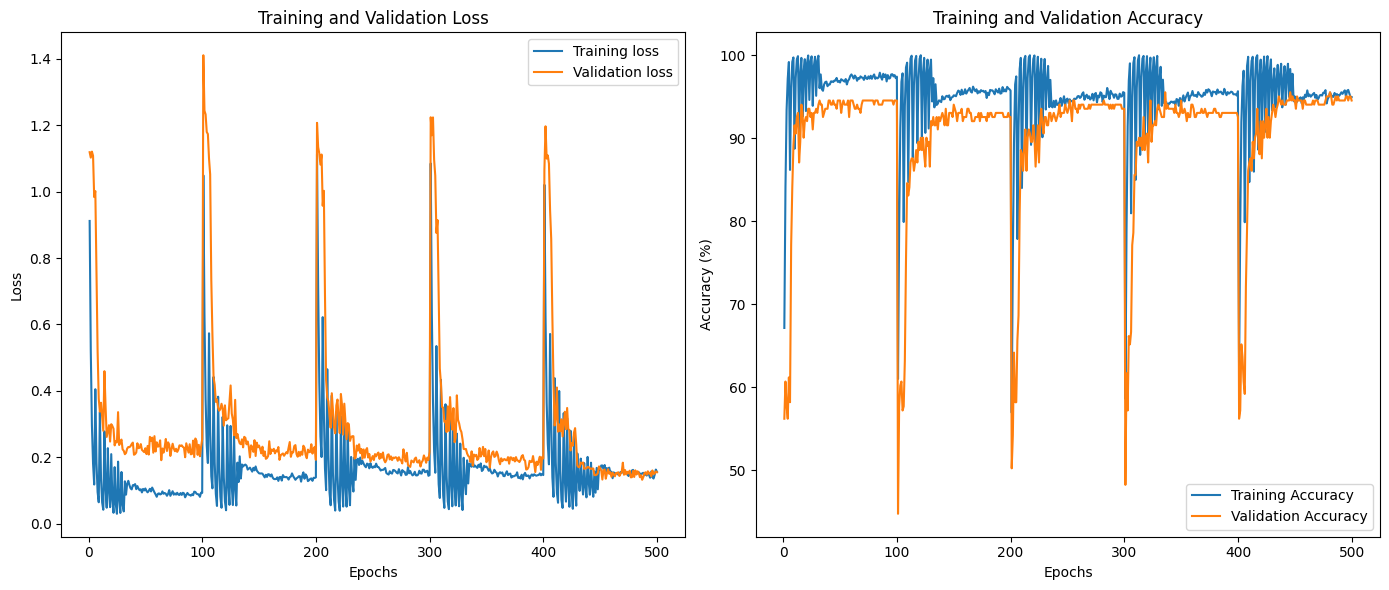

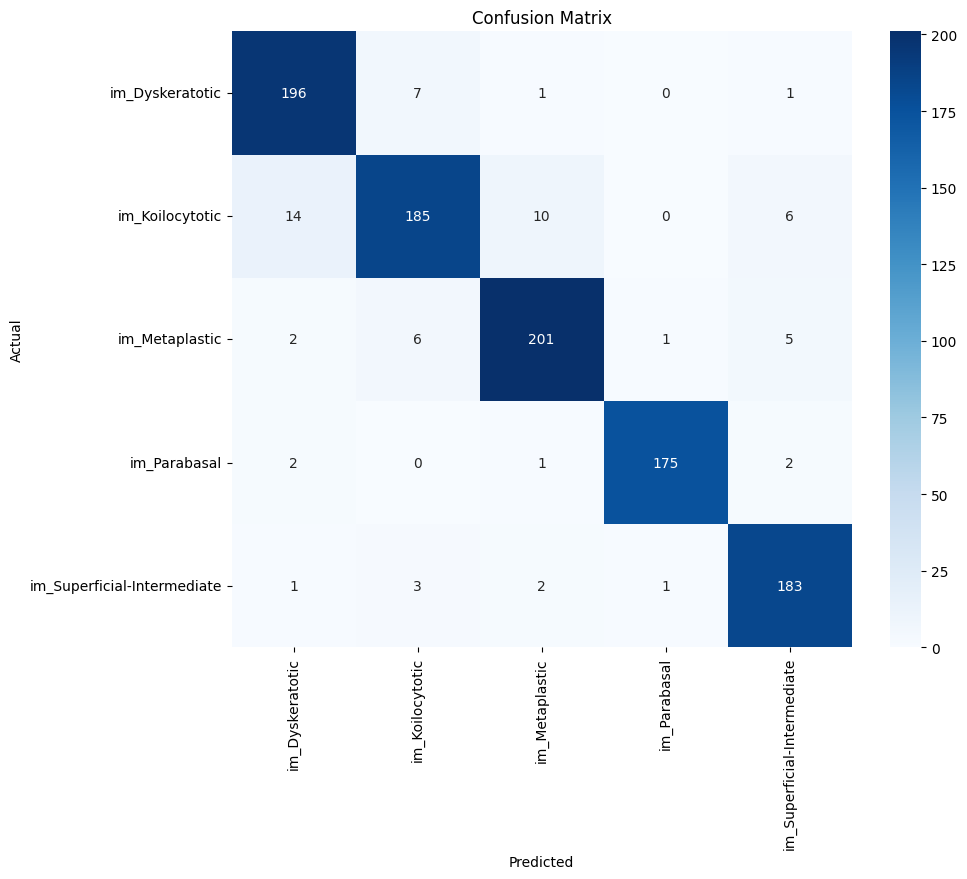

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Average Test Accuracy: 93.53%, Average Test Loss: 0.1993
Average Precision: 0.9382, Average Recall: 0.9374, Average F1-score: 0.9366


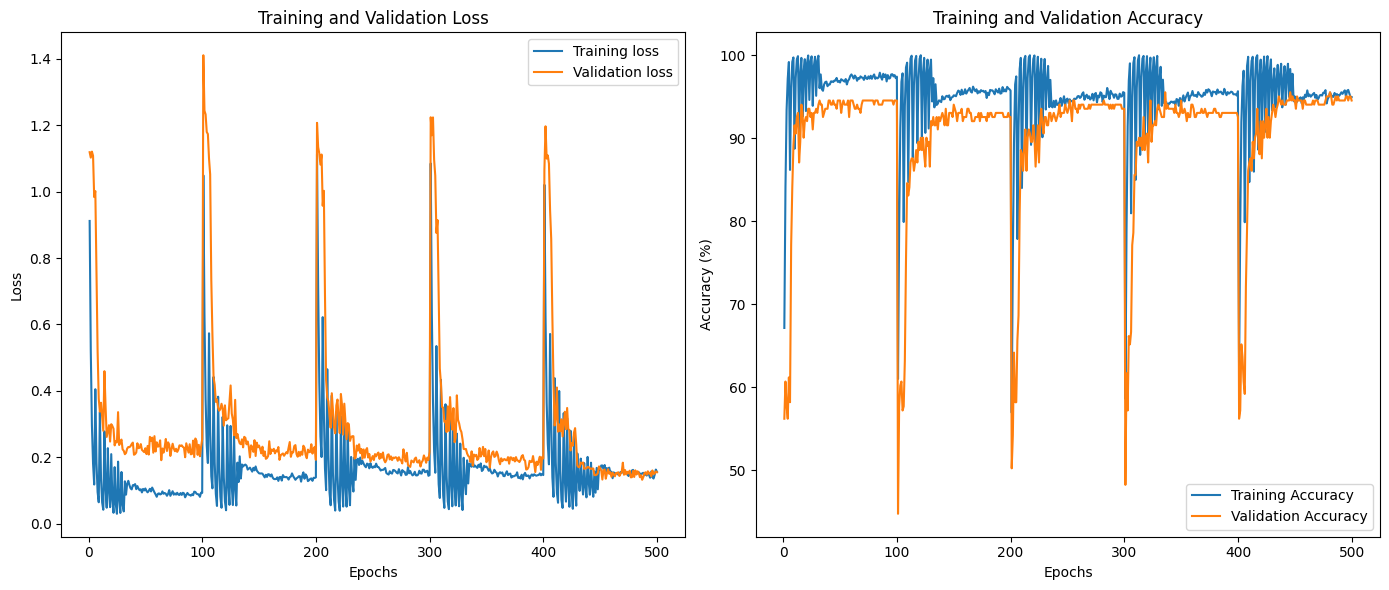

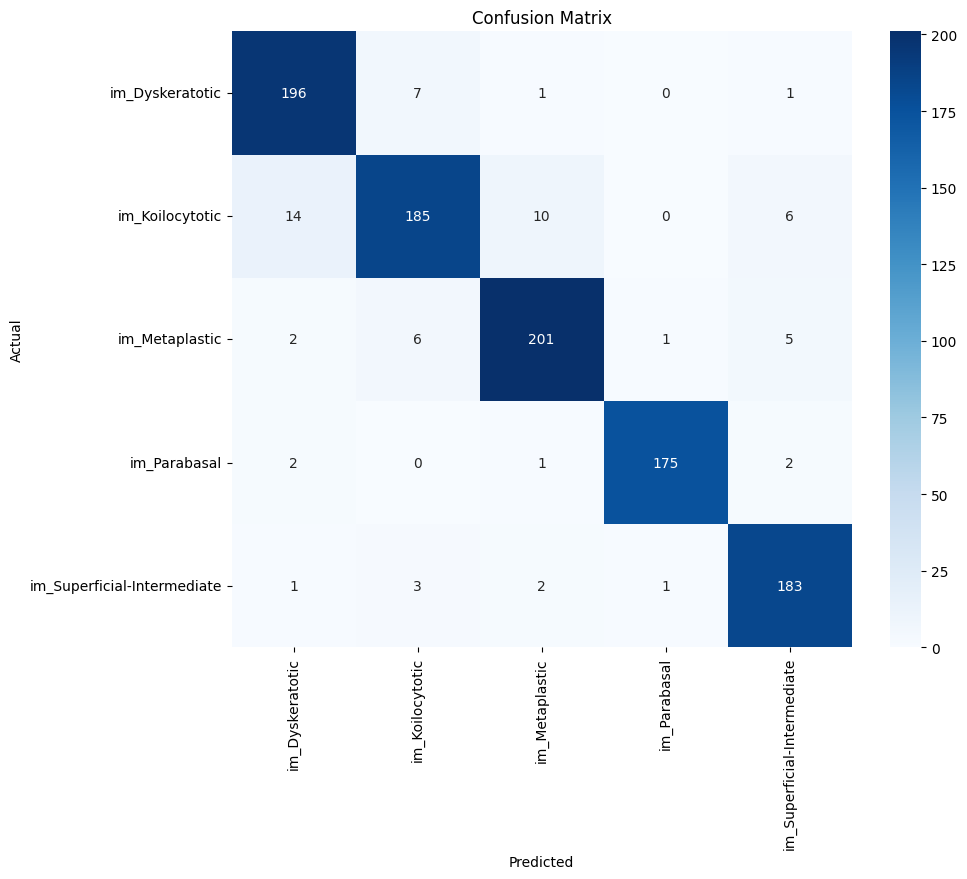

In [9]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
